# Task 4: Link Prediction on MetaFam Knowledge Graph

This notebook implements link prediction using:
- **4 KGE Models**: TransE, DistMult, ComplEx, RotatE
- **2 GNN Models**: RGCN + DistMult, RGCN + RotatE

## Data Splitting Strategies

1. **Naive Random (Type 1)**: Simple random split. Vocabulary built only from training set (inductive risk).
2. **Transductive (Type 2)**: Random split with shared vocabulary from train + valid.
3. **Inverse Leakage Removal (Type 3)**: Groups inverse relation pairs and splits by groups.

## Evaluation
- **Metrics**: MRR (Mean Reciprocal Rank), Hits@1, Hits@10
- **Filtered Evaluation**: Filter out other true triples when ranking
- **Test Set**: External test.txt (never used for training or vocabulary)

## 1. Setup and Imports

**For VS Code with Google Colab Extension:**

1. When selecting kernel, choose **GPU** option (you already did this ✅)
2. Make sure `Precog_task_graphs` folder is in Google Drive (My Drive)
3. Run Cell 3 (Colab Setup) - mounts Drive and changes to project directory
4. Run Cell 4 (Imports) - verifies GPU and imports modules
5. Continue with remaining cells

In [17]:
# ==== COLAB SETUP (Run this cell first!) ====
# For Google Colab with Drive mounted:

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Change to project directory
# IMPORTANT: Update this path if your folder is in a different location
%cd /content/drive/MyDrive/Precog_task_graphs

# Step 3: Verify the folder structure
!ls -la
!ls src/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Precog_task_graphs
total 85
-rw------- 1 root root  4946 Feb  8 21:45 assignment2.md
-rw------- 1 root root  4830 Feb  9 09:28 assignment3.md
-rw------- 1 root root  5169 Feb  9 10:59 assignment4.md
-rw------- 1 root root  5013 Feb  8 17:14 assignment.md
drwx------ 3 root root  4096 Feb  9 15:01 data
drwx------ 2 root root  4096 Feb  9 15:01 .git
-rw------- 1 root root   215 Feb  9 13:27 insights.txt
drwx------ 2 root root  4096 Feb  9 15:01 notebooks
drwx------ 3 root root  4096 Feb  9 15:48 outputs
-rw------- 1 root root     0 Feb  8 16:36 README.md
-rw------- 1 root root   242 Feb  8 22:59 requirements.txt
-rw------- 1 root root 44386 Feb  9 14:56 skill.md
drwx------ 3 root root  4096 Feb  9 15:01 src
communities.py	gnn_models.py  proximity.py  splitting.py
data_loader.py	__init__.py    __pycache__   train_eval.py
exploration.py	kge_

In [18]:
# ==== IMPORTS (Run this cell after mounting Drive!) ====
import sys
import os
import inspect
import warnings
warnings.filterwarnings('ignore')

# Add src to path (using absolute path from current directory)
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
print(f"Added to path: {src_path}")

# ==== GPU CHECK ====
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Using device: {device}")

# Custom modules
from splitting import load_triples, generate_splits, SplitResult
from kge_models import create_kge_model
from gnn_models import create_gnn_model, build_graph_tensors
from train_eval import train_kge_model, train_gnn_model, evaluate_on_test, results_to_csv

# ==== VERSION CHECK ====
# Ensure train_eval.py supports valid_freq (added in latest update)
_kge_sig = inspect.signature(train_kge_model)
_gnn_sig = inspect.signature(train_gnn_model)
_has_valid_freq = 'valid_freq' in _kge_sig.parameters and 'valid_freq' in _gnn_sig.parameters

if _has_valid_freq:
    print("\n[OK] train_eval.py is up-to-date (supports valid_freq)")
else:
    print("\n[WARNING] train_eval.py is OUTDATED on Google Drive!")
    print("  valid_freq parameter is missing from training functions.")
    print("  Applying compatibility wrapper (will validate every epoch).")
    print("  >>> To fix permanently: re-upload the updated src/train_eval.py from your local project to Google Drive <<<\n")
    
    _orig_train_kge = train_kge_model
    _orig_train_gnn = train_gnn_model
    
    def train_kge_model(*args, **kwargs):
        kwargs.pop('valid_freq', None)
        return _orig_train_kge(*args, **kwargs)
    
    def train_gnn_model(*args, **kwargs):
        kwargs.pop('valid_freq', None)
        return _orig_train_gnn(*args, **kwargs)

Added to path: /content/drive/MyDrive/Precog_task_graphs/src

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Using device: cuda

[OK] train_eval.py is up-to-date (supports valid_freq)


## 2. Load Data

In [19]:
# Load training and test data
# Auto-detect correct path (Colab uses project root, local uses notebooks/)
if os.path.exists('data/raw/train.txt'):
    train_file = 'data/raw/train.txt'
    test_file = 'data/raw/test.txt'
else:
    train_file = '../data/raw/train.txt'
    test_file = '../data/raw/test.txt'

print(f"Using data path: {train_file}")
train_triples = load_triples(train_file)
test_triples = load_triples(test_file)

print(f"Training triples: {len(train_triples)}")
print(f"Test triples: {len(test_triples)}")

# Analyze test set
train_entities = set()
train_relations = set()
for h, r, t in train_triples:
    train_entities.add(h)
    train_entities.add(t)
    train_relations.add(r)

test_entities = set()
test_relations = set()
for h, r, t in test_triples:
    test_entities.add(h)
    test_entities.add(t)
    test_relations.add(r)

print(f"\nTrain entities: {len(train_entities)}, relations: {len(train_relations)}")
print(f"Test entities: {len(test_entities)}, relations: {len(test_relations)}")
print(f"Test entities in train: {len(test_entities & train_entities)} / {len(test_entities)}")
print(f"Test relations in train: {len(test_relations & train_relations)} / {len(test_relations)}")

Using data path: data/raw/train.txt
Training triples: 13821
Test triples: 590

Train entities: 1316, relations: 28
Test entities: 751, relations: 4
Test entities in train: 751 / 751
Test relations in train: 4 / 4


## 3. Generate Data Splits

In [20]:
# Generate all three split types
split_types = ['naive_random', 'transductive', 'inverse_leakage_removal']

splits = {}
for split_type in split_types:
    print(f"\n{'='*50}")
    print(f"Generating {split_type} split...")
    splits[split_type] = generate_splits(train_triples, split_type, train_ratio=0.8)
    
    split = splits[split_type]
    print(f"  Train: {len(split.train_triples)} triples")
    print(f"  Valid: {len(split.valid_triples)} triples")
    print(f"  Entities: {len(split.entity_vocab)}")
    print(f"  Relations: {len(split.relation_vocab)}")

# Create full_train split — use ALL training data, no validation
print(f"\n{'='*50}")
print(f"Creating full_train split (no validation)...")

# Build vocab from all training triples
full_entity_vocab = {}
full_relation_vocab = {}
for h, r, t in train_triples:
    if h not in full_entity_vocab:
        full_entity_vocab[h] = len(full_entity_vocab)
    if t not in full_entity_vocab:
        full_entity_vocab[t] = len(full_entity_vocab)
    if r not in full_relation_vocab:
        full_relation_vocab[r] = len(full_relation_vocab)

splits['full_train'] = SplitResult(
    train_triples=train_triples,
    valid_triples=[],
    split_type='full_train',
    entity_vocab=full_entity_vocab,
    relation_vocab=full_relation_vocab,
    vocab_source='train_only',
    stats={
        'total_triples': len(train_triples),
        'train_triples': len(train_triples),
        'valid_triples': 0,
        'note': 'No validation - uses 100% of data for training'
    }
)
split_types.append('full_train')

print(f"  Train: {len(train_triples)} triples (100% of data)")
print(f"  Valid: 0 triples (no validation - trains for all epochs)")
print(f"  Entities: {len(full_entity_vocab)}")
print(f"  Relations: {len(full_relation_vocab)}")


Generating naive_random split...
  Train: 11056 triples
  Valid: 2765 triples
  Entities: 1311
  Relations: 28

Generating transductive split...
  Train: 11056 triples
  Valid: 2765 triples
  Entities: 1316
  Relations: 28

Generating inverse_leakage_removal split...
  Train: 11079 triples
  Valid: 2742 triples
  Entities: 1316
  Relations: 28

Creating full_train split (no validation)...
  Train: 13821 triples (100% of data)
  Valid: 0 triples (no validation - trains for all epochs)
  Entities: 1316
  Relations: 28


## 4. Configuration

In [21]:
# Hyperparameters
CONFIG = {
    'embedding_dim': 100,
    'epochs': 50,  # Reduced for faster experimentation (increase for final results)
    'batch_size': 128,
    'lr': 0.001,
    'num_neg_samples': 5,
    'margin': 1.0,
    'patience': 5,  # Early stopping patience (in validation checks)
    'valid_freq': 5,  # Validate every N epochs
    
    # GNN-specific
    'num_rgcn_layers': 2,
    'num_bases': 4,  # For basis decomposition
    'dropout': 0.2
}

# Models to train
KGE_MODELS = ['TransE', 'DistMult', 'ComplEx', 'RotatE']
GNN_MODELS = ['RGCN_DistMult', 'RGCN_RotatE']
ALL_MODELS = KGE_MODELS + GNN_MODELS

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")
print(f"\nModels to train: {ALL_MODELS}")

Configuration:
  embedding_dim: 100
  epochs: 50
  batch_size: 128
  lr: 0.001
  num_neg_samples: 5
  margin: 1.0
  patience: 5
  valid_freq: 5
  num_rgcn_layers: 2
  num_bases: 4
  dropout: 0.2

Models to train: ['TransE', 'DistMult', 'ComplEx', 'RotatE', 'RGCN_DistMult', 'RGCN_RotatE']


## 5. Training and Evaluation

For each split type (run independently):
1. Train 4 KGE models (TransE, DistMult, ComplEx, RotatE)
2. Train 2 GNN models (RGCN+DistMult, RGCN+RotatE)
3. Evaluate each on validation set (filtered MRR, Hits@k)
4. Evaluate each on test set (test.txt)

In [22]:
# Initialize results storage and define training helper
all_results = []

def train_and_evaluate_split(split_type, splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS):
    """Train all models for a given split type and return results."""
    results = []
    
    split = splits[split_type]
    num_entities = len(split.entity_vocab)
    num_relations = len(split.relation_vocab)
    
    # Build graph tensors for GNN models (from training data)
    edge_index, edge_type = build_graph_tensors(
        split.train_triples, split.entity_vocab, split.relation_vocab, device
    )
    
    # ===== TRAIN KGE MODELS =====
    for model_name in KGE_MODELS:
        print(f"\n{'='*50}")
        print(f"Training {model_name} on {split_type} split...")
        
        model = create_kge_model(
            model_name, num_entities, num_relations, CONFIG['embedding_dim']
        )
        
        history = train_kge_model(
            model=model,
            train_triples=split.train_triples,
            valid_triples=split.valid_triples,
            entity_vocab=split.entity_vocab,
            relation_vocab=split.relation_vocab,
            device=device,
            epochs=CONFIG['epochs'],
            batch_size=CONFIG['batch_size'],
            lr=CONFIG['lr'],
            num_neg_samples=CONFIG['num_neg_samples'],
            margin=CONFIG['margin'],
            patience=CONFIG['patience'],
            valid_freq=CONFIG['valid_freq'],
            model_name=model_name,
            verbose=True
        )
        
        print(f"Evaluating on test set...")
        test_metrics = evaluate_on_test(
            model=model,
            test_triples=test_triples,
            train_triples=split.train_triples,
            valid_triples=split.valid_triples,
            entity_vocab=split.entity_vocab,
            relation_vocab=split.relation_vocab,
            device=device,
            is_gnn=False
        )
        
        result = {
            'split_type': split_type,
            'model': model_name,
            'valid_mrr': history['valid_mrr'][-1] if history['valid_mrr'] else 0,
            'valid_hits1': history['valid_hits1'][-1] if history['valid_hits1'] else 0,
            'valid_hits10': history['valid_hits10'][-1] if history['valid_hits10'] else 0,
            'test_mrr': test_metrics['mrr'],
            'test_hits1': test_metrics['hits_at_1'],
            'test_hits10': test_metrics['hits_at_10'],
            'best_epoch': history['best_epoch']
        }
        results.append(result)
        
        print(f"\n{model_name} Results:")
        print(f"  Valid - MRR: {result['valid_mrr']:.4f}, H@1: {result['valid_hits1']:.4f}, H@10: {result['valid_hits10']:.4f}")
        print(f"  Test  - MRR: {result['test_mrr']:.4f}, H@1: {result['test_hits1']:.4f}, H@10: {result['test_hits10']:.4f}")
    
    # ===== TRAIN GNN MODELS =====
    for model_name in GNN_MODELS:
        print(f"\n{'='*50}")
        print(f"Training {model_name} on {split_type} split...")
        
        model = create_gnn_model(
            model_name, num_entities, num_relations,
            hidden_dim=CONFIG['embedding_dim'],
            num_layers=CONFIG['num_rgcn_layers'],
            num_bases=CONFIG['num_bases'],
            dropout=CONFIG['dropout']
        )
        
        history = train_gnn_model(
            model=model,
            train_triples=split.train_triples,
            valid_triples=split.valid_triples,
            entity_vocab=split.entity_vocab,
            relation_vocab=split.relation_vocab,
            device=device,
            epochs=CONFIG['epochs'],
            batch_size=CONFIG['batch_size'],
            lr=CONFIG['lr'],
            num_neg_samples=CONFIG['num_neg_samples'],
            margin=CONFIG['margin'],
            patience=CONFIG['patience'],
            valid_freq=CONFIG['valid_freq'],
            model_name=model_name,
            verbose=True
        )
        
        print(f"Evaluating on test set...")
        test_metrics = evaluate_on_test(
            model=model,
            test_triples=test_triples,
            train_triples=split.train_triples,
            valid_triples=split.valid_triples,
            entity_vocab=split.entity_vocab,
            relation_vocab=split.relation_vocab,
            device=device,
            is_gnn=True,
            edge_index=edge_index,
            edge_type=edge_type
        )
        
        result = {
            'split_type': split_type,
            'model': model_name,
            'valid_mrr': history['valid_mrr'][-1] if history['valid_mrr'] else 0,
            'valid_hits1': history['valid_hits1'][-1] if history['valid_hits1'] else 0,
            'valid_hits10': history['valid_hits10'][-1] if history['valid_hits10'] else 0,
            'test_mrr': test_metrics['mrr'],
            'test_hits1': test_metrics['hits_at_1'],
            'test_hits10': test_metrics['hits_at_10'],
            'best_epoch': history['best_epoch']
        }
        results.append(result)
        
        print(f"\n{model_name} Results:")
        print(f"  Valid - MRR: {result['valid_mrr']:.4f}, H@1: {result['valid_hits1']:.4f}, H@10: {result['valid_hits10']:.4f}")
        print(f"  Test  - MRR: {result['test_mrr']:.4f}, H@1: {result['test_hits1']:.4f}, H@10: {result['test_hits10']:.4f}")
    
    return results

print("Training helper ready. Run the next 3 cells to train on each split type.")

Training helper ready. Run the next 3 cells to train on each split type.


### 5a. Naive Random Split (Type 1)

Simple random 80/20 split. Vocabulary built **only from training set** — entities in validation that don't appear in training will be unseen (inductive risk).

In [24]:
# Train all 6 models on naive_random split
print(f"{'#'*60}")
print(f"# Split Type: NAIVE_RANDOM")
print(f"{'#'*60}")

naive_results = train_and_evaluate_split(
    'naive_random', splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS
)
all_results.extend(naive_results)
print(f"\nCompleted naive_random: {len(naive_results)} models trained.")

############################################################
# Split Type: NAIVE_RANDOM
############################################################

Training TransE on naive_random split...


Epoch 1/50:   0%|          | 0/87 [00:00<?, ?it/s, loss=0.9995]

Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 107.93it/s, loss=0.9698]


Epoch 1: Loss=0.9861


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 111.45it/s, loss=0.8530]


Epoch 2: Loss=0.9129


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 110.89it/s, loss=0.6527]


Epoch 3: Loss=0.7524


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 112.64it/s, loss=0.3550]


Epoch 4: Loss=0.4851


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 85.29it/s, loss=0.1575] 


Epoch 5: Loss=0.2371 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5506, H@1=0.3662, H@10=0.9236


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 101.29it/s, loss=0.0580]


Epoch 6: Loss=0.1111


Epoch 7/50: 100%|██████████| 87/87 [00:00<00:00, 107.87it/s, loss=0.0227]


Epoch 7: Loss=0.0632


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 109.56it/s, loss=0.0186]


Epoch 8: Loss=0.0427


Epoch 9/50: 100%|██████████| 87/87 [00:00<00:00, 111.16it/s, loss=0.0236]


Epoch 9: Loss=0.0314


Epoch 10/50: 100%|██████████| 87/87 [00:00<00:00, 105.92it/s, loss=0.0130]


Epoch 10: Loss=0.0245 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6209, H@1=0.4391, H@10=0.9695


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 108.60it/s, loss=0.0171]


Epoch 11: Loss=0.0199


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 108.62it/s, loss=0.0004]


Epoch 12: Loss=0.0157


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 107.95it/s, loss=0.0129]


Epoch 13: Loss=0.0144


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 107.74it/s, loss=0.0165]


Epoch 14: Loss=0.0125


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 110.57it/s, loss=0.0082]


Epoch 15: Loss=0.0117 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6334, H@1=0.4532, H@10=0.9755


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 72.32it/s, loss=0.0066]


Epoch 16: Loss=0.0108


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 102.50it/s, loss=0.0159]


Epoch 17: Loss=0.0107


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 107.82it/s, loss=0.0067]


Epoch 18: Loss=0.0102


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 108.10it/s, loss=0.0026]


Epoch 19: Loss=0.0094


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 105.97it/s, loss=0.0068]


Epoch 20: Loss=0.0091 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6567, H@1=0.4837, H@10=0.9817


Epoch 21/50: 100%|██████████| 87/87 [00:00<00:00, 109.29it/s, loss=0.0070]


Epoch 21: Loss=0.0093


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 105.66it/s, loss=0.0058]


Epoch 22: Loss=0.0087


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 109.00it/s, loss=0.0159]


Epoch 23: Loss=0.0090


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 108.51it/s, loss=0.0065]


Epoch 24: Loss=0.0087


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 108.07it/s, loss=0.0149]


Epoch 25: Loss=0.0089 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6699, H@1=0.4985, H@10=0.9862


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 79.33it/s, loss=0.0075]


Epoch 26: Loss=0.0083


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 80.12it/s, loss=0.0128]


Epoch 27: Loss=0.0082


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 91.58it/s, loss=0.0090] 


Epoch 28: Loss=0.0087


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 104.38it/s, loss=0.0078]


Epoch 29: Loss=0.0075


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 106.17it/s, loss=0.0102]


Epoch 30: Loss=0.0080 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6766, H@1=0.5018, H@10=0.9869


Epoch 31/50: 100%|██████████| 87/87 [00:00<00:00, 109.05it/s, loss=0.0046]


Epoch 31: Loss=0.0073


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 108.02it/s, loss=0.0074]


Epoch 32: Loss=0.0076


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 109.42it/s, loss=0.0102]


Epoch 33: Loss=0.0072


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 108.46it/s, loss=0.0036]


Epoch 34: Loss=0.0072


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 109.62it/s, loss=0.0001]


Epoch 35: Loss=0.0072 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6859, H@1=0.5132, H@10=0.9886


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 87.15it/s, loss=0.0155] 


Epoch 36: Loss=0.0077


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 79.39it/s, loss=0.0040]


Epoch 37: Loss=0.0065


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 78.72it/s, loss=0.0096]


Epoch 38: Loss=0.0073


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 78.32it/s, loss=0.0085]


Epoch 39: Loss=0.0068


Epoch 40/50: 100%|██████████| 87/87 [00:00<00:00, 104.83it/s, loss=0.0116]


Epoch 40: Loss=0.0064 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6931, H@1=0.5212, H@10=0.9891


Epoch 41/50: 100%|██████████| 87/87 [00:00<00:00, 110.43it/s, loss=0.0138]


Epoch 41: Loss=0.0066


Epoch 42/50: 100%|██████████| 87/87 [00:00<00:00, 110.16it/s, loss=0.0032]


Epoch 42: Loss=0.0066


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 107.28it/s, loss=0.0031]


Epoch 43: Loss=0.0064


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 111.72it/s, loss=0.0108]


Epoch 44: Loss=0.0067


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 113.90it/s, loss=0.0086]


Epoch 45: Loss=0.0067 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7045, H@1=0.5323, H@10=0.9906


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 107.38it/s, loss=0.0064]


Epoch 46: Loss=0.0064


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 100.07it/s, loss=0.0065]


Epoch 47: Loss=0.0064


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 81.89it/s, loss=0.0067]


Epoch 48: Loss=0.0062


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 72.47it/s, loss=0.0000]


Epoch 49: Loss=0.0054


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 74.49it/s, loss=0.0027]


Epoch 50: Loss=0.0058 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7167, H@1=0.5488, H@10=0.9927
Evaluating on test set...
  Evaluating: 588/588 triples...

TransE Results:
  Valid - MRR: 0.7167, H@1: 0.5488, H@10: 0.9927
  Test  - MRR: 0.7148, H@1: 0.5706, H@10: 0.9753

Training DistMult on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 113.24it/s, loss=1.0001]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 113.71it/s, loss=0.9964]


Epoch 2: Loss=0.9972


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 111.44it/s, loss=0.9812]


Epoch 3: Loss=0.9889


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 114.85it/s, loss=0.9175]


Epoch 4: Loss=0.9533


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 111.82it/s, loss=0.7054]


Epoch 5: Loss=0.8220 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.4677, H@1=0.3420, H@10=0.6899


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 112.37it/s, loss=0.2959]


Epoch 6: Loss=0.5019


Epoch 7/50: 100%|██████████| 87/87 [00:00<00:00, 108.45it/s, loss=0.1095]


Epoch 7: Loss=0.1953


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 100.89it/s, loss=0.0719]


Epoch 8: Loss=0.0712


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 77.60it/s, loss=0.0213]


Epoch 9: Loss=0.0301


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 82.07it/s, loss=0.0086]


Epoch 10: Loss=0.0156 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7156, H@1=0.5704, H@10=0.9440


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 111.01it/s, loss=0.0087]


Epoch 11: Loss=0.0097


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 116.03it/s, loss=0.0052]


Epoch 12: Loss=0.0069


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 112.62it/s, loss=0.0005]


Epoch 13: Loss=0.0050


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 112.13it/s, loss=0.0022]


Epoch 14: Loss=0.0043


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 109.56it/s, loss=0.0015]


Epoch 15: Loss=0.0035 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7349, H@1=0.5885, H@10=0.9625


Epoch 16/50: 100%|██████████| 87/87 [00:00<00:00, 109.29it/s, loss=0.0028]


Epoch 16: Loss=0.0031


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 111.41it/s, loss=0.0005]


Epoch 17: Loss=0.0027


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 115.67it/s, loss=0.0029]


Epoch 18: Loss=0.0025


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 113.05it/s, loss=0.0018]


Epoch 19: Loss=0.0024


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 107.36it/s, loss=0.0072]


Epoch 20: Loss=0.0026 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7436, H@1=0.5981, H@10=0.9655


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 77.35it/s, loss=0.0029]


Epoch 21: Loss=0.0021


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 109.42it/s, loss=0.0000]


Epoch 22: Loss=0.0017


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 115.79it/s, loss=0.0000]


Epoch 23: Loss=0.0018


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 113.88it/s, loss=0.0032]


Epoch 24: Loss=0.0019


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 113.42it/s, loss=0.0051]


Epoch 25: Loss=0.0019 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7492, H@1=0.6048, H@10=0.9674


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 109.51it/s, loss=0.0015]


Epoch 26: Loss=0.0018


Epoch 27/50: 100%|██████████| 87/87 [00:00<00:00, 111.93it/s, loss=0.0035]


Epoch 27: Loss=0.0017


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 113.00it/s, loss=0.0070]


Epoch 28: Loss=0.0016


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 112.64it/s, loss=0.0017]


Epoch 29: Loss=0.0017


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 110.98it/s, loss=0.0001]


Epoch 30: Loss=0.0017 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7539, H@1=0.6110, H@10=0.9703


Epoch 31/50: 100%|██████████| 87/87 [00:00<00:00, 89.24it/s, loss=0.0024]


Epoch 31: Loss=0.0016


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 86.31it/s, loss=0.0049]


Epoch 32: Loss=0.0014


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 84.86it/s, loss=0.0034]


Epoch 33: Loss=0.0016


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 91.84it/s, loss=0.0009] 


Epoch 34: Loss=0.0013


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 111.97it/s, loss=0.0000]


Epoch 35: Loss=0.0015 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7587, H@1=0.6181, H@10=0.9715


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 110.57it/s, loss=0.0000]


Epoch 36: Loss=0.0013


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 111.57it/s, loss=0.0003]


Epoch 37: Loss=0.0011


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 115.18it/s, loss=0.0000]


Epoch 38: Loss=0.0011


Epoch 39/50: 100%|██████████| 87/87 [00:00<00:00, 112.52it/s, loss=0.0010]


Epoch 39: Loss=0.0012


Epoch 40/50: 100%|██████████| 87/87 [00:00<00:00, 112.79it/s, loss=0.0044]


Epoch 40: Loss=0.0012 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7599, H@1=0.6182, H@10=0.9717


Epoch 41/50: 100%|██████████| 87/87 [00:00<00:00, 111.31it/s, loss=0.0006]


Epoch 41: Loss=0.0014


Epoch 42/50: 100%|██████████| 87/87 [00:00<00:00, 117.06it/s, loss=0.0006]


Epoch 42: Loss=0.0012


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 92.44it/s, loss=0.0000] 


Epoch 43: Loss=0.0010


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 86.59it/s, loss=0.0000]


Epoch 44: Loss=0.0011


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 88.36it/s, loss=0.0004]


Epoch 45: Loss=0.0010 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7624, H@1=0.6219, H@10=0.9732


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 113.87it/s, loss=0.0000]


Epoch 46: Loss=0.0011


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 113.61it/s, loss=0.0000]


Epoch 47: Loss=0.0011


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 112.16it/s, loss=0.0018]


Epoch 48: Loss=0.0010


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 115.74it/s, loss=0.0045]


Epoch 49: Loss=0.0011


Epoch 50/50: 100%|██████████| 87/87 [00:00<00:00, 115.08it/s, loss=0.0000]


Epoch 50: Loss=0.0009 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7666, H@1=0.6289, H@10=0.9728
Evaluating on test set...
  Evaluating: 588/588 triples...

DistMult Results:
  Valid - MRR: 0.7666, H@1: 0.6289, H@10: 0.9728
  Test  - MRR: 0.6463, H@1: 0.4753, H@10: 0.9405

Training ComplEx on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 80.96it/s, loss=1.0003]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 82.12it/s, loss=0.9896]


Epoch 2: Loss=0.9926


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 74.14it/s, loss=0.9558]


Epoch 3: Loss=0.9711


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 59.69it/s, loss=0.7946]


Epoch 4: Loss=0.8779


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 56.13it/s, loss=0.2523]


Epoch 5: Loss=0.5316 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7310, H@1=0.6025, H@10=0.9218


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 78.83it/s, loss=0.0745]


Epoch 6: Loss=0.1086


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 80.13it/s, loss=0.0170]


Epoch 7: Loss=0.0168


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 79.92it/s, loss=0.0126]


Epoch 8: Loss=0.0052


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 80.95it/s, loss=0.0047]


Epoch 9: Loss=0.0027


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 81.29it/s, loss=0.0000]


Epoch 10: Loss=0.0020 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8338, H@1=0.7131, H@10=0.9888


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 58.86it/s, loss=0.0033]


Epoch 11: Loss=0.0015


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 61.12it/s, loss=0.0011]


Epoch 12: Loss=0.0014


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 81.58it/s, loss=0.0004]


Epoch 13: Loss=0.0012


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 80.08it/s, loss=0.0002]


Epoch 14: Loss=0.0012


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 79.94it/s, loss=0.0050]


Epoch 15: Loss=0.0010 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8375, H@1=0.7169, H@10=0.9908


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 80.77it/s, loss=0.0007]


Epoch 16: Loss=0.0012


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 80.37it/s, loss=0.0000]


Epoch 17: Loss=0.0012


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 79.04it/s, loss=0.0003]


Epoch 18: Loss=0.0012


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 66.93it/s, loss=0.0000]


Epoch 19: Loss=0.0010


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 59.62it/s, loss=0.0000]


Epoch 20: Loss=0.0012 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8399, H@1=0.7205, H@10=0.9913


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 78.27it/s, loss=0.0000]


Epoch 21: Loss=0.0009


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 80.62it/s, loss=0.0000]


Epoch 22: Loss=0.0009


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 81.01it/s, loss=0.0030]


Epoch 23: Loss=0.0009


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 81.92it/s, loss=0.0000]


Epoch 24: Loss=0.0007


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 77.14it/s, loss=0.0009]


Epoch 25: Loss=0.0008 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8435, H@1=0.7271, H@10=0.9915


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 61.72it/s, loss=0.0000]


Epoch 26: Loss=0.0011


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 58.15it/s, loss=0.0000]


Epoch 27: Loss=0.0007


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 62.26it/s, loss=0.0000]


Epoch 28: Loss=0.0009


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 79.75it/s, loss=0.0001]


Epoch 29: Loss=0.0008


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 80.01it/s, loss=0.0036]


Epoch 30: Loss=0.0008 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8453, H@1=0.7291, H@10=0.9917


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 81.86it/s, loss=0.0000]


Epoch 31: Loss=0.0008


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 80.51it/s, loss=0.0000]


Epoch 32: Loss=0.0009


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 79.30it/s, loss=0.0000]


Epoch 33: Loss=0.0008


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 82.12it/s, loss=0.0000]


Epoch 34: Loss=0.0007


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 64.27it/s, loss=0.0000]


Epoch 35: Loss=0.0007 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8488, H@1=0.7336, H@10=0.9920


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 79.79it/s, loss=0.0000]


Epoch 36: Loss=0.0008


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 79.61it/s, loss=0.0000]


Epoch 37: Loss=0.0007


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 80.12it/s, loss=0.0038]


Epoch 38: Loss=0.0008


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 78.76it/s, loss=0.0000]


Epoch 39: Loss=0.0008


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 80.60it/s, loss=0.0000]


Epoch 40: Loss=0.0008 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8489, H@1=0.7334, H@10=0.9922


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 71.22it/s, loss=0.0001]


Epoch 41: Loss=0.0007


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 60.60it/s, loss=0.0019]


Epoch 42: Loss=0.0007


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 57.27it/s, loss=0.0030]


Epoch 43: Loss=0.0005


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 77.42it/s, loss=0.0000]


Epoch 44: Loss=0.0007


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 79.32it/s, loss=0.0001]


Epoch 45: Loss=0.0006 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8523, H@1=0.7405, H@10=0.9918


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 83.28it/s, loss=0.0008]


Epoch 46: Loss=0.0006


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 82.35it/s, loss=0.0000]


Epoch 47: Loss=0.0006


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 81.45it/s, loss=0.0000]


Epoch 48: Loss=0.0005


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 81.77it/s, loss=0.0000]


Epoch 49: Loss=0.0005


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 80.37it/s, loss=0.0008]


Epoch 50: Loss=0.0005 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8508, H@1=0.7370, H@10=0.9920
Evaluating on test set...
  Evaluating: 588/588 triples...

ComplEx Results:
  Valid - MRR: 0.8508, H@1: 0.7370, H@10: 0.9920
  Test  - MRR: 0.8424, H@1: 0.7423, H@10: 0.9923

Training RotatE on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 76.42it/s, loss=0.7556]


Epoch 1: Loss=0.8719


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 78.53it/s, loss=0.5450]


Epoch 2: Loss=0.5232


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 80.01it/s, loss=0.3565]


Epoch 3: Loss=0.3065


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 79.51it/s, loss=0.1258]


Epoch 4: Loss=0.1337


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 77.82it/s, loss=0.0568]


Epoch 5: Loss=0.0514 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.0942, H@1=0.0423, H@10=0.1960


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 61.93it/s, loss=0.0389]


Epoch 6: Loss=0.0240


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 60.42it/s, loss=0.0198]


Epoch 7: Loss=0.0139


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 59.19it/s, loss=0.0049]


Epoch 8: Loss=0.0096


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 77.82it/s, loss=0.0025]


Epoch 9: Loss=0.0075


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 79.70it/s, loss=0.0105]


Epoch 10: Loss=0.0058 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.1584, H@1=0.0764, H@10=0.3297


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 78.67it/s, loss=0.0042]


Epoch 11: Loss=0.0047


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 77.83it/s, loss=0.0005]


Epoch 12: Loss=0.0044


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 78.66it/s, loss=0.0027]


Epoch 13: Loss=0.0038


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 78.39it/s, loss=0.0051]


Epoch 14: Loss=0.0034


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 62.65it/s, loss=0.0028]


Epoch 15: Loss=0.0030 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.1870, H@1=0.0923, H@10=0.3914


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 78.86it/s, loss=0.0051]


Epoch 16: Loss=0.0030


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 79.16it/s, loss=0.0035]


Epoch 17: Loss=0.0026


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 77.87it/s, loss=0.0079]


Epoch 18: Loss=0.0027


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 78.46it/s, loss=0.0016]


Epoch 19: Loss=0.0027


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 76.15it/s, loss=0.0017]


Epoch 20: Loss=0.0023 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2099, H@1=0.1094, H@10=0.4213


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 65.63it/s, loss=0.0024]


Epoch 21: Loss=0.0023


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 58.13it/s, loss=0.0005]


Epoch 22: Loss=0.0021


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 59.07it/s, loss=0.0004]


Epoch 23: Loss=0.0019


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 79.20it/s, loss=0.0019]


Epoch 24: Loss=0.0019


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 78.54it/s, loss=0.0024]


Epoch 25: Loss=0.0022 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2283, H@1=0.1224, H@10=0.4532


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 76.35it/s, loss=0.0024]


Epoch 26: Loss=0.0019


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 76.08it/s, loss=0.0000]


Epoch 27: Loss=0.0017


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 78.29it/s, loss=0.0016]


Epoch 28: Loss=0.0016


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 78.03it/s, loss=0.0005]


Epoch 29: Loss=0.0015


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 62.68it/s, loss=0.0000]


Epoch 30: Loss=0.0016 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2401, H@1=0.1279, H@10=0.4775


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 79.55it/s, loss=0.0024]


Epoch 31: Loss=0.0015


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 79.37it/s, loss=0.0024]


Epoch 32: Loss=0.0017


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 76.57it/s, loss=0.0045]


Epoch 33: Loss=0.0015


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 76.49it/s, loss=0.0010]


Epoch 34: Loss=0.0016


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 79.23it/s, loss=0.0008]


Epoch 35: Loss=0.0014 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2598, H@1=0.1507, H@10=0.4900


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 64.54it/s, loss=0.0000]


Epoch 36: Loss=0.0014


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 56.86it/s, loss=0.0001]


Epoch 37: Loss=0.0015


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 61.12it/s, loss=0.0022]


Epoch 38: Loss=0.0013


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 78.43it/s, loss=0.0030]


Epoch 39: Loss=0.0016


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 77.92it/s, loss=0.0064]


Epoch 40: Loss=0.0015 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2676, H@1=0.1529, H@10=0.5091


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 76.07it/s, loss=0.0000]


Epoch 41: Loss=0.0012


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 80.80it/s, loss=0.0036]


Epoch 42: Loss=0.0015


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 78.72it/s, loss=0.0000]


Epoch 43: Loss=0.0012


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 78.20it/s, loss=0.0000]


Epoch 44: Loss=0.0013


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 59.07it/s, loss=0.0014]


Epoch 45: Loss=0.0014 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2934, H@1=0.1757, H@10=0.5413


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 79.54it/s, loss=0.0033]


Epoch 46: Loss=0.0012


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 78.85it/s, loss=0.0011]


Epoch 47: Loss=0.0012


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 79.44it/s, loss=0.0030]


Epoch 48: Loss=0.0010


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 79.60it/s, loss=0.0001]


Epoch 49: Loss=0.0012


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 79.07it/s, loss=0.0000]


Epoch 50: Loss=0.0011 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2995, H@1=0.1795, H@10=0.5499
Evaluating on test set...
  Evaluating: 588/588 triples...

RotatE Results:
  Valid - MRR: 0.2995, H@1: 0.1795, H@10: 0.5499
  Test  - MRR: 0.1713, H@1: 0.0833, H@10: 0.3605

Training RGCN_DistMult on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:05<00:00, 15.63it/s, loss=0.5902]


Epoch 1: Loss=0.8288


Epoch 2/50: 100%|██████████| 87/87 [00:04<00:00, 18.12it/s, loss=0.2863]


Epoch 2: Loss=0.4222


Epoch 3/50: 100%|██████████| 87/87 [00:05<00:00, 15.37it/s, loss=0.2669]


Epoch 3: Loss=0.2695


Epoch 4/50: 100%|██████████| 87/87 [00:04<00:00, 17.73it/s, loss=0.1410]


Epoch 4: Loss=0.1820


Epoch 5/50: 100%|██████████| 87/87 [00:04<00:00, 17.46it/s, loss=0.1023]


Epoch 5: Loss=0.1287 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.0817, H@1=0.0279, H@10=0.1774


Epoch 6/50: 100%|██████████| 87/87 [00:05<00:00, 17.14it/s, loss=0.0935]


Epoch 6: Loss=0.0956


Epoch 7/50: 100%|██████████| 87/87 [00:04<00:00, 17.78it/s, loss=0.0869]


Epoch 7: Loss=0.0719


Epoch 8/50: 100%|██████████| 87/87 [00:05<00:00, 15.21it/s, loss=0.0557]


Epoch 8: Loss=0.0526


Epoch 9/50: 100%|██████████| 87/87 [00:04<00:00, 17.60it/s, loss=0.0352]


Epoch 9: Loss=0.0395


Epoch 10/50: 100%|██████████| 87/87 [00:05<00:00, 16.00it/s, loss=0.0341]


Epoch 10: Loss=0.0353 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2334, H@1=0.1172, H@10=0.4895


Epoch 11/50: 100%|██████████| 87/87 [00:04<00:00, 17.64it/s, loss=0.0238]


Epoch 11: Loss=0.0268


Epoch 12/50: 100%|██████████| 87/87 [00:05<00:00, 16.48it/s, loss=0.0044]


Epoch 12: Loss=0.0218


Epoch 13/50: 100%|██████████| 87/87 [00:05<00:00, 16.36it/s, loss=0.0154]


Epoch 13: Loss=0.0206


Epoch 14/50: 100%|██████████| 87/87 [00:04<00:00, 17.94it/s, loss=0.0385]


Epoch 14: Loss=0.0177


Epoch 15/50: 100%|██████████| 87/87 [00:05<00:00, 15.36it/s, loss=0.0084]


Epoch 15: Loss=0.0146 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.3617, H@1=0.2135, H@10=0.6948


Epoch 16/50: 100%|██████████| 87/87 [00:04<00:00, 18.28it/s, loss=0.0123]


Epoch 16: Loss=0.0137


Epoch 17/50: 100%|██████████| 87/87 [00:05<00:00, 15.82it/s, loss=0.0070]


Epoch 17: Loss=0.0112


Epoch 18/50: 100%|██████████| 87/87 [00:04<00:00, 17.68it/s, loss=0.0163]


Epoch 18: Loss=0.0120


Epoch 19/50: 100%|██████████| 87/87 [00:04<00:00, 17.49it/s, loss=0.0006]


Epoch 19: Loss=0.0106


Epoch 20/50: 100%|██████████| 87/87 [00:05<00:00, 15.37it/s, loss=0.0031]


Epoch 20: Loss=0.0106 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.4710, H@1=0.3177, H@10=0.7929


Epoch 21/50: 100%|██████████| 87/87 [00:04<00:00, 17.63it/s, loss=0.0206]


Epoch 21: Loss=0.0089


Epoch 22/50: 100%|██████████| 87/87 [00:05<00:00, 15.16it/s, loss=0.0055]


Epoch 22: Loss=0.0073


Epoch 23/50: 100%|██████████| 87/87 [00:04<00:00, 17.54it/s, loss=0.0053]


Epoch 23: Loss=0.0078


Epoch 24/50: 100%|██████████| 87/87 [00:05<00:00, 16.38it/s, loss=0.0039]


Epoch 24: Loss=0.0075


Epoch 25/50: 100%|██████████| 87/87 [00:05<00:00, 15.74it/s, loss=0.0050]


Epoch 25: Loss=0.0075 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5230, H@1=0.3627, H@10=0.8471


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 16.73it/s, loss=0.0120]


Epoch 26: Loss=0.0071


Epoch 27/50: 100%|██████████| 87/87 [00:05<00:00, 15.41it/s, loss=0.0166]


Epoch 27: Loss=0.0066


Epoch 28/50: 100%|██████████| 87/87 [00:05<00:00, 17.31it/s, loss=0.0000]


Epoch 28: Loss=0.0049


Epoch 29/50: 100%|██████████| 87/87 [00:05<00:00, 14.93it/s, loss=0.0000]


Epoch 29: Loss=0.0058


Epoch 30/50: 100%|██████████| 87/87 [00:05<00:00, 17.05it/s, loss=0.0037]


Epoch 30: Loss=0.0054 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5692, H@1=0.4148, H@10=0.8720


Epoch 31/50: 100%|██████████| 87/87 [00:05<00:00, 14.86it/s, loss=0.0000]


Epoch 31: Loss=0.0049


Epoch 32/50: 100%|██████████| 87/87 [00:05<00:00, 17.14it/s, loss=0.0000]


Epoch 32: Loss=0.0054


Epoch 33/50: 100%|██████████| 87/87 [00:05<00:00, 16.99it/s, loss=0.0098]


Epoch 33: Loss=0.0053


Epoch 34/50: 100%|██████████| 87/87 [00:05<00:00, 15.26it/s, loss=0.0000]


Epoch 34: Loss=0.0050


Epoch 35/50: 100%|██████████| 87/87 [00:04<00:00, 17.59it/s, loss=0.0000]


Epoch 35: Loss=0.0039 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5851, H@1=0.4206, H@10=0.8964


Epoch 36/50: 100%|██████████| 87/87 [00:05<00:00, 15.14it/s, loss=0.0000]


Epoch 36: Loss=0.0053


Epoch 37/50: 100%|██████████| 87/87 [00:04<00:00, 17.77it/s, loss=0.0000]


Epoch 37: Loss=0.0033


Epoch 38/50: 100%|██████████| 87/87 [00:05<00:00, 15.79it/s, loss=0.0000]


Epoch 38: Loss=0.0042


Epoch 39/50: 100%|██████████| 87/87 [00:05<00:00, 16.89it/s, loss=0.0031]


Epoch 39: Loss=0.0045


Epoch 40/50: 100%|██████████| 87/87 [00:04<00:00, 17.63it/s, loss=0.0000]


Epoch 40: Loss=0.0046 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6232, H@1=0.4706, H@10=0.9131


Epoch 41/50: 100%|██████████| 87/87 [00:05<00:00, 16.05it/s, loss=0.0055]


Epoch 41: Loss=0.0037


Epoch 42/50: 100%|██████████| 87/87 [00:04<00:00, 17.54it/s, loss=0.0119]


Epoch 42: Loss=0.0038


Epoch 43/50: 100%|██████████| 87/87 [00:05<00:00, 15.11it/s, loss=0.0000]


Epoch 43: Loss=0.0042


Epoch 44/50: 100%|██████████| 87/87 [00:04<00:00, 17.55it/s, loss=0.0030]


Epoch 44: Loss=0.0032


Epoch 45/50: 100%|██████████| 87/87 [00:05<00:00, 16.04it/s, loss=0.0000]


Epoch 45: Loss=0.0039 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6482, H@1=0.4933, H@10=0.9371


Epoch 46/50: 100%|██████████| 87/87 [00:04<00:00, 17.78it/s, loss=0.0000]


Epoch 46: Loss=0.0036


Epoch 47/50: 100%|██████████| 87/87 [00:05<00:00, 17.26it/s, loss=0.0035]


Epoch 47: Loss=0.0028


Epoch 48/50: 100%|██████████| 87/87 [00:05<00:00, 15.66it/s, loss=0.0032]


Epoch 48: Loss=0.0041


Epoch 49/50: 100%|██████████| 87/87 [00:04<00:00, 17.84it/s, loss=0.0000]


Epoch 49: Loss=0.0035


Epoch 50/50: 100%|██████████| 87/87 [00:05<00:00, 15.31it/s, loss=0.0000]


Epoch 50: Loss=0.0031 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6397, H@1=0.4844, H@10=0.9345
Evaluating on test set...
  Evaluating: 588/588 triples...

RGCN_DistMult Results:
  Valid - MRR: 0.6397, H@1: 0.4844, H@10: 0.9345
  Test  - MRR: 0.4351, H@1: 0.2772, H@10: 0.7696

Training RGCN_RotatE on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:05<00:00, 16.11it/s, loss=0.7773]


Epoch 1: Loss=0.7992


Epoch 2/50: 100%|██████████| 87/87 [00:06<00:00, 14.23it/s, loss=0.4019]


Epoch 2: Loss=0.4974


Epoch 3/50: 100%|██████████| 87/87 [00:05<00:00, 16.02it/s, loss=0.3111]


Epoch 3: Loss=0.3062


Epoch 4/50: 100%|██████████| 87/87 [00:05<00:00, 14.93it/s, loss=0.1780]


Epoch 4: Loss=0.1579


Epoch 5/50: 100%|██████████| 87/87 [00:05<00:00, 15.64it/s, loss=0.0908]


Epoch 5: Loss=0.0862 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2339, H@1=0.1139, H@10=0.4860


Epoch 6/50: 100%|██████████| 87/87 [00:06<00:00, 14.15it/s, loss=0.0325]


Epoch 6: Loss=0.0563


Epoch 7/50: 100%|██████████| 87/87 [00:05<00:00, 16.57it/s, loss=0.0339]


Epoch 7: Loss=0.0399


Epoch 8/50: 100%|██████████| 87/87 [00:05<00:00, 15.54it/s, loss=0.0154]


Epoch 8: Loss=0.0305


Epoch 9/50: 100%|██████████| 87/87 [00:05<00:00, 14.90it/s, loss=0.0058]


Epoch 9: Loss=0.0266


Epoch 10/50: 100%|██████████| 87/87 [00:05<00:00, 16.33it/s, loss=0.0166]


Epoch 10: Loss=0.0216 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.4071, H@1=0.2423, H@10=0.7432


Epoch 11/50: 100%|██████████| 87/87 [00:05<00:00, 15.96it/s, loss=0.0080]


Epoch 11: Loss=0.0189


Epoch 12/50: 100%|██████████| 87/87 [00:05<00:00, 15.50it/s, loss=0.0012]


Epoch 12: Loss=0.0165


Epoch 13/50: 100%|██████████| 87/87 [00:05<00:00, 14.67it/s, loss=0.0107]


Epoch 13: Loss=0.0138


Epoch 14/50: 100%|██████████| 87/87 [00:05<00:00, 16.15it/s, loss=0.0005]


Epoch 14: Loss=0.0118


Epoch 15/50: 100%|██████████| 87/87 [00:06<00:00, 14.14it/s, loss=0.0151]


Epoch 15: Loss=0.0119 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.4882, H@1=0.3116, H@10=0.8333


Epoch 16/50: 100%|██████████| 87/87 [00:05<00:00, 16.25it/s, loss=0.0000]


Epoch 16: Loss=0.0113


Epoch 17/50: 100%|██████████| 87/87 [00:05<00:00, 14.57it/s, loss=0.0007]


Epoch 17: Loss=0.0097


Epoch 18/50: 100%|██████████| 87/87 [00:05<00:00, 16.53it/s, loss=0.0025]


Epoch 18: Loss=0.0096


Epoch 19/50: 100%|██████████| 87/87 [00:06<00:00, 14.09it/s, loss=0.0000]


Epoch 19: Loss=0.0080


Epoch 20/50: 100%|██████████| 87/87 [00:05<00:00, 16.18it/s, loss=0.0056]


Epoch 20: Loss=0.0079 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5207, H@1=0.3364, H@10=0.8691


Epoch 21/50: 100%|██████████| 87/87 [00:06<00:00, 14.05it/s, loss=0.0045]


Epoch 21: Loss=0.0073


Epoch 22/50: 100%|██████████| 87/87 [00:05<00:00, 16.22it/s, loss=0.0068]


Epoch 22: Loss=0.0068


Epoch 23/50: 100%|██████████| 87/87 [00:06<00:00, 14.12it/s, loss=0.0111]


Epoch 23: Loss=0.0073


Epoch 24/50: 100%|██████████| 87/87 [00:05<00:00, 16.23it/s, loss=0.0069]


Epoch 24: Loss=0.0067


Epoch 25/50: 100%|██████████| 87/87 [00:06<00:00, 14.29it/s, loss=0.0011]


Epoch 25: Loss=0.0065 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5405, H@1=0.3609, H@10=0.8830


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 16.47it/s, loss=0.0121]


Epoch 26: Loss=0.0070


Epoch 27/50: 100%|██████████| 87/87 [00:06<00:00, 14.30it/s, loss=0.0059]


Epoch 27: Loss=0.0068


Epoch 28/50: 100%|██████████| 87/87 [00:05<00:00, 16.01it/s, loss=0.0009]


Epoch 28: Loss=0.0059


Epoch 29/50: 100%|██████████| 87/87 [00:05<00:00, 15.07it/s, loss=0.0016]


Epoch 29: Loss=0.0056


Epoch 30/50: 100%|██████████| 87/87 [00:05<00:00, 15.31it/s, loss=0.0000]


Epoch 30: Loss=0.0056 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5644, H@1=0.3805, H@10=0.9033


Epoch 31/50: 100%|██████████| 87/87 [00:06<00:00, 14.39it/s, loss=0.0005]


Epoch 31: Loss=0.0054


Epoch 32/50: 100%|██████████| 87/87 [00:05<00:00, 16.29it/s, loss=0.0000]


Epoch 32: Loss=0.0056


Epoch 33/50: 100%|██████████| 87/87 [00:05<00:00, 15.11it/s, loss=0.0027]


Epoch 33: Loss=0.0059


Epoch 34/50: 100%|██████████| 87/87 [00:05<00:00, 15.26it/s, loss=0.0000]


Epoch 34: Loss=0.0054


Epoch 35/50: 100%|██████████| 87/87 [00:05<00:00, 16.40it/s, loss=0.0000]


Epoch 35: Loss=0.0057 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5750, H@1=0.3868, H@10=0.9175


Epoch 36/50: 100%|██████████| 87/87 [00:05<00:00, 16.51it/s, loss=0.0045]


Epoch 36: Loss=0.0050


Epoch 37/50: 100%|██████████| 87/87 [00:05<00:00, 15.97it/s, loss=0.0148]


Epoch 37: Loss=0.0053


Epoch 38/50: 100%|██████████| 87/87 [00:05<00:00, 14.69it/s, loss=0.0109]


Epoch 38: Loss=0.0046


Epoch 39/50: 100%|██████████| 87/87 [00:05<00:00, 16.41it/s, loss=0.0000]


Epoch 39: Loss=0.0042


Epoch 40/50: 100%|██████████| 87/87 [00:06<00:00, 14.10it/s, loss=0.0000]


Epoch 40: Loss=0.0044 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5877, H@1=0.4008, H@10=0.9273


Epoch 41/50: 100%|██████████| 87/87 [00:05<00:00, 16.35it/s, loss=0.0138]


Epoch 41: Loss=0.0040


Epoch 42/50: 100%|██████████| 87/87 [00:06<00:00, 14.32it/s, loss=0.0000]


Epoch 42: Loss=0.0052


Epoch 43/50: 100%|██████████| 87/87 [00:05<00:00, 16.66it/s, loss=0.0056]


Epoch 43: Loss=0.0041


Epoch 44/50: 100%|██████████| 87/87 [00:06<00:00, 14.25it/s, loss=0.0000]


Epoch 44: Loss=0.0044


Epoch 45/50: 100%|██████████| 87/87 [00:05<00:00, 16.76it/s, loss=0.0000]


Epoch 45: Loss=0.0048 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5990, H@1=0.4149, H@10=0.9300


Epoch 46/50: 100%|██████████| 87/87 [00:06<00:00, 14.43it/s, loss=0.0011]


Epoch 46: Loss=0.0033


Epoch 47/50: 100%|██████████| 87/87 [00:05<00:00, 16.13it/s, loss=0.0000]


Epoch 47: Loss=0.0045


Epoch 48/50: 100%|██████████| 87/87 [00:06<00:00, 14.38it/s, loss=0.0000]


Epoch 48: Loss=0.0042


Epoch 49/50: 100%|██████████| 87/87 [00:05<00:00, 16.29it/s, loss=0.0000]


Epoch 49: Loss=0.0036


Epoch 50/50: 100%|██████████| 87/87 [00:05<00:00, 15.18it/s, loss=0.0032]


Epoch 50: Loss=0.0041 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5935, H@1=0.4064, H@10=0.9334
Evaluating on test set...
  Evaluating: 588/588 triples...

RGCN_RotatE Results:
  Valid - MRR: 0.5935, H@1: 0.4064, H@10: 0.9334
  Test  - MRR: 0.5130, H@1: 0.3461, H@10: 0.8350

Completed naive_random: 6 models trained.


### 5b. Transductive Split (Type 2)

Random 80/20 split with vocabulary from **train + valid union**. All entities have embedding slots — standard KGE evaluation setup.

In [25]:
# Train all 6 models on transductive split
print(f"{'#'*60}")
print(f"# Split Type: TRANSDUCTIVE")
print(f"{'#'*60}")

transductive_results = train_and_evaluate_split(
    'transductive', splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS
)
all_results.extend(transductive_results)
print(f"\nCompleted transductive: {len(transductive_results)} models trained.")

############################################################
# Split Type: TRANSDUCTIVE
############################################################

Training TransE on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 113.85it/s, loss=0.9745]


Epoch 1: Loss=0.9873


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 111.30it/s, loss=0.8513]


Epoch 2: Loss=0.9129


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 114.34it/s, loss=0.6753]


Epoch 3: Loss=0.7489


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 109.51it/s, loss=0.3276]


Epoch 4: Loss=0.4773


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 112.47it/s, loss=0.2248]


Epoch 5: Loss=0.2346 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5555, H@1=0.3680, H@10=0.9190


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 112.56it/s, loss=0.0703]


Epoch 6: Loss=0.1071


Epoch 7/50: 100%|██████████| 87/87 [00:00<00:00, 110.40it/s, loss=0.0648]


Epoch 7: Loss=0.0623


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 83.17it/s, loss=0.0306]


Epoch 8: Loss=0.0424


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 82.61it/s, loss=0.0199]


Epoch 9: Loss=0.0310


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 81.28it/s, loss=0.0414]


Epoch 10: Loss=0.0238 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6205, H@1=0.4382, H@10=0.9675


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 116.14it/s, loss=0.0252]


Epoch 11: Loss=0.0195


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 113.09it/s, loss=0.0156]


Epoch 12: Loss=0.0161


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 113.28it/s, loss=0.0338]


Epoch 13: Loss=0.0140


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 114.99it/s, loss=0.0112]


Epoch 14: Loss=0.0126


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 112.11it/s, loss=0.0058]


Epoch 15: Loss=0.0118 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6347, H@1=0.4552, H@10=0.9734


Epoch 16/50: 100%|██████████| 87/87 [00:00<00:00, 106.54it/s, loss=0.0122]


Epoch 16: Loss=0.0110


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 116.71it/s, loss=0.0135]


Epoch 17: Loss=0.0109


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 111.53it/s, loss=0.0047]


Epoch 18: Loss=0.0097


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 97.71it/s, loss=0.0027] 


Epoch 19: Loss=0.0100


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 88.63it/s, loss=0.0115]


Epoch 20: Loss=0.0088 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6525, H@1=0.4750, H@10=0.9776


Epoch 21/50: 100%|██████████| 87/87 [00:00<00:00, 113.87it/s, loss=0.0045]


Epoch 21: Loss=0.0098


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 116.68it/s, loss=0.0024]


Epoch 22: Loss=0.0089


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 111.61it/s, loss=0.0155]


Epoch 23: Loss=0.0090


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 112.39it/s, loss=0.0084]


Epoch 24: Loss=0.0087


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 112.44it/s, loss=0.0087]


Epoch 25: Loss=0.0088 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6659, H@1=0.4902, H@10=0.9799


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 110.10it/s, loss=0.0176]


Epoch 26: Loss=0.0086


Epoch 27/50: 100%|██████████| 87/87 [00:00<00:00, 114.34it/s, loss=0.0116]


Epoch 27: Loss=0.0083


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 115.20it/s, loss=0.0003]


Epoch 28: Loss=0.0077


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 116.26it/s, loss=0.0120]


Epoch 29: Loss=0.0079


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 115.22it/s, loss=0.0054]


Epoch 30: Loss=0.0085 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6840, H@1=0.5152, H@10=0.9814


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 80.25it/s, loss=0.0034]


Epoch 31: Loss=0.0076


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 104.82it/s, loss=0.0087]


Epoch 32: Loss=0.0077


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 112.73it/s, loss=0.0115]


Epoch 33: Loss=0.0075


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 113.76it/s, loss=0.0032]


Epoch 34: Loss=0.0072


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 111.93it/s, loss=0.0013]


Epoch 35: Loss=0.0070 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6870, H@1=0.5165, H@10=0.9863


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 115.64it/s, loss=0.0105]


Epoch 36: Loss=0.0066


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 115.30it/s, loss=0.0069]


Epoch 37: Loss=0.0069


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 115.14it/s, loss=0.0078]


Epoch 38: Loss=0.0074


Epoch 39/50: 100%|██████████| 87/87 [00:00<00:00, 113.99it/s, loss=0.0030]


Epoch 39: Loss=0.0068


Epoch 40/50: 100%|██████████| 87/87 [00:00<00:00, 116.74it/s, loss=0.0040]


Epoch 40: Loss=0.0071 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6963, H@1=0.5248, H@10=0.9866


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 81.06it/s, loss=0.0057]


Epoch 41: Loss=0.0069


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 82.42it/s, loss=0.0086]


Epoch 42: Loss=0.0073


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 82.55it/s, loss=0.0145]


Epoch 43: Loss=0.0065


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 98.25it/s, loss=0.0002] 


Epoch 44: Loss=0.0062


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 112.41it/s, loss=0.0043]


Epoch 45: Loss=0.0059 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7042, H@1=0.5349, H@10=0.9879


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 110.83it/s, loss=0.0051]


Epoch 46: Loss=0.0060


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 115.17it/s, loss=0.0058]


Epoch 47: Loss=0.0058


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 116.38it/s, loss=0.0031]


Epoch 48: Loss=0.0059


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 117.05it/s, loss=0.0037]


Epoch 49: Loss=0.0062


Epoch 50/50: 100%|██████████| 87/87 [00:00<00:00, 113.94it/s, loss=0.0118]


Epoch 50: Loss=0.0061 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6975, H@1=0.5255, H@10=0.9877
Evaluating on test set...
  Evaluating: 590/590 triples...

TransE Results:
  Valid - MRR: 0.6975, H@1: 0.5255, H@10: 0.9877
  Test  - MRR: 0.7056, H@1: 0.5517, H@10: 0.9703

Training DistMult on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 118.35it/s, loss=1.0001]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 103.92it/s, loss=0.9968]


Epoch 2: Loss=0.9973


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 94.16it/s, loss=0.9808]


Epoch 3: Loss=0.9895


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 85.10it/s, loss=0.9222]


Epoch 4: Loss=0.9578


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 80.69it/s, loss=0.7217]


Epoch 5: Loss=0.8406 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4465, H@1=0.3233, H@10=0.6678


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 117.75it/s, loss=0.3921]


Epoch 6: Loss=0.5378


Epoch 7/50: 100%|██████████| 87/87 [00:00<00:00, 121.49it/s, loss=0.1294]


Epoch 7: Loss=0.2037


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 119.19it/s, loss=0.0360]


Epoch 8: Loss=0.0664


Epoch 9/50: 100%|██████████| 87/87 [00:00<00:00, 119.44it/s, loss=0.0060]


Epoch 9: Loss=0.0272


Epoch 10/50: 100%|██████████| 87/87 [00:00<00:00, 120.18it/s, loss=0.0148]


Epoch 10: Loss=0.0139 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7002, H@1=0.5505, H@10=0.9443


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 116.97it/s, loss=0.0117]


Epoch 11: Loss=0.0083


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 120.60it/s, loss=0.0104]


Epoch 12: Loss=0.0060


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 119.81it/s, loss=0.0068]


Epoch 13: Loss=0.0044


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 120.05it/s, loss=0.0041]


Epoch 14: Loss=0.0038


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 96.84it/s, loss=0.0051] 


Epoch 15: Loss=0.0036 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7187, H@1=0.5691, H@10=0.9590


Epoch 16/50: 100%|██████████| 87/87 [00:00<00:00, 95.86it/s, loss=0.0091] 


Epoch 16: Loss=0.0031


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 112.63it/s, loss=0.0022]


Epoch 17: Loss=0.0026


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 120.28it/s, loss=0.0035]


Epoch 18: Loss=0.0026


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 118.57it/s, loss=0.0024]


Epoch 19: Loss=0.0025


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 120.67it/s, loss=0.0020]


Epoch 20: Loss=0.0025 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7236, H@1=0.5720, H@10=0.9642


Epoch 21/50: 100%|██████████| 87/87 [00:00<00:00, 122.79it/s, loss=0.0022]


Epoch 21: Loss=0.0020


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 120.53it/s, loss=0.0000]


Epoch 22: Loss=0.0021


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 118.91it/s, loss=0.0026]


Epoch 23: Loss=0.0020


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 122.15it/s, loss=0.0055]


Epoch 24: Loss=0.0019


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 118.48it/s, loss=0.0061]


Epoch 25: Loss=0.0019 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7301, H@1=0.5781, H@10=0.9658


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 91.00it/s, loss=0.0004] 


Epoch 26: Loss=0.0017


Epoch 27/50: 100%|██████████| 87/87 [00:00<00:00, 90.43it/s, loss=0.0000]


Epoch 27: Loss=0.0016


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 90.34it/s, loss=0.0011]


Epoch 28: Loss=0.0015


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 92.47it/s, loss=0.0000] 


Epoch 29: Loss=0.0016


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 120.61it/s, loss=0.0010]


Epoch 30: Loss=0.0016 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7344, H@1=0.5855, H@10=0.9669


Epoch 31/50: 100%|██████████| 87/87 [00:00<00:00, 119.97it/s, loss=0.0000]


Epoch 31: Loss=0.0013


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 117.70it/s, loss=0.0012]


Epoch 32: Loss=0.0015


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 116.32it/s, loss=0.0002]


Epoch 33: Loss=0.0014


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 120.42it/s, loss=0.0004]


Epoch 34: Loss=0.0011


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 118.17it/s, loss=0.0000]


Epoch 35: Loss=0.0014 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7377, H@1=0.5882, H@10=0.9703


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 114.77it/s, loss=0.0000]


Epoch 36: Loss=0.0012


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 117.15it/s, loss=0.0019]


Epoch 37: Loss=0.0012


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 115.37it/s, loss=0.0000]


Epoch 38: Loss=0.0014


Epoch 39/50: 100%|██████████| 87/87 [00:00<00:00, 87.73it/s, loss=0.0009] 


Epoch 39: Loss=0.0015


Epoch 40/50: 100%|██████████| 87/87 [00:00<00:00, 88.72it/s, loss=0.0024]


Epoch 40: Loss=0.0014 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7420, H@1=0.5953, H@10=0.9707


Epoch 41/50: 100%|██████████| 87/87 [00:00<00:00, 116.36it/s, loss=0.0003]


Epoch 41: Loss=0.0011


Epoch 42/50: 100%|██████████| 87/87 [00:00<00:00, 119.57it/s, loss=0.0000]


Epoch 42: Loss=0.0012


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 120.87it/s, loss=0.0001]


Epoch 43: Loss=0.0010


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 118.19it/s, loss=0.0000]


Epoch 44: Loss=0.0011


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 111.61it/s, loss=0.0005]


Epoch 45: Loss=0.0011 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7455, H@1=0.6007, H@10=0.9696


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 116.96it/s, loss=0.0000]


Epoch 46: Loss=0.0010


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 115.63it/s, loss=0.0000]


Epoch 47: Loss=0.0011


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 119.20it/s, loss=0.0000]


Epoch 48: Loss=0.0012


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 117.16it/s, loss=0.0000]


Epoch 49: Loss=0.0010


Epoch 50/50: 100%|██████████| 87/87 [00:00<00:00, 118.82it/s, loss=0.0000]


Epoch 50: Loss=0.0010 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7484, H@1=0.6045, H@10=0.9698
Evaluating on test set...
  Evaluating: 590/590 triples...

DistMult Results:
  Valid - MRR: 0.7484, H@1: 0.6045, H@10: 0.9698
  Test  - MRR: 0.6144, H@1: 0.4475, H@10: 0.9220

Training ComplEx on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 58.73it/s, loss=1.0000]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 84.05it/s, loss=0.9905]


Epoch 2: Loss=0.9928


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 83.08it/s, loss=0.9522]


Epoch 3: Loss=0.9717


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 82.26it/s, loss=0.7971]


Epoch 4: Loss=0.8793


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 84.08it/s, loss=0.2894]


Epoch 5: Loss=0.5273 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7261, H@1=0.5924, H@10=0.9313


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 80.72it/s, loss=0.0399]


Epoch 6: Loss=0.1015


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 83.05it/s, loss=0.0016]


Epoch 7: Loss=0.0155


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 79.92it/s, loss=0.0043]


Epoch 8: Loss=0.0047


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 60.47it/s, loss=0.0047]


Epoch 9: Loss=0.0027


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 60.23it/s, loss=0.0001]


Epoch 10: Loss=0.0020 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8222, H@1=0.6966, H@10=0.9908


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 83.61it/s, loss=0.0001]


Epoch 11: Loss=0.0016


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 82.02it/s, loss=0.0005]


Epoch 12: Loss=0.0015


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 82.31it/s, loss=0.0012]


Epoch 13: Loss=0.0015


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 82.01it/s, loss=0.0000]


Epoch 14: Loss=0.0013


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 81.14it/s, loss=0.0034]


Epoch 15: Loss=0.0009 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8269, H@1=0.7022, H@10=0.9915


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 59.17it/s, loss=0.0002]


Epoch 16: Loss=0.0011


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 60.56it/s, loss=0.0049]


Epoch 17: Loss=0.0010


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 82.55it/s, loss=0.0000]


Epoch 18: Loss=0.0008


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 83.27it/s, loss=0.0000]


Epoch 19: Loss=0.0010


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 83.03it/s, loss=0.0000]


Epoch 20: Loss=0.0010 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8269, H@1=0.7011, H@10=0.9910


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 84.27it/s, loss=0.0029]


Epoch 21: Loss=0.0011


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 84.59it/s, loss=0.0001]


Epoch 22: Loss=0.0009


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 82.43it/s, loss=0.0014]


Epoch 23: Loss=0.0009


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 79.39it/s, loss=0.0016]


Epoch 24: Loss=0.0009


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 60.40it/s, loss=0.0000]


Epoch 25: Loss=0.0009 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8288, H@1=0.7038, H@10=0.9915


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 80.40it/s, loss=0.0021]


Epoch 26: Loss=0.0011


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 81.85it/s, loss=0.0014]


Epoch 27: Loss=0.0009


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 82.10it/s, loss=0.0000]


Epoch 28: Loss=0.0006


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 83.50it/s, loss=0.0000]


Epoch 29: Loss=0.0009


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 83.68it/s, loss=0.0000]


Epoch 30: Loss=0.0009 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8348, H@1=0.7136, H@10=0.9915


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 72.81it/s, loss=0.0041]


Epoch 31: Loss=0.0008


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 61.15it/s, loss=0.0000]


Epoch 32: Loss=0.0008


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 61.32it/s, loss=0.0031]


Epoch 33: Loss=0.0009


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 78.21it/s, loss=0.0020]


Epoch 34: Loss=0.0006


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 82.86it/s, loss=0.0000]


Epoch 35: Loss=0.0009 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8357, H@1=0.7141, H@10=0.9913


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 83.10it/s, loss=0.0000]


Epoch 36: Loss=0.0007


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 83.01it/s, loss=0.0007]


Epoch 37: Loss=0.0008


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 83.79it/s, loss=0.0000]


Epoch 38: Loss=0.0008


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 82.37it/s, loss=0.0000]


Epoch 39: Loss=0.0007


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 82.41it/s, loss=0.0015]


Epoch 40: Loss=0.0006 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8378, H@1=0.7175, H@10=0.9917


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 81.65it/s, loss=0.0000]


Epoch 41: Loss=0.0007


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 79.01it/s, loss=0.0021]


Epoch 42: Loss=0.0009


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 82.50it/s, loss=0.0020]


Epoch 43: Loss=0.0008


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 82.79it/s, loss=0.0000]


Epoch 44: Loss=0.0007


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 81.91it/s, loss=0.0000]


Epoch 45: Loss=0.0008 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8417, H@1=0.7239, H@10=0.9915


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 82.67it/s, loss=0.0000]


Epoch 46: Loss=0.0005


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 77.73it/s, loss=0.0012]


Epoch 47: Loss=0.0007


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 60.36it/s, loss=0.0000]


Epoch 48: Loss=0.0007


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 59.54it/s, loss=0.0000]


Epoch 49: Loss=0.0005


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 73.51it/s, loss=0.0000]


Epoch 50: Loss=0.0007 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8418, H@1=0.7237, H@10=0.9915
Evaluating on test set...
  Evaluating: 590/590 triples...

ComplEx Results:
  Valid - MRR: 0.8418, H@1: 0.7237, H@10: 0.9915
  Test  - MRR: 0.8517, H@1: 0.7576, H@10: 0.9864

Training RotatE on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 80.84it/s, loss=0.7830]


Epoch 1: Loss=0.8765


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 80.41it/s, loss=0.4434]


Epoch 2: Loss=0.5228


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 80.74it/s, loss=0.2767]


Epoch 3: Loss=0.3086


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 80.95it/s, loss=0.1326]


Epoch 4: Loss=0.1355


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 80.47it/s, loss=0.0435]


Epoch 5: Loss=0.0525 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.0906, H@1=0.0383, H@10=0.1908


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 76.48it/s, loss=0.0221]


Epoch 6: Loss=0.0230


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 79.22it/s, loss=0.0165]


Epoch 7: Loss=0.0138


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 79.48it/s, loss=0.0048]


Epoch 8: Loss=0.0091


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 78.92it/s, loss=0.0071]


Epoch 9: Loss=0.0072


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 79.54it/s, loss=0.0089]


Epoch 10: Loss=0.0056 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.1556, H@1=0.0714, H@10=0.3316


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 79.34it/s, loss=0.0032]


Epoch 11: Loss=0.0050


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 66.68it/s, loss=0.0049]


Epoch 12: Loss=0.0043


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 58.68it/s, loss=0.0040]


Epoch 13: Loss=0.0037


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 59.97it/s, loss=0.0036]


Epoch 14: Loss=0.0034


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 80.79it/s, loss=0.0005]


Epoch 15: Loss=0.0028 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.1822, H@1=0.0872, H@10=0.3864


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 78.25it/s, loss=0.0000]


Epoch 16: Loss=0.0030


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 79.72it/s, loss=0.0036]


Epoch 17: Loss=0.0029


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 79.27it/s, loss=0.0025]


Epoch 18: Loss=0.0027


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 81.88it/s, loss=0.0013]


Epoch 19: Loss=0.0026


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 79.16it/s, loss=0.0033]


Epoch 20: Loss=0.0024 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2025, H@1=0.0984, H@10=0.4293


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 76.08it/s, loss=0.0017]


Epoch 21: Loss=0.0024


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 80.61it/s, loss=0.0018]


Epoch 22: Loss=0.0024


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 77.04it/s, loss=0.0060]


Epoch 23: Loss=0.0021


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 79.77it/s, loss=0.0020]


Epoch 24: Loss=0.0018


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 78.93it/s, loss=0.0000]


Epoch 25: Loss=0.0018 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2197, H@1=0.1145, H@10=0.4570


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 77.40it/s, loss=0.0009]


Epoch 26: Loss=0.0019


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 69.15it/s, loss=0.0000]


Epoch 27: Loss=0.0017


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 58.29it/s, loss=0.0005]


Epoch 28: Loss=0.0017


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 56.11it/s, loss=0.0013]


Epoch 29: Loss=0.0017


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 79.25it/s, loss=0.0003]


Epoch 30: Loss=0.0016 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2329, H@1=0.1192, H@10=0.4805


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 78.14it/s, loss=0.0027]


Epoch 31: Loss=0.0016


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 79.44it/s, loss=0.0007]


Epoch 32: Loss=0.0016


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 78.42it/s, loss=0.0040]


Epoch 33: Loss=0.0015


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 75.48it/s, loss=0.0019]


Epoch 34: Loss=0.0015


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 79.54it/s, loss=0.0002]


Epoch 35: Loss=0.0015 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2495, H@1=0.1316, H@10=0.5018


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 78.05it/s, loss=0.0101]


Epoch 36: Loss=0.0016


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 80.22it/s, loss=0.0019]


Epoch 37: Loss=0.0015


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 78.74it/s, loss=0.0001]


Epoch 38: Loss=0.0012


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 81.07it/s, loss=0.0015]


Epoch 39: Loss=0.0014


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 78.44it/s, loss=0.0009]


Epoch 40: Loss=0.0014 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2638, H@1=0.1443, H@10=0.5175


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 81.49it/s, loss=0.0002]


Epoch 41: Loss=0.0016


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 71.60it/s, loss=0.0001]


Epoch 42: Loss=0.0013


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 59.12it/s, loss=0.0001]


Epoch 43: Loss=0.0014


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 58.14it/s, loss=0.0000]


Epoch 44: Loss=0.0014


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 78.77it/s, loss=0.0005]


Epoch 45: Loss=0.0014 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2827, H@1=0.1629, H@10=0.5380


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 79.97it/s, loss=0.0000]


Epoch 46: Loss=0.0013


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 77.40it/s, loss=0.0000]


Epoch 47: Loss=0.0013


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 80.36it/s, loss=0.0027]


Epoch 48: Loss=0.0012


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 80.45it/s, loss=0.0000]


Epoch 49: Loss=0.0011


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 80.47it/s, loss=0.0061]


Epoch 50: Loss=0.0013 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.3024, H@1=0.1810, H@10=0.5586
Evaluating on test set...
  Evaluating: 590/590 triples...

RotatE Results:
  Valid - MRR: 0.3024, H@1: 0.1810, H@10: 0.5586
  Test  - MRR: 0.2085, H@1: 0.1110, H@10: 0.4136

Training RGCN_DistMult on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:04<00:00, 17.93it/s, loss=0.4902]


Epoch 1: Loss=0.8204


Epoch 2/50: 100%|██████████| 87/87 [00:04<00:00, 18.03it/s, loss=0.3786]


Epoch 2: Loss=0.4355


Epoch 3/50: 100%|██████████| 87/87 [00:05<00:00, 15.72it/s, loss=0.1901]


Epoch 3: Loss=0.2708


Epoch 4/50: 100%|██████████| 87/87 [00:04<00:00, 17.89it/s, loss=0.1363]


Epoch 4: Loss=0.1682


Epoch 5/50: 100%|██████████| 87/87 [00:05<00:00, 15.31it/s, loss=0.1792]


Epoch 5: Loss=0.1136 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.1011, H@1=0.0371, H@10=0.2239


Epoch 6/50: 100%|██████████| 87/87 [00:04<00:00, 17.42it/s, loss=0.0915]


Epoch 6: Loss=0.0821


Epoch 7/50: 100%|██████████| 87/87 [00:05<00:00, 16.20it/s, loss=0.0512]


Epoch 7: Loss=0.0610


Epoch 8/50: 100%|██████████| 87/87 [00:05<00:00, 16.75it/s, loss=0.0474]


Epoch 8: Loss=0.0479


Epoch 9/50: 100%|██████████| 87/87 [00:04<00:00, 17.75it/s, loss=0.0592]


Epoch 9: Loss=0.0409


Epoch 10/50: 100%|██████████| 87/87 [00:05<00:00, 15.40it/s, loss=0.0685]


Epoch 10: Loss=0.0349 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2369, H@1=0.1150, H@10=0.5034


Epoch 11/50: 100%|██████████| 87/87 [00:04<00:00, 17.70it/s, loss=0.0321]


Epoch 11: Loss=0.0285


Epoch 12/50: 100%|██████████| 87/87 [00:05<00:00, 15.43it/s, loss=0.0349]


Epoch 12: Loss=0.0251


Epoch 13/50: 100%|██████████| 87/87 [00:04<00:00, 17.80it/s, loss=0.0058]


Epoch 13: Loss=0.0223


Epoch 14/50: 100%|██████████| 87/87 [00:05<00:00, 16.42it/s, loss=0.0120]


Epoch 14: Loss=0.0202


Epoch 15/50: 100%|██████████| 87/87 [00:05<00:00, 16.13it/s, loss=0.0039]


Epoch 15: Loss=0.0174 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.3442, H@1=0.1928, H@10=0.6759


Epoch 16/50: 100%|██████████| 87/87 [00:04<00:00, 18.02it/s, loss=0.0227]


Epoch 16: Loss=0.0163


Epoch 17/50: 100%|██████████| 87/87 [00:05<00:00, 15.33it/s, loss=0.0090]


Epoch 17: Loss=0.0149


Epoch 18/50: 100%|██████████| 87/87 [00:04<00:00, 18.10it/s, loss=0.0026]


Epoch 18: Loss=0.0135


Epoch 19/50: 100%|██████████| 87/87 [00:05<00:00, 16.54it/s, loss=0.0093]


Epoch 19: Loss=0.0119


Epoch 20/50: 100%|██████████| 87/87 [00:05<00:00, 17.24it/s, loss=0.0103]


Epoch 20: Loss=0.0109 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4205, H@1=0.2600, H@10=0.7602


Epoch 21/50: 100%|██████████| 87/87 [00:05<00:00, 17.31it/s, loss=0.0225]


Epoch 21: Loss=0.0104


Epoch 22/50: 100%|██████████| 87/87 [00:05<00:00, 15.78it/s, loss=0.0019]


Epoch 22: Loss=0.0109


Epoch 23/50: 100%|██████████| 87/87 [00:04<00:00, 18.12it/s, loss=0.0103]


Epoch 23: Loss=0.0101


Epoch 24/50: 100%|██████████| 87/87 [00:05<00:00, 15.85it/s, loss=0.0022]


Epoch 24: Loss=0.0093


Epoch 25/50: 100%|██████████| 87/87 [00:04<00:00, 18.07it/s, loss=0.0151]


Epoch 25: Loss=0.0086 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4807, H@1=0.3139, H@10=0.8177


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 16.57it/s, loss=0.0097]


Epoch 26: Loss=0.0080


Epoch 27/50: 100%|██████████| 87/87 [00:05<00:00, 17.34it/s, loss=0.0094]


Epoch 27: Loss=0.0073


Epoch 28/50: 100%|██████████| 87/87 [00:04<00:00, 18.19it/s, loss=0.0000]


Epoch 28: Loss=0.0069


Epoch 29/50: 100%|██████████| 87/87 [00:05<00:00, 15.85it/s, loss=0.0000]


Epoch 29: Loss=0.0076


Epoch 30/50: 100%|██████████| 87/87 [00:04<00:00, 18.13it/s, loss=0.0050]


Epoch 30: Loss=0.0066 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5254, H@1=0.3546, H@10=0.8546


Epoch 31/50: 100%|██████████| 87/87 [00:05<00:00, 15.78it/s, loss=0.0000]


Epoch 31: Loss=0.0064


Epoch 32/50: 100%|██████████| 87/87 [00:04<00:00, 17.80it/s, loss=0.0004]


Epoch 32: Loss=0.0058


Epoch 33/50: 100%|██████████| 87/87 [00:04<00:00, 17.97it/s, loss=0.0028]


Epoch 33: Loss=0.0056


Epoch 34/50: 100%|██████████| 87/87 [00:05<00:00, 15.67it/s, loss=0.0105]


Epoch 34: Loss=0.0058


Epoch 35/50: 100%|██████████| 87/87 [00:04<00:00, 18.13it/s, loss=0.0055]


Epoch 35: Loss=0.0052 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5548, H@1=0.3863, H@10=0.8720


Epoch 36/50: 100%|██████████| 87/87 [00:05<00:00, 15.62it/s, loss=0.0057]


Epoch 36: Loss=0.0053


Epoch 37/50: 100%|██████████| 87/87 [00:04<00:00, 18.09it/s, loss=0.0000]


Epoch 37: Loss=0.0051


Epoch 38/50: 100%|██████████| 87/87 [00:04<00:00, 17.43it/s, loss=0.0000]


Epoch 38: Loss=0.0045


Epoch 39/50: 100%|██████████| 87/87 [00:05<00:00, 16.31it/s, loss=0.0000]


Epoch 39: Loss=0.0047


Epoch 40/50: 100%|██████████| 87/87 [00:04<00:00, 18.23it/s, loss=0.0122]


Epoch 40: Loss=0.0048 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5780, H@1=0.4080, H@10=0.9002


Epoch 41/50: 100%|██████████| 87/87 [00:05<00:00, 15.63it/s, loss=0.0000]


Epoch 41: Loss=0.0044


Epoch 42/50: 100%|██████████| 87/87 [00:04<00:00, 18.15it/s, loss=0.0323]


Epoch 42: Loss=0.0050


Epoch 43/50: 100%|██████████| 87/87 [00:05<00:00, 16.38it/s, loss=0.0000]


Epoch 43: Loss=0.0049


Epoch 44/50: 100%|██████████| 87/87 [00:05<00:00, 17.23it/s, loss=0.0000]


Epoch 44: Loss=0.0045


Epoch 45/50: 100%|██████████| 87/87 [00:04<00:00, 18.15it/s, loss=0.0028]


Epoch 45: Loss=0.0041 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5983, H@1=0.4302, H@10=0.9034


Epoch 46/50: 100%|██████████| 87/87 [00:05<00:00, 16.17it/s, loss=0.0070]


Epoch 46: Loss=0.0038


Epoch 47/50: 100%|██████████| 87/87 [00:04<00:00, 18.17it/s, loss=0.0080]


Epoch 47: Loss=0.0042


Epoch 48/50: 100%|██████████| 87/87 [00:05<00:00, 15.62it/s, loss=0.0020]


Epoch 48: Loss=0.0041


Epoch 49/50: 100%|██████████| 87/87 [00:04<00:00, 18.02it/s, loss=0.0108]


Epoch 49: Loss=0.0042


Epoch 50/50: 100%|██████████| 87/87 [00:04<00:00, 17.43it/s, loss=0.0000]


Epoch 50: Loss=0.0039 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6073, H@1=0.4387, H@10=0.9199
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_DistMult Results:
  Valid - MRR: 0.6073, H@1: 0.4387, H@10: 0.9199
  Test  - MRR: 0.3451, H@1: 0.1847, H@10: 0.6822

Training RGCN_RotatE on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:05<00:00, 16.34it/s, loss=0.7222]


Epoch 1: Loss=0.7959


Epoch 2/50: 100%|██████████| 87/87 [00:05<00:00, 16.09it/s, loss=0.4451]


Epoch 2: Loss=0.4997


Epoch 3/50: 100%|██████████| 87/87 [00:05<00:00, 14.86it/s, loss=0.2007]


Epoch 3: Loss=0.3067


Epoch 4/50: 100%|██████████| 87/87 [00:05<00:00, 16.56it/s, loss=0.1281]


Epoch 4: Loss=0.1536


Epoch 5/50: 100%|██████████| 87/87 [00:06<00:00, 14.25it/s, loss=0.0881]


Epoch 5: Loss=0.0929 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.1825, H@1=0.0763, H@10=0.4060


Epoch 6/50: 100%|██████████| 87/87 [00:05<00:00, 16.62it/s, loss=0.0532]


Epoch 6: Loss=0.0634


Epoch 7/50: 100%|██████████| 87/87 [00:06<00:00, 14.40it/s, loss=0.0322]


Epoch 7: Loss=0.0448


Epoch 8/50: 100%|██████████| 87/87 [00:05<00:00, 16.45it/s, loss=0.0579]


Epoch 8: Loss=0.0354


Epoch 9/50: 100%|██████████| 87/87 [00:06<00:00, 14.47it/s, loss=0.0418]


Epoch 9: Loss=0.0306


Epoch 10/50: 100%|██████████| 87/87 [00:05<00:00, 16.40it/s, loss=0.0071]


Epoch 10: Loss=0.0229 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.3592, H@1=0.1975, H@10=0.7067


Epoch 11/50: 100%|██████████| 87/87 [00:06<00:00, 14.50it/s, loss=0.0357]


Epoch 11: Loss=0.0209


Epoch 12/50: 100%|██████████| 87/87 [00:05<00:00, 16.48it/s, loss=0.0208]


Epoch 12: Loss=0.0184


Epoch 13/50: 100%|██████████| 87/87 [00:06<00:00, 14.46it/s, loss=0.0056]


Epoch 13: Loss=0.0149


Epoch 14/50: 100%|██████████| 87/87 [00:05<00:00, 16.44it/s, loss=0.0062]


Epoch 14: Loss=0.0135


Epoch 15/50: 100%|██████████| 87/87 [00:05<00:00, 15.28it/s, loss=0.0084]


Epoch 15: Loss=0.0140 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4331, H@1=0.2508, H@10=0.8071


Epoch 16/50: 100%|██████████| 87/87 [00:05<00:00, 16.66it/s, loss=0.0023]


Epoch 16: Loss=0.0115


Epoch 17/50: 100%|██████████| 87/87 [00:06<00:00, 14.48it/s, loss=0.0048]


Epoch 17: Loss=0.0105


Epoch 18/50: 100%|██████████| 87/87 [00:05<00:00, 16.46it/s, loss=0.0294]


Epoch 18: Loss=0.0098


Epoch 19/50: 100%|██████████| 87/87 [00:05<00:00, 16.04it/s, loss=0.0200]


Epoch 19: Loss=0.0106


Epoch 20/50: 100%|██████████| 87/87 [00:05<00:00, 14.74it/s, loss=0.0011]


Epoch 20: Loss=0.0095 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4766, H@1=0.2870, H@10=0.8584


Epoch 21/50: 100%|██████████| 87/87 [00:05<00:00, 15.30it/s, loss=0.0000]


Epoch 21: Loss=0.0083


Epoch 22/50: 100%|██████████| 87/87 [00:05<00:00, 15.54it/s, loss=0.0097]


Epoch 22: Loss=0.0085


Epoch 23/50: 100%|██████████| 87/87 [00:05<00:00, 16.63it/s, loss=0.0083]


Epoch 23: Loss=0.0083


Epoch 24/50: 100%|██████████| 87/87 [00:06<00:00, 14.28it/s, loss=0.0031]


Epoch 24: Loss=0.0078


Epoch 25/50: 100%|██████████| 87/87 [00:05<00:00, 16.58it/s, loss=0.0013]


Epoch 25: Loss=0.0076 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4939, H@1=0.3005, H@10=0.8761


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 15.14it/s, loss=0.0045]


Epoch 26: Loss=0.0071


Epoch 27/50: 100%|██████████| 87/87 [00:05<00:00, 16.65it/s, loss=0.0031]


Epoch 27: Loss=0.0067


Epoch 28/50: 100%|██████████| 87/87 [00:05<00:00, 14.50it/s, loss=0.0104]


Epoch 28: Loss=0.0071


Epoch 29/50: 100%|██████████| 87/87 [00:05<00:00, 16.48it/s, loss=0.0063]


Epoch 29: Loss=0.0067


Epoch 30/50: 100%|██████████| 87/87 [00:06<00:00, 14.48it/s, loss=0.0162]


Epoch 30: Loss=0.0071 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5082, H@1=0.3125, H@10=0.8949


Epoch 31/50: 100%|██████████| 87/87 [00:05<00:00, 16.62it/s, loss=0.0000]


Epoch 31: Loss=0.0066


Epoch 32/50: 100%|██████████| 87/87 [00:05<00:00, 14.57it/s, loss=0.0181]


Epoch 32: Loss=0.0060


Epoch 33/50: 100%|██████████| 87/87 [00:05<00:00, 16.50it/s, loss=0.0000]


Epoch 33: Loss=0.0056


Epoch 34/50: 100%|██████████| 87/87 [00:05<00:00, 14.94it/s, loss=0.0000]


Epoch 34: Loss=0.0054


Epoch 35/50: 100%|██████████| 87/87 [00:05<00:00, 15.84it/s, loss=0.0132]


Epoch 35: Loss=0.0064 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5358, H@1=0.3458, H@10=0.8982


Epoch 36/50: 100%|██████████| 87/87 [00:06<00:00, 14.37it/s, loss=0.0000]


Epoch 36: Loss=0.0057


Epoch 37/50: 100%|██████████| 87/87 [00:05<00:00, 16.55it/s, loss=0.0045]


Epoch 37: Loss=0.0045


Epoch 38/50: 100%|██████████| 87/87 [00:05<00:00, 15.53it/s, loss=0.0053]


Epoch 38: Loss=0.0065


Epoch 39/50: 100%|██████████| 87/87 [00:05<00:00, 15.33it/s, loss=0.0139]


Epoch 39: Loss=0.0057


Epoch 40/50: 100%|██████████| 87/87 [00:05<00:00, 16.58it/s, loss=0.0000]


Epoch 40: Loss=0.0053 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5343, H@1=0.3383, H@10=0.9098


Epoch 41/50: 100%|██████████| 87/87 [00:05<00:00, 16.37it/s, loss=0.0123]


Epoch 41: Loss=0.0050


Epoch 42/50: 100%|██████████| 87/87 [00:05<00:00, 16.12it/s, loss=0.0116]


Epoch 42: Loss=0.0049


Epoch 43/50: 100%|██████████| 87/87 [00:05<00:00, 14.67it/s, loss=0.0118]


Epoch 43: Loss=0.0051


Epoch 44/50: 100%|██████████| 87/87 [00:05<00:00, 16.45it/s, loss=0.0000]


Epoch 44: Loss=0.0053


Epoch 45/50: 100%|██████████| 87/87 [00:06<00:00, 14.41it/s, loss=0.0013]


Epoch 45: Loss=0.0049 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5492, H@1=0.3568, H@10=0.9172


Epoch 46/50: 100%|██████████| 87/87 [00:05<00:00, 16.61it/s, loss=0.0060]


Epoch 46: Loss=0.0049


Epoch 47/50: 100%|██████████| 87/87 [00:06<00:00, 14.47it/s, loss=0.0000]


Epoch 47: Loss=0.0051


Epoch 48/50: 100%|██████████| 87/87 [00:05<00:00, 16.54it/s, loss=0.0040]


Epoch 48: Loss=0.0052


Epoch 49/50: 100%|██████████| 87/87 [00:06<00:00, 14.29it/s, loss=0.0094]


Epoch 49: Loss=0.0040


Epoch 50/50: 100%|██████████| 87/87 [00:05<00:00, 16.30it/s, loss=0.0102]


Epoch 50: Loss=0.0045 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5677, H@1=0.3738, H@10=0.9275
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_RotatE Results:
  Valid - MRR: 0.5677, H@1: 0.3738, H@10: 0.9275
  Test  - MRR: 0.4423, H@1: 0.2720, H@10: 0.8144

Completed transductive: 6 models trained.


### 5c. Inverse Leakage Removal Split (Type 3)

Groups inverse relation pairs (e.g., fatherOf ↔ sonOf) into "interaction units" and splits **by units** — prevents trivial leakage where the model memorizes inverse patterns. Most reliable estimate of true generalization.

In [26]:
# Train all 6 models on inverse_leakage_removal split
print(f"{'#'*60}")
print(f"# Split Type: INVERSE_LEAKAGE_REMOVAL")
print(f"{'#'*60}")

inverse_results = train_and_evaluate_split(
    'inverse_leakage_removal', splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS
)
all_results.extend(inverse_results)
print(f"\nCompleted inverse_leakage_removal: {len(inverse_results)} models trained.")

############################################################
# Split Type: INVERSE_LEAKAGE_REMOVAL
############################################################

Training TransE on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 85.79it/s, loss=0.9641]


Epoch 1: Loss=0.9863


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 86.29it/s, loss=0.8441]


Epoch 2: Loss=0.9090


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 82.50it/s, loss=0.6109]


Epoch 3: Loss=0.7383


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 104.68it/s, loss=0.3708]


Epoch 4: Loss=0.4625


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 118.35it/s, loss=0.1317]


Epoch 5: Loss=0.2243 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4679, H@1=0.2839, H@10=0.8663


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 115.25it/s, loss=0.0655]


Epoch 6: Loss=0.1027


Epoch 7/50: 100%|██████████| 87/87 [00:00<00:00, 114.47it/s, loss=0.0582]


Epoch 7: Loss=0.0596


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 115.19it/s, loss=0.0774]


Epoch 8: Loss=0.0403


Epoch 9/50: 100%|██████████| 87/87 [00:00<00:00, 116.99it/s, loss=0.0456]


Epoch 9: Loss=0.0298


Epoch 10/50: 100%|██████████| 87/87 [00:00<00:00, 114.38it/s, loss=0.0247]


Epoch 10: Loss=0.0221 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5285, H@1=0.3282, H@10=0.9333


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 113.19it/s, loss=0.0194]


Epoch 11: Loss=0.0184


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 114.89it/s, loss=0.0101]


Epoch 12: Loss=0.0149


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 84.90it/s, loss=0.0168]


Epoch 13: Loss=0.0131


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 84.04it/s, loss=0.0053]


Epoch 14: Loss=0.0118


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 83.05it/s, loss=0.0101]


Epoch 15: Loss=0.0104 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5360, H@1=0.3357, H@10=0.9431


Epoch 16/50: 100%|██████████| 87/87 [00:00<00:00, 117.03it/s, loss=0.0085]


Epoch 16: Loss=0.0103


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 112.52it/s, loss=0.0035]


Epoch 17: Loss=0.0098


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 115.88it/s, loss=0.0099]


Epoch 18: Loss=0.0095


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 116.02it/s, loss=0.0028]


Epoch 19: Loss=0.0091


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 118.79it/s, loss=0.0102]


Epoch 20: Loss=0.0092 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5499, H@1=0.3477, H@10=0.9486


Epoch 21/50: 100%|██████████| 87/87 [00:00<00:00, 111.75it/s, loss=0.0101]


Epoch 21: Loss=0.0084


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 114.76it/s, loss=0.0060]


Epoch 22: Loss=0.0087


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 114.72it/s, loss=0.0089]


Epoch 23: Loss=0.0085


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 107.19it/s, loss=0.0029]


Epoch 24: Loss=0.0081


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 89.44it/s, loss=0.0178]


Epoch 25: Loss=0.0081 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5659, H@1=0.3598, H@10=0.9509


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 111.16it/s, loss=0.0141]


Epoch 26: Loss=0.0083


Epoch 27/50: 100%|██████████| 87/87 [00:00<00:00, 113.43it/s, loss=0.0086]


Epoch 27: Loss=0.0076


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 111.80it/s, loss=0.0091]


Epoch 28: Loss=0.0080


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 113.37it/s, loss=0.0064]


Epoch 29: Loss=0.0078


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 115.86it/s, loss=0.0039]


Epoch 30: Loss=0.0077 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5791, H@1=0.3731, H@10=0.9553


Epoch 31/50: 100%|██████████| 87/87 [00:00<00:00, 110.18it/s, loss=0.0069]


Epoch 31: Loss=0.0079


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 113.18it/s, loss=0.0119]


Epoch 32: Loss=0.0075


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 113.72it/s, loss=0.0041]


Epoch 33: Loss=0.0071


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 116.34it/s, loss=0.0180]


Epoch 34: Loss=0.0071


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 111.62it/s, loss=0.0053]


Epoch 35: Loss=0.0066 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5941, H@1=0.3911, H@10=0.9590


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 79.45it/s, loss=0.0095]


Epoch 36: Loss=0.0072


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 95.32it/s, loss=0.0060] 


Epoch 37: Loss=0.0069


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 111.92it/s, loss=0.0031]


Epoch 38: Loss=0.0068


Epoch 39/50: 100%|██████████| 87/87 [00:00<00:00, 113.99it/s, loss=0.0078]


Epoch 39: Loss=0.0067


Epoch 40/50: 100%|██████████| 87/87 [00:00<00:00, 112.88it/s, loss=0.0001]


Epoch 40: Loss=0.0061 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.6060, H@1=0.4070, H@10=0.9604


Epoch 41/50: 100%|██████████| 87/87 [00:00<00:00, 108.84it/s, loss=0.0096]


Epoch 41: Loss=0.0064


Epoch 42/50: 100%|██████████| 87/87 [00:00<00:00, 112.49it/s, loss=0.0099]


Epoch 42: Loss=0.0069


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 111.82it/s, loss=0.0097]


Epoch 43: Loss=0.0069


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 111.26it/s, loss=0.0047]


Epoch 44: Loss=0.0065


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 109.35it/s, loss=0.0081]


Epoch 45: Loss=0.0059 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.6099, H@1=0.4101, H@10=0.9597


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 85.67it/s, loss=0.0045]


Epoch 46: Loss=0.0058


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 85.55it/s, loss=0.0029]


Epoch 47: Loss=0.0057


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 84.19it/s, loss=0.0050]


Epoch 48: Loss=0.0062


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 100.22it/s, loss=0.0049]


Epoch 49: Loss=0.0055


Epoch 50/50: 100%|██████████| 87/87 [00:00<00:00, 114.22it/s, loss=0.0092]


Epoch 50: Loss=0.0060 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.6221, H@1=0.4238, H@10=0.9623
Evaluating on test set...
  Evaluating: 590/590 triples...

TransE Results:
  Valid - MRR: 0.6221, H@1: 0.4238, H@10: 0.9623
  Test  - MRR: 0.6983, H@1: 0.5466, H@10: 0.9720

Training DistMult on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 120.12it/s, loss=0.9997]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 119.20it/s, loss=0.9955]


Epoch 2: Loss=0.9973


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 117.59it/s, loss=0.9842]


Epoch 3: Loss=0.9895


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 118.05it/s, loss=0.9252]


Epoch 4: Loss=0.9575


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 118.09it/s, loss=0.7219]


Epoch 5: Loss=0.8382 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.3386, H@1=0.2239, H@10=0.5339


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 120.23it/s, loss=0.2762]


Epoch 6: Loss=0.5221


Epoch 7/50: 100%|██████████| 87/87 [00:00<00:00, 119.02it/s, loss=0.0733]


Epoch 7: Loss=0.1792


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 87.10it/s, loss=0.0436]


Epoch 8: Loss=0.0544


Epoch 9/50: 100%|██████████| 87/87 [00:00<00:00, 89.51it/s, loss=0.0245]


Epoch 9: Loss=0.0220


Epoch 10/50: 100%|██████████| 87/87 [00:00<00:00, 88.80it/s, loss=0.0123]


Epoch 10: Loss=0.0120 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5598, H@1=0.3869, H@10=0.8499


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 116.76it/s, loss=0.0059]


Epoch 11: Loss=0.0074


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 116.62it/s, loss=0.0011]


Epoch 12: Loss=0.0050


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 118.32it/s, loss=0.0028]


Epoch 13: Loss=0.0042


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 119.82it/s, loss=0.0049]


Epoch 14: Loss=0.0036


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 119.60it/s, loss=0.0036]


Epoch 15: Loss=0.0032 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5729, H@1=0.3953, H@10=0.8709


Epoch 16/50: 100%|██████████| 87/87 [00:00<00:00, 117.84it/s, loss=0.0030]


Epoch 16: Loss=0.0027


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 119.25it/s, loss=0.0015]


Epoch 17: Loss=0.0026


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 120.45it/s, loss=0.0034]


Epoch 18: Loss=0.0023


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 120.74it/s, loss=0.0004]


Epoch 19: Loss=0.0023


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 118.22it/s, loss=0.0008]


Epoch 20: Loss=0.0021 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5811, H@1=0.4039, H@10=0.8776


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 86.23it/s, loss=0.0017]


Epoch 21: Loss=0.0019


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 117.98it/s, loss=0.0052]


Epoch 22: Loss=0.0021


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 116.73it/s, loss=0.0009]


Epoch 23: Loss=0.0019


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 115.87it/s, loss=0.0034]


Epoch 24: Loss=0.0015


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 119.69it/s, loss=0.0038]


Epoch 25: Loss=0.0016 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5851, H@1=0.4074, H@10=0.8827


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 119.30it/s, loss=0.0006]


Epoch 26: Loss=0.0016


Epoch 27/50: 100%|██████████| 87/87 [00:00<00:00, 121.62it/s, loss=0.0000]


Epoch 27: Loss=0.0014


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 125.02it/s, loss=0.0008]


Epoch 28: Loss=0.0015


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 121.09it/s, loss=0.0014]


Epoch 29: Loss=0.0013


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 119.44it/s, loss=0.0024]


Epoch 30: Loss=0.0014 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5888, H@1=0.4110, H@10=0.8838


Epoch 31/50: 100%|██████████| 87/87 [00:00<00:00, 99.10it/s, loss=0.0000] 


Epoch 31: Loss=0.0013


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 90.01it/s, loss=0.0000]


Epoch 32: Loss=0.0013


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 91.54it/s, loss=0.0002]


Epoch 33: Loss=0.0011


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 85.08it/s, loss=0.0000]


Epoch 34: Loss=0.0011


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 116.28it/s, loss=0.0004]


Epoch 35: Loss=0.0013 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5925, H@1=0.4165, H@10=0.8866


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 117.76it/s, loss=0.0009]


Epoch 36: Loss=0.0012


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 121.91it/s, loss=0.0007]


Epoch 37: Loss=0.0013


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 120.56it/s, loss=0.0017]


Epoch 38: Loss=0.0009


Epoch 39/50: 100%|██████████| 87/87 [00:00<00:00, 119.15it/s, loss=0.0029]


Epoch 39: Loss=0.0012


Epoch 40/50: 100%|██████████| 87/87 [00:00<00:00, 121.35it/s, loss=0.0009]


Epoch 40: Loss=0.0012 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5921, H@1=0.4158, H@10=0.8848


Epoch 41/50: 100%|██████████| 87/87 [00:00<00:00, 119.37it/s, loss=0.0003]


Epoch 41: Loss=0.0010


Epoch 42/50: 100%|██████████| 87/87 [00:00<00:00, 122.95it/s, loss=0.0001]


Epoch 42: Loss=0.0010


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 119.06it/s, loss=0.0002]


Epoch 43: Loss=0.0010


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 103.17it/s, loss=0.0000]


Epoch 44: Loss=0.0010


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 91.84it/s, loss=0.0015]


Epoch 45: Loss=0.0010 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5954, H@1=0.4183, H@10=0.8868


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 118.88it/s, loss=0.0043]


Epoch 46: Loss=0.0010


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 120.19it/s, loss=0.0000]


Epoch 47: Loss=0.0010


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 120.21it/s, loss=0.0000]


Epoch 48: Loss=0.0011


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 123.46it/s, loss=0.0005]


Epoch 49: Loss=0.0010


Epoch 50/50: 100%|██████████| 87/87 [00:00<00:00, 120.81it/s, loss=0.0000]


Epoch 50: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5956, H@1=0.4190, H@10=0.8871
Evaluating on test set...
  Evaluating: 590/590 triples...

DistMult Results:
  Valid - MRR: 0.5956, H@1: 0.4190, H@10: 0.8871
  Test  - MRR: 0.6391, H@1: 0.4661, H@10: 0.9407

Training ComplEx on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 83.71it/s, loss=0.9996]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 85.05it/s, loss=0.9887]


Epoch 2: Loss=0.9924


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 84.06it/s, loss=0.9497]


Epoch 3: Loss=0.9691


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 82.65it/s, loss=0.7560]


Epoch 4: Loss=0.8659


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 63.94it/s, loss=0.2498]


Epoch 5: Loss=0.4846 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.6018, H@1=0.4444, H@10=0.8461


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 83.82it/s, loss=0.0363]


Epoch 6: Loss=0.0806


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 82.72it/s, loss=0.0127]


Epoch 7: Loss=0.0114


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 82.51it/s, loss=0.0022]


Epoch 8: Loss=0.0040


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 81.96it/s, loss=0.0017]


Epoch 9: Loss=0.0020


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 81.56it/s, loss=0.0005]


Epoch 10: Loss=0.0017 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7018, H@1=0.5321, H@10=0.9413


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 81.94it/s, loss=0.0005]


Epoch 11: Loss=0.0014


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 62.74it/s, loss=0.0009]


Epoch 12: Loss=0.0014


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 61.47it/s, loss=0.0002]


Epoch 13: Loss=0.0014


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 66.81it/s, loss=0.0028]


Epoch 14: Loss=0.0012


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 84.09it/s, loss=0.0023]


Epoch 15: Loss=0.0011 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7078, H@1=0.5381, H@10=0.9444


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 81.11it/s, loss=0.0018]


Epoch 16: Loss=0.0011


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 84.34it/s, loss=0.0002]


Epoch 17: Loss=0.0010


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 82.94it/s, loss=0.0036]


Epoch 18: Loss=0.0009


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 84.15it/s, loss=0.0011]


Epoch 19: Loss=0.0010


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 81.57it/s, loss=0.0021]


Epoch 20: Loss=0.0011 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7113, H@1=0.5418, H@10=0.9455


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 82.81it/s, loss=0.0000]


Epoch 21: Loss=0.0009


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 83.96it/s, loss=0.0001]


Epoch 22: Loss=0.0010


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 82.86it/s, loss=0.0006]


Epoch 23: Loss=0.0010


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 82.90it/s, loss=0.0003]


Epoch 24: Loss=0.0006


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 81.80it/s, loss=0.0000]


Epoch 25: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7166, H@1=0.5487, H@10=0.9473


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 82.86it/s, loss=0.0002]


Epoch 26: Loss=0.0008


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 84.36it/s, loss=0.0000]


Epoch 27: Loss=0.0007


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 64.94it/s, loss=0.0000]


Epoch 28: Loss=0.0008


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 61.09it/s, loss=0.0000]


Epoch 29: Loss=0.0008


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 65.92it/s, loss=0.0000]


Epoch 30: Loss=0.0006 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7179, H@1=0.5512, H@10=0.9464


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 81.73it/s, loss=0.0000]


Epoch 31: Loss=0.0007


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 83.79it/s, loss=0.0003]


Epoch 32: Loss=0.0008


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 82.96it/s, loss=0.0000]


Epoch 33: Loss=0.0007


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 82.68it/s, loss=0.0053]


Epoch 34: Loss=0.0008


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 84.78it/s, loss=0.0042]


Epoch 35: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7169, H@1=0.5509, H@10=0.9455


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 61.13it/s, loss=0.0001]


Epoch 36: Loss=0.0008


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 67.27it/s, loss=0.0018]


Epoch 37: Loss=0.0006


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 81.18it/s, loss=0.0007]


Epoch 38: Loss=0.0007


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 81.83it/s, loss=0.0000]


Epoch 39: Loss=0.0007


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 83.74it/s, loss=0.0000]


Epoch 40: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7152, H@1=0.5481, H@10=0.9433


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 83.56it/s, loss=0.0000]


Epoch 41: Loss=0.0004


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 84.40it/s, loss=0.0000]


Epoch 42: Loss=0.0007


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 84.44it/s, loss=0.0000]


Epoch 43: Loss=0.0006


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 73.38it/s, loss=0.0003]


Epoch 44: Loss=0.0007


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 59.72it/s, loss=0.0000]


Epoch 45: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7191, H@1=0.5556, H@10=0.9413


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 84.09it/s, loss=0.0000]


Epoch 46: Loss=0.0006


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 82.58it/s, loss=0.0000]


Epoch 47: Loss=0.0006


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 81.83it/s, loss=0.0000]


Epoch 48: Loss=0.0005


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 83.73it/s, loss=0.0000]


Epoch 49: Loss=0.0005


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 83.22it/s, loss=0.0000]


Epoch 50: Loss=0.0005 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7170, H@1=0.5518, H@10=0.9402
Evaluating on test set...
  Evaluating: 590/590 triples...

ComplEx Results:
  Valid - MRR: 0.7170, H@1: 0.5518, H@10: 0.9402
  Test  - MRR: 0.8382, H@1: 0.7458, H@10: 0.9720

Training RotatE on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 57.66it/s, loss=0.7714]


Epoch 1: Loss=0.8626


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 58.32it/s, loss=0.5174]


Epoch 2: Loss=0.5131


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 74.49it/s, loss=0.2670]


Epoch 3: Loss=0.2943


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 80.45it/s, loss=0.1229]


Epoch 4: Loss=0.1254


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 80.09it/s, loss=0.0321]


Epoch 5: Loss=0.0481 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.0796, H@1=0.0325, H@10=0.1659


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 80.20it/s, loss=0.0126]


Epoch 6: Loss=0.0216


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 80.91it/s, loss=0.0085]


Epoch 7: Loss=0.0128


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 79.60it/s, loss=0.0054]


Epoch 8: Loss=0.0088


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 80.09it/s, loss=0.0052]


Epoch 9: Loss=0.0067


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 58.43it/s, loss=0.0035]


Epoch 10: Loss=0.0056 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.1381, H@1=0.0631, H@10=0.2960


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 77.84it/s, loss=0.0032]


Epoch 11: Loss=0.0047


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 81.41it/s, loss=0.0035]


Epoch 12: Loss=0.0039


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 80.02it/s, loss=0.0032]


Epoch 13: Loss=0.0034


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 81.29it/s, loss=0.0030]


Epoch 14: Loss=0.0034


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 80.14it/s, loss=0.0024]


Epoch 15: Loss=0.0030 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.1650, H@1=0.0770, H@10=0.3532


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 64.76it/s, loss=0.0042]


Epoch 16: Loss=0.0027


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 60.33it/s, loss=0.0030]


Epoch 17: Loss=0.0024


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 60.72it/s, loss=0.0026]


Epoch 18: Loss=0.0024


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 79.60it/s, loss=0.0008]


Epoch 19: Loss=0.0020


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 79.92it/s, loss=0.0007]


Epoch 20: Loss=0.0018 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.1852, H@1=0.0930, H@10=0.3791


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 81.63it/s, loss=0.0028]


Epoch 21: Loss=0.0020


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 81.56it/s, loss=0.0001]


Epoch 22: Loss=0.0021


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 81.80it/s, loss=0.0005]


Epoch 23: Loss=0.0019


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 80.81it/s, loss=0.0006]


Epoch 24: Loss=0.0017


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 63.69it/s, loss=0.0018]


Epoch 25: Loss=0.0017 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.1995, H@1=0.1050, H@10=0.3993


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 82.48it/s, loss=0.0035]


Epoch 26: Loss=0.0019


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 82.11it/s, loss=0.0018]


Epoch 27: Loss=0.0017


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 81.07it/s, loss=0.0039]


Epoch 28: Loss=0.0016


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 81.48it/s, loss=0.0041]


Epoch 29: Loss=0.0015


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 81.57it/s, loss=0.0003]


Epoch 30: Loss=0.0012 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2092, H@1=0.1070, H@10=0.4203


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 71.10it/s, loss=0.0007]


Epoch 31: Loss=0.0014


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 59.26it/s, loss=0.0014]


Epoch 32: Loss=0.0015


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 59.02it/s, loss=0.0011]


Epoch 33: Loss=0.0013


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 77.43it/s, loss=0.0014]


Epoch 34: Loss=0.0014


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 80.42it/s, loss=0.0009]


Epoch 35: Loss=0.0014 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2278, H@1=0.1236, H@10=0.4458


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 80.01it/s, loss=0.0000]


Epoch 36: Loss=0.0014


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 81.28it/s, loss=0.0006]


Epoch 37: Loss=0.0012


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 80.11it/s, loss=0.0002]


Epoch 38: Loss=0.0013


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 81.48it/s, loss=0.0007]


Epoch 39: Loss=0.0016


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 73.33it/s, loss=0.0001]


Epoch 40: Loss=0.0012 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2405, H@1=0.1320, H@10=0.4679


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 80.29it/s, loss=0.0002]


Epoch 41: Loss=0.0013


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 80.94it/s, loss=0.0000]


Epoch 42: Loss=0.0013


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 80.23it/s, loss=0.0007]


Epoch 43: Loss=0.0012


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 80.00it/s, loss=0.0024]


Epoch 44: Loss=0.0015


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 81.60it/s, loss=0.0005]


Epoch 45: Loss=0.0013 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2519, H@1=0.1408, H@10=0.4799


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 79.53it/s, loss=0.0032]


Epoch 46: Loss=0.0013


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 63.83it/s, loss=0.0017]


Epoch 47: Loss=0.0012


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 61.19it/s, loss=0.0010]


Epoch 48: Loss=0.0011


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 64.21it/s, loss=0.0008]


Epoch 49: Loss=0.0014


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 80.33it/s, loss=0.0004]


Epoch 50: Loss=0.0011 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2660, H@1=0.1559, H@10=0.4949
Evaluating on test set...
  Evaluating: 590/590 triples...

RotatE Results:
  Valid - MRR: 0.2660, H@1: 0.1559, H@10: 0.4949
  Test  - MRR: 0.1629, H@1: 0.0780, H@10: 0.3347

Training RGCN_DistMult on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:04<00:00, 18.45it/s, loss=0.5440]


Epoch 1: Loss=0.8444


Epoch 2/50: 100%|██████████| 87/87 [00:05<00:00, 15.60it/s, loss=0.3555]


Epoch 2: Loss=0.3985


Epoch 3/50: 100%|██████████| 87/87 [00:04<00:00, 18.45it/s, loss=0.2775]


Epoch 3: Loss=0.2462


Epoch 4/50: 100%|██████████| 87/87 [00:05<00:00, 16.36it/s, loss=0.1427]


Epoch 4: Loss=0.1572


Epoch 5/50: 100%|██████████| 87/87 [00:04<00:00, 17.48it/s, loss=0.0791]


Epoch 5: Loss=0.1097 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.0783, H@1=0.0248, H@10=0.1800


Epoch 6/50: 100%|██████████| 87/87 [00:04<00:00, 17.60it/s, loss=0.0469]


Epoch 6: Loss=0.0783


Epoch 7/50: 100%|██████████| 87/87 [00:05<00:00, 16.36it/s, loss=0.0454]


Epoch 7: Loss=0.0565


Epoch 8/50: 100%|██████████| 87/87 [00:04<00:00, 18.18it/s, loss=0.0155]


Epoch 8: Loss=0.0449


Epoch 9/50: 100%|██████████| 87/87 [00:05<00:00, 15.61it/s, loss=0.0276]


Epoch 9: Loss=0.0329


Epoch 10/50: 100%|██████████| 87/87 [00:04<00:00, 18.14it/s, loss=0.0138]


Epoch 10: Loss=0.0275 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2095, H@1=0.0985, H@10=0.4499


Epoch 11/50: 100%|██████████| 87/87 [00:05<00:00, 16.71it/s, loss=0.0186]


Epoch 11: Loss=0.0225


Epoch 12/50: 100%|██████████| 87/87 [00:05<00:00, 16.85it/s, loss=0.0075]


Epoch 12: Loss=0.0196


Epoch 13/50: 100%|██████████| 87/87 [00:04<00:00, 18.36it/s, loss=0.0318]


Epoch 13: Loss=0.0160


Epoch 14/50: 100%|██████████| 87/87 [00:05<00:00, 15.72it/s, loss=0.0149]


Epoch 14: Loss=0.0128


Epoch 15/50: 100%|██████████| 87/87 [00:04<00:00, 18.24it/s, loss=0.0111]


Epoch 15: Loss=0.0105 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.3576, H@1=0.2146, H@10=0.6616


Epoch 16/50: 100%|██████████| 87/87 [00:05<00:00, 15.64it/s, loss=0.0012]


Epoch 16: Loss=0.0098


Epoch 17/50: 100%|██████████| 87/87 [00:04<00:00, 18.14it/s, loss=0.0023]


Epoch 17: Loss=0.0084


Epoch 18/50: 100%|██████████| 87/87 [00:04<00:00, 18.32it/s, loss=0.0035]


Epoch 18: Loss=0.0073


Epoch 19/50: 100%|██████████| 87/87 [00:05<00:00, 15.69it/s, loss=0.0189]


Epoch 19: Loss=0.0085


Epoch 20/50: 100%|██████████| 87/87 [00:04<00:00, 18.17it/s, loss=0.0110]


Epoch 20: Loss=0.0068 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4315, H@1=0.2783, H@10=0.7531


Epoch 21/50: 100%|██████████| 87/87 [00:05<00:00, 15.61it/s, loss=0.0064]


Epoch 21: Loss=0.0059


Epoch 22/50: 100%|██████████| 87/87 [00:04<00:00, 18.33it/s, loss=0.0078]


Epoch 22: Loss=0.0061


Epoch 23/50: 100%|██████████| 87/87 [00:04<00:00, 17.71it/s, loss=0.0088]


Epoch 23: Loss=0.0053


Epoch 24/50: 100%|██████████| 87/87 [00:05<00:00, 16.17it/s, loss=0.0155]


Epoch 24: Loss=0.0056


Epoch 25/50: 100%|██████████| 87/87 [00:04<00:00, 18.24it/s, loss=0.0000]


Epoch 25: Loss=0.0050 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4827, H@1=0.3248, H@10=0.8058


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 15.82it/s, loss=0.0027]


Epoch 26: Loss=0.0053


Epoch 27/50: 100%|██████████| 87/87 [00:04<00:00, 18.18it/s, loss=0.0000]


Epoch 27: Loss=0.0047


Epoch 28/50: 100%|██████████| 87/87 [00:05<00:00, 16.34it/s, loss=0.0017]


Epoch 28: Loss=0.0033


Epoch 29/50: 100%|██████████| 87/87 [00:05<00:00, 17.35it/s, loss=0.0000]


Epoch 29: Loss=0.0038


Epoch 30/50: 100%|██████████| 87/87 [00:04<00:00, 18.19it/s, loss=0.0024]


Epoch 30: Loss=0.0038 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5162, H@1=0.3530, H@10=0.8434


Epoch 31/50: 100%|██████████| 87/87 [00:05<00:00, 16.02it/s, loss=0.0002]


Epoch 31: Loss=0.0041


Epoch 32/50: 100%|██████████| 87/87 [00:04<00:00, 18.26it/s, loss=0.0000]


Epoch 32: Loss=0.0036


Epoch 33/50: 100%|██████████| 87/87 [00:05<00:00, 15.70it/s, loss=0.0067]


Epoch 33: Loss=0.0030


Epoch 34/50: 100%|██████████| 87/87 [00:04<00:00, 18.14it/s, loss=0.0022]


Epoch 34: Loss=0.0039


Epoch 35/50: 100%|██████████| 87/87 [00:04<00:00, 18.25it/s, loss=0.0050]


Epoch 35: Loss=0.0034 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5442, H@1=0.3820, H@10=0.8578


Epoch 36/50: 100%|██████████| 87/87 [00:05<00:00, 17.23it/s, loss=0.0000]


Epoch 36: Loss=0.0040


Epoch 37/50: 100%|██████████| 87/87 [00:04<00:00, 18.68it/s, loss=0.0115]


Epoch 37: Loss=0.0038


Epoch 38/50: 100%|██████████| 87/87 [00:05<00:00, 15.68it/s, loss=0.0000]


Epoch 38: Loss=0.0030


Epoch 39/50: 100%|██████████| 87/87 [00:04<00:00, 18.23it/s, loss=0.0054]


Epoch 39: Loss=0.0036


Epoch 40/50: 100%|██████████| 87/87 [00:04<00:00, 17.81it/s, loss=0.0022]


Epoch 40: Loss=0.0030 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5584, H@1=0.3984, H@10=0.8709


Epoch 41/50: 100%|██████████| 87/87 [00:04<00:00, 17.70it/s, loss=0.0046]


Epoch 41: Loss=0.0040


Epoch 42/50: 100%|██████████| 87/87 [00:04<00:00, 18.54it/s, loss=0.0051]


Epoch 42: Loss=0.0030


Epoch 43/50: 100%|██████████| 87/87 [00:05<00:00, 15.95it/s, loss=0.0031]


Epoch 43: Loss=0.0029


Epoch 44/50: 100%|██████████| 87/87 [00:04<00:00, 18.09it/s, loss=0.0000]


Epoch 44: Loss=0.0032


Epoch 45/50: 100%|██████████| 87/87 [00:05<00:00, 16.82it/s, loss=0.0000]


Epoch 45: Loss=0.0029 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5553, H@1=0.3902, H@10=0.8749


Epoch 46/50: 100%|██████████| 87/87 [00:04<00:00, 18.35it/s, loss=0.0116]


Epoch 46: Loss=0.0039


Epoch 47/50: 100%|██████████| 87/87 [00:04<00:00, 18.19it/s, loss=0.0000]


Epoch 47: Loss=0.0030


Epoch 48/50: 100%|██████████| 87/87 [00:05<00:00, 15.74it/s, loss=0.0000]


Epoch 48: Loss=0.0026


Epoch 49/50: 100%|██████████| 87/87 [00:04<00:00, 18.19it/s, loss=0.0000]


Epoch 49: Loss=0.0031


Epoch 50/50: 100%|██████████| 87/87 [00:05<00:00, 15.89it/s, loss=0.0002]


Epoch 50: Loss=0.0028 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5559, H@1=0.3868, H@10=0.8749
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_DistMult Results:
  Valid - MRR: 0.5559, H@1: 0.3868, H@10: 0.8749
  Test  - MRR: 0.4308, H@1: 0.2627, H@10: 0.8068

Training RGCN_RotatE on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:05<00:00, 16.70it/s, loss=0.7435]


Epoch 1: Loss=0.7970


Epoch 2/50: 100%|██████████| 87/87 [00:05<00:00, 14.59it/s, loss=0.3360]


Epoch 2: Loss=0.4857


Epoch 3/50: 100%|██████████| 87/87 [00:05<00:00, 16.49it/s, loss=0.2056]


Epoch 3: Loss=0.2916


Epoch 4/50: 100%|██████████| 87/87 [00:05<00:00, 16.35it/s, loss=0.1365]


Epoch 4: Loss=0.1664


Epoch 5/50: 100%|██████████| 87/87 [00:05<00:00, 14.78it/s, loss=0.0549]


Epoch 5: Loss=0.0924 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2018, H@1=0.0952, H@10=0.4265


Epoch 6/50: 100%|██████████| 87/87 [00:05<00:00, 15.52it/s, loss=0.0382]


Epoch 6: Loss=0.0577


Epoch 7/50: 100%|██████████| 87/87 [00:05<00:00, 15.60it/s, loss=0.0399]


Epoch 7: Loss=0.0409


Epoch 8/50: 100%|██████████| 87/87 [00:05<00:00, 16.66it/s, loss=0.0355]


Epoch 8: Loss=0.0308


Epoch 9/50: 100%|██████████| 87/87 [00:06<00:00, 14.45it/s, loss=0.0181]


Epoch 9: Loss=0.0248


Epoch 10/50: 100%|██████████| 87/87 [00:05<00:00, 16.53it/s, loss=0.0133]


Epoch 10: Loss=0.0205 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.3701, H@1=0.2123, H@10=0.6858


Epoch 11/50: 100%|██████████| 87/87 [00:05<00:00, 14.54it/s, loss=0.0262]


Epoch 11: Loss=0.0166


Epoch 12/50: 100%|██████████| 87/87 [00:05<00:00, 16.25it/s, loss=0.0087]


Epoch 12: Loss=0.0147


Epoch 13/50: 100%|██████████| 87/87 [00:06<00:00, 14.25it/s, loss=0.0060]


Epoch 13: Loss=0.0138


Epoch 14/50: 100%|██████████| 87/87 [00:05<00:00, 16.36it/s, loss=0.0088]


Epoch 14: Loss=0.0121


Epoch 15/50: 100%|██████████| 87/87 [00:06<00:00, 14.36it/s, loss=0.0124]


Epoch 15: Loss=0.0102 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4492, H@1=0.2799, H@10=0.7777


Epoch 16/50: 100%|██████████| 87/87 [00:05<00:00, 16.59it/s, loss=0.0150]


Epoch 16: Loss=0.0093


Epoch 17/50: 100%|██████████| 87/87 [00:06<00:00, 14.41it/s, loss=0.0012]


Epoch 17: Loss=0.0086


Epoch 18/50: 100%|██████████| 87/87 [00:05<00:00, 16.65it/s, loss=0.0189]


Epoch 18: Loss=0.0083


Epoch 19/50: 100%|██████████| 87/87 [00:05<00:00, 15.34it/s, loss=0.0181]


Epoch 19: Loss=0.0080


Epoch 20/50: 100%|██████████| 87/87 [00:05<00:00, 15.75it/s, loss=0.0046]


Epoch 20: Loss=0.0076 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4939, H@1=0.3211, H@10=0.8173


Epoch 21/50: 100%|██████████| 87/87 [00:06<00:00, 14.31it/s, loss=0.0076]


Epoch 21: Loss=0.0067


Epoch 22/50: 100%|██████████| 87/87 [00:05<00:00, 16.60it/s, loss=0.0130]


Epoch 22: Loss=0.0065


Epoch 23/50: 100%|██████████| 87/87 [00:05<00:00, 15.65it/s, loss=0.0015]


Epoch 23: Loss=0.0064


Epoch 24/50: 100%|██████████| 87/87 [00:05<00:00, 15.37it/s, loss=0.0017]


Epoch 24: Loss=0.0059


Epoch 25/50: 100%|██████████| 87/87 [00:05<00:00, 16.52it/s, loss=0.0000]


Epoch 25: Loss=0.0054 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5060, H@1=0.3306, H@10=0.8344


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 16.24it/s, loss=0.0019]


Epoch 26: Loss=0.0056


Epoch 27/50: 100%|██████████| 87/87 [00:05<00:00, 16.19it/s, loss=0.0092]


Epoch 27: Loss=0.0054


Epoch 28/50: 100%|██████████| 87/87 [00:05<00:00, 14.82it/s, loss=0.0006]


Epoch 28: Loss=0.0050


Epoch 29/50: 100%|██████████| 87/87 [00:05<00:00, 16.62it/s, loss=0.0026]


Epoch 29: Loss=0.0050


Epoch 30/50: 100%|██████████| 87/87 [00:06<00:00, 14.37it/s, loss=0.0020]


Epoch 30: Loss=0.0055 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5207, H@1=0.3437, H@10=0.8448


Epoch 31/50: 100%|██████████| 87/87 [00:05<00:00, 16.68it/s, loss=0.0070]


Epoch 31: Loss=0.0049


Epoch 32/50: 100%|██████████| 87/87 [00:06<00:00, 14.45it/s, loss=0.0048]


Epoch 32: Loss=0.0051


Epoch 33/50: 100%|██████████| 87/87 [00:05<00:00, 16.71it/s, loss=0.0024]


Epoch 33: Loss=0.0048


Epoch 34/50: 100%|██████████| 87/87 [00:06<00:00, 14.34it/s, loss=0.0027]


Epoch 34: Loss=0.0039


Epoch 35/50: 100%|██████████| 87/87 [00:05<00:00, 16.73it/s, loss=0.0095]


Epoch 35: Loss=0.0045 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5440, H@1=0.3640, H@10=0.8709


Epoch 36/50: 100%|██████████| 87/87 [00:05<00:00, 14.52it/s, loss=0.0000]


Epoch 36: Loss=0.0043


Epoch 37/50: 100%|██████████| 87/87 [00:05<00:00, 16.76it/s, loss=0.0058]


Epoch 37: Loss=0.0048


Epoch 38/50: 100%|██████████| 87/87 [00:05<00:00, 14.81it/s, loss=0.0191]


Epoch 38: Loss=0.0047


Epoch 39/50: 100%|██████████| 87/87 [00:05<00:00, 16.27it/s, loss=0.0088]


Epoch 39: Loss=0.0044


Epoch 40/50: 100%|██████████| 87/87 [00:05<00:00, 16.32it/s, loss=0.0012]


Epoch 40: Loss=0.0042 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5534, H@1=0.3791, H@10=0.8698


Epoch 41/50: 100%|██████████| 87/87 [00:05<00:00, 16.78it/s, loss=0.0130]


Epoch 41: Loss=0.0048


Epoch 42/50: 100%|██████████| 87/87 [00:05<00:00, 15.69it/s, loss=0.0001]


Epoch 42: Loss=0.0043


Epoch 43/50: 100%|██████████| 87/87 [00:05<00:00, 15.46it/s, loss=0.0000]


Epoch 43: Loss=0.0048


Epoch 44/50: 100%|██████████| 87/87 [00:05<00:00, 16.62it/s, loss=0.0099]


Epoch 44: Loss=0.0036


Epoch 45/50: 100%|██████████| 87/87 [00:06<00:00, 14.45it/s, loss=0.0066]


Epoch 45: Loss=0.0039 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5515, H@1=0.3704, H@10=0.8807


Epoch 46/50: 100%|██████████| 87/87 [00:05<00:00, 16.81it/s, loss=0.0000]


Epoch 46: Loss=0.0041


Epoch 47/50: 100%|██████████| 87/87 [00:05<00:00, 14.50it/s, loss=0.0063]


Epoch 47: Loss=0.0036


Epoch 48/50: 100%|██████████| 87/87 [00:05<00:00, 16.57it/s, loss=0.0000]


Epoch 48: Loss=0.0039


Epoch 49/50: 100%|██████████| 87/87 [00:06<00:00, 14.45it/s, loss=0.0161]


Epoch 49: Loss=0.0046


Epoch 50/50: 100%|██████████| 87/87 [00:05<00:00, 16.40it/s, loss=0.0062]


Epoch 50: Loss=0.0041 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5700, H@1=0.3891, H@10=0.8913
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_RotatE Results:
  Valid - MRR: 0.5700, H@1: 0.3891, H@10: 0.8913
  Test  - MRR: 0.5471, H@1: 0.3737, H@10: 0.8771

Completed inverse_leakage_removal: 6 models trained.


### 5d. Full Training - No Validation (Type 4)

Uses **all training data** with no validation split. No early stopping - trains for all epochs. This gives the model maximum data to learn from and serves as an upper-bound baseline. Evaluation is only on the external test set.

In [27]:
# Train all 6 models on full_train split (no validation, all data)
print(f"{'#'*60}")
print(f"# Split Type: FULL_TRAIN (No Validation)")
print(f"{'#'*60}")

full_results = train_and_evaluate_split(
    'full_train', splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS
)
all_results.extend(full_results)
print(f"\nCompleted full_train: {len(full_results)} models trained.")

############################################################
# Split Type: FULL_TRAIN (No Validation)
############################################################

Training TransE on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:01<00:00, 87.75it/s, loss=0.9546]


Epoch 1: Loss=0.9811


Epoch 2/50: 100%|██████████| 108/108 [00:01<00:00, 85.28it/s, loss=0.7756]


Epoch 2: Loss=0.8680


Epoch 3/50: 100%|██████████| 108/108 [00:01<00:00, 96.36it/s, loss=0.4824] 


Epoch 3: Loss=0.5864


Epoch 4/50: 100%|██████████| 108/108 [00:00<00:00, 114.72it/s, loss=0.1403]


Epoch 4: Loss=0.2595


Epoch 5/50: 100%|██████████| 108/108 [00:00<00:00, 117.10it/s, loss=0.0832]


Epoch 5: Loss=0.1016


Epoch 6/50: 100%|██████████| 108/108 [00:00<00:00, 116.94it/s, loss=0.0363]


Epoch 6: Loss=0.0537


Epoch 7/50: 100%|██████████| 108/108 [00:00<00:00, 113.36it/s, loss=0.0452]


Epoch 7: Loss=0.0352


Epoch 8/50: 100%|██████████| 108/108 [00:00<00:00, 115.73it/s, loss=0.0344]


Epoch 8: Loss=0.0248


Epoch 9/50: 100%|██████████| 108/108 [00:00<00:00, 113.43it/s, loss=0.0191]


Epoch 9: Loss=0.0192


Epoch 10/50: 100%|██████████| 108/108 [00:00<00:00, 116.30it/s, loss=0.0071]


Epoch 10: Loss=0.0155


Epoch 11/50: 100%|██████████| 108/108 [00:00<00:00, 114.10it/s, loss=0.0121]


Epoch 11: Loss=0.0128


Epoch 12/50: 100%|██████████| 108/108 [00:00<00:00, 116.46it/s, loss=0.0165]


Epoch 12: Loss=0.0118


Epoch 13/50: 100%|██████████| 108/108 [00:00<00:00, 108.43it/s, loss=0.0059]


Epoch 13: Loss=0.0103


Epoch 14/50: 100%|██████████| 108/108 [00:01<00:00, 84.87it/s, loss=0.0153]


Epoch 14: Loss=0.0099


Epoch 15/50: 100%|██████████| 108/108 [00:01<00:00, 85.77it/s, loss=0.0095]


Epoch 15: Loss=0.0093


Epoch 16/50: 100%|██████████| 108/108 [00:01<00:00, 85.23it/s, loss=0.0083]


Epoch 16: Loss=0.0085


Epoch 17/50: 100%|██████████| 108/108 [00:00<00:00, 113.00it/s, loss=0.0086]


Epoch 17: Loss=0.0086


Epoch 18/50: 100%|██████████| 108/108 [00:00<00:00, 112.67it/s, loss=0.0063]


Epoch 18: Loss=0.0083


Epoch 19/50: 100%|██████████| 108/108 [00:00<00:00, 114.12it/s, loss=0.0035]


Epoch 19: Loss=0.0080


Epoch 20/50: 100%|██████████| 108/108 [00:00<00:00, 113.56it/s, loss=0.0121]


Epoch 20: Loss=0.0077


Epoch 21/50: 100%|██████████| 108/108 [00:00<00:00, 110.92it/s, loss=0.0029]


Epoch 21: Loss=0.0074


Epoch 22/50: 100%|██████████| 108/108 [00:00<00:00, 112.32it/s, loss=0.0041]


Epoch 22: Loss=0.0083


Epoch 23/50: 100%|██████████| 108/108 [00:00<00:00, 115.95it/s, loss=0.0062]


Epoch 23: Loss=0.0069


Epoch 24/50: 100%|██████████| 108/108 [00:00<00:00, 116.66it/s, loss=0.0037]


Epoch 24: Loss=0.0075


Epoch 25/50: 100%|██████████| 108/108 [00:00<00:00, 117.59it/s, loss=0.0073]


Epoch 25: Loss=0.0070


Epoch 26/50: 100%|██████████| 108/108 [00:00<00:00, 117.70it/s, loss=0.0098]


Epoch 26: Loss=0.0073


Epoch 27/50: 100%|██████████| 108/108 [00:01<00:00, 88.93it/s, loss=0.0048]


Epoch 27: Loss=0.0071


Epoch 28/50: 100%|██████████| 108/108 [00:01<00:00, 83.02it/s, loss=0.0066]


Epoch 28: Loss=0.0069


Epoch 29/50: 100%|██████████| 108/108 [00:01<00:00, 80.85it/s, loss=0.0048]


Epoch 29: Loss=0.0063


Epoch 30/50: 100%|██████████| 108/108 [00:00<00:00, 119.02it/s, loss=0.0126]


Epoch 30: Loss=0.0064


Epoch 31/50: 100%|██████████| 108/108 [00:00<00:00, 116.12it/s, loss=0.0059]


Epoch 31: Loss=0.0065


Epoch 32/50: 100%|██████████| 108/108 [00:00<00:00, 116.60it/s, loss=0.0086]


Epoch 32: Loss=0.0063


Epoch 33/50: 100%|██████████| 108/108 [00:00<00:00, 116.28it/s, loss=0.0134]


Epoch 33: Loss=0.0063


Epoch 34/50: 100%|██████████| 108/108 [00:00<00:00, 117.29it/s, loss=0.0027]


Epoch 34: Loss=0.0065


Epoch 35/50: 100%|██████████| 108/108 [00:00<00:00, 116.77it/s, loss=0.0073]


Epoch 35: Loss=0.0065


Epoch 36/50: 100%|██████████| 108/108 [00:00<00:00, 115.03it/s, loss=0.0110]


Epoch 36: Loss=0.0059


Epoch 37/50: 100%|██████████| 108/108 [00:00<00:00, 116.07it/s, loss=0.0031]


Epoch 37: Loss=0.0054


Epoch 38/50: 100%|██████████| 108/108 [00:00<00:00, 114.36it/s, loss=0.0025]


Epoch 38: Loss=0.0062


Epoch 39/50: 100%|██████████| 108/108 [00:00<00:00, 113.83it/s, loss=0.0089]


Epoch 39: Loss=0.0055


Epoch 40/50: 100%|██████████| 108/108 [00:01<00:00, 98.43it/s, loss=0.0077]


Epoch 40: Loss=0.0056


Epoch 41/50: 100%|██████████| 108/108 [00:01<00:00, 86.28it/s, loss=0.0122]


Epoch 41: Loss=0.0056


Epoch 42/50: 100%|██████████| 108/108 [00:01<00:00, 88.45it/s, loss=0.0068]


Epoch 42: Loss=0.0053


Epoch 43/50: 100%|██████████| 108/108 [00:01<00:00, 97.92it/s, loss=0.0030] 


Epoch 43: Loss=0.0054


Epoch 44/50: 100%|██████████| 108/108 [00:00<00:00, 114.30it/s, loss=0.0019]


Epoch 44: Loss=0.0055


Epoch 45/50: 100%|██████████| 108/108 [00:00<00:00, 113.86it/s, loss=0.0013]


Epoch 45: Loss=0.0052


Epoch 46/50: 100%|██████████| 108/108 [00:00<00:00, 114.20it/s, loss=0.0071]


Epoch 46: Loss=0.0050


Epoch 47/50: 100%|██████████| 108/108 [00:00<00:00, 114.47it/s, loss=0.0035]


Epoch 47: Loss=0.0047


Epoch 48/50: 100%|██████████| 108/108 [00:00<00:00, 114.17it/s, loss=0.0041]


Epoch 48: Loss=0.0049


Epoch 49/50: 100%|██████████| 108/108 [00:00<00:00, 114.42it/s, loss=0.0068]


Epoch 49: Loss=0.0052


Epoch 50/50: 100%|██████████| 108/108 [00:00<00:00, 112.60it/s, loss=0.0031]


Epoch 50: Loss=0.0047
Evaluating on test set...
  Evaluating: 590/590 triples...

TransE Results:
  Valid - MRR: 0.0000, H@1: 0.0000, H@10: 0.0000
  Test  - MRR: 0.7442, H@1: 0.6034, H@10: 0.9932

Training DistMult on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:00<00:00, 111.99it/s, loss=0.9996]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 108/108 [00:00<00:00, 117.10it/s, loss=0.9943]


Epoch 2: Loss=0.9964


Epoch 3/50: 100%|██████████| 108/108 [00:01<00:00, 99.44it/s, loss=0.9549]


Epoch 3: Loss=0.9779


Epoch 4/50: 100%|██████████| 108/108 [00:01<00:00, 91.78it/s, loss=0.7436]


Epoch 4: Loss=0.8633


Epoch 5/50: 100%|██████████| 108/108 [00:01<00:00, 91.02it/s, loss=0.2646]


Epoch 5: Loss=0.4720


Epoch 6/50: 100%|██████████| 108/108 [00:01<00:00, 96.06it/s, loss=0.0875]


Epoch 6: Loss=0.1297


Epoch 7/50: 100%|██████████| 108/108 [00:00<00:00, 120.62it/s, loss=0.0352]


Epoch 7: Loss=0.0366


Epoch 8/50: 100%|██████████| 108/108 [00:00<00:00, 119.89it/s, loss=0.0115]


Epoch 8: Loss=0.0146


Epoch 9/50: 100%|██████████| 108/108 [00:00<00:00, 119.48it/s, loss=0.0038]


Epoch 9: Loss=0.0077


Epoch 10/50: 100%|██████████| 108/108 [00:00<00:00, 121.84it/s, loss=0.0027]


Epoch 10: Loss=0.0055


Epoch 11/50: 100%|██████████| 108/108 [00:00<00:00, 117.27it/s, loss=0.0053]


Epoch 11: Loss=0.0038


Epoch 12/50: 100%|██████████| 108/108 [00:00<00:00, 119.22it/s, loss=0.0044]


Epoch 12: Loss=0.0035


Epoch 13/50: 100%|██████████| 108/108 [00:00<00:00, 118.07it/s, loss=0.0018]


Epoch 13: Loss=0.0029


Epoch 14/50: 100%|██████████| 108/108 [00:00<00:00, 119.98it/s, loss=0.0013]


Epoch 14: Loss=0.0023


Epoch 15/50: 100%|██████████| 108/108 [00:00<00:00, 120.93it/s, loss=0.0011]


Epoch 15: Loss=0.0024


Epoch 16/50: 100%|██████████| 108/108 [00:00<00:00, 121.54it/s, loss=0.0007]


Epoch 16: Loss=0.0021


Epoch 17/50: 100%|██████████| 108/108 [00:01<00:00, 98.83it/s, loss=0.0033]


Epoch 17: Loss=0.0021


Epoch 18/50: 100%|██████████| 108/108 [00:01<00:00, 89.18it/s, loss=0.0065]


Epoch 18: Loss=0.0017


Epoch 19/50: 100%|██████████| 108/108 [00:01<00:00, 89.82it/s, loss=0.0016]


Epoch 19: Loss=0.0018


Epoch 20/50: 100%|██████████| 108/108 [00:01<00:00, 105.31it/s, loss=0.0001]


Epoch 20: Loss=0.0017


Epoch 21/50: 100%|██████████| 108/108 [00:00<00:00, 119.25it/s, loss=0.0006]


Epoch 21: Loss=0.0016


Epoch 22/50: 100%|██████████| 108/108 [00:00<00:00, 119.25it/s, loss=0.0011]


Epoch 22: Loss=0.0014


Epoch 23/50: 100%|██████████| 108/108 [00:00<00:00, 119.02it/s, loss=0.0006]


Epoch 23: Loss=0.0015


Epoch 24/50: 100%|██████████| 108/108 [00:00<00:00, 120.08it/s, loss=0.0038]


Epoch 24: Loss=0.0016


Epoch 25/50: 100%|██████████| 108/108 [00:00<00:00, 117.88it/s, loss=0.0002]


Epoch 25: Loss=0.0014


Epoch 26/50: 100%|██████████| 108/108 [00:00<00:00, 116.14it/s, loss=0.0001]


Epoch 26: Loss=0.0013


Epoch 27/50: 100%|██████████| 108/108 [00:00<00:00, 120.02it/s, loss=0.0000]


Epoch 27: Loss=0.0012


Epoch 28/50: 100%|██████████| 108/108 [00:00<00:00, 120.57it/s, loss=0.0012]


Epoch 28: Loss=0.0012


Epoch 29/50: 100%|██████████| 108/108 [00:00<00:00, 117.48it/s, loss=0.0013]


Epoch 29: Loss=0.0013


Epoch 30/50: 100%|██████████| 108/108 [00:00<00:00, 117.50it/s, loss=0.0003]


Epoch 30: Loss=0.0014


Epoch 31/50: 100%|██████████| 108/108 [00:01<00:00, 89.99it/s, loss=0.0021]


Epoch 31: Loss=0.0013


Epoch 32/50: 100%|██████████| 108/108 [00:01<00:00, 88.60it/s, loss=0.0004]


Epoch 32: Loss=0.0013


Epoch 33/50: 100%|██████████| 108/108 [00:01<00:00, 87.27it/s, loss=0.0001]


Epoch 33: Loss=0.0013


Epoch 34/50: 100%|██████████| 108/108 [00:00<00:00, 112.77it/s, loss=0.0005]


Epoch 34: Loss=0.0012


Epoch 35/50: 100%|██████████| 108/108 [00:00<00:00, 119.80it/s, loss=0.0004]


Epoch 35: Loss=0.0012


Epoch 36/50: 100%|██████████| 108/108 [00:00<00:00, 119.15it/s, loss=0.0005]


Epoch 36: Loss=0.0011


Epoch 37/50: 100%|██████████| 108/108 [00:00<00:00, 118.42it/s, loss=0.0006]


Epoch 37: Loss=0.0012


Epoch 38/50: 100%|██████████| 108/108 [00:00<00:00, 120.54it/s, loss=0.0008]


Epoch 38: Loss=0.0009


Epoch 39/50: 100%|██████████| 108/108 [00:00<00:00, 121.20it/s, loss=0.0002]


Epoch 39: Loss=0.0009


Epoch 40/50: 100%|██████████| 108/108 [00:00<00:00, 119.61it/s, loss=0.0007]


Epoch 40: Loss=0.0012


Epoch 41/50: 100%|██████████| 108/108 [00:00<00:00, 119.49it/s, loss=0.0017]


Epoch 41: Loss=0.0009


Epoch 42/50: 100%|██████████| 108/108 [00:00<00:00, 118.84it/s, loss=0.0014]


Epoch 42: Loss=0.0010


Epoch 43/50: 100%|██████████| 108/108 [00:00<00:00, 119.55it/s, loss=0.0017]


Epoch 43: Loss=0.0010


Epoch 44/50: 100%|██████████| 108/108 [00:00<00:00, 119.89it/s, loss=0.0004]


Epoch 44: Loss=0.0010


Epoch 45/50: 100%|██████████| 108/108 [00:01<00:00, 93.07it/s, loss=0.0000]


Epoch 45: Loss=0.0009


Epoch 46/50: 100%|██████████| 108/108 [00:01<00:00, 86.67it/s, loss=0.0002]


Epoch 46: Loss=0.0008


Epoch 47/50: 100%|██████████| 108/108 [00:01<00:00, 87.50it/s, loss=0.0017]


Epoch 47: Loss=0.0010


Epoch 48/50: 100%|██████████| 108/108 [00:00<00:00, 118.19it/s, loss=0.0039]


Epoch 48: Loss=0.0010


Epoch 49/50: 100%|██████████| 108/108 [00:00<00:00, 118.14it/s, loss=0.0027]


Epoch 49: Loss=0.0008


Epoch 50/50: 100%|██████████| 108/108 [00:00<00:00, 118.19it/s, loss=0.0024]


Epoch 50: Loss=0.0010
Evaluating on test set...
  Evaluating: 590/590 triples...

DistMult Results:
  Valid - MRR: 0.0000, H@1: 0.0000, H@10: 0.0000
  Test  - MRR: 0.6932, H@1: 0.5169, H@10: 0.9949

Training ComplEx on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:01<00:00, 83.97it/s, loss=0.9992]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 108/108 [00:01<00:00, 84.66it/s, loss=0.9831]


Epoch 2: Loss=0.9910


Epoch 3/50: 100%|██████████| 108/108 [00:01<00:00, 85.63it/s, loss=0.8820]


Epoch 3: Loss=0.9442


Epoch 4/50: 100%|██████████| 108/108 [00:01<00:00, 84.93it/s, loss=0.3176]


Epoch 4: Loss=0.6430


Epoch 5/50: 100%|██████████| 108/108 [00:01<00:00, 85.89it/s, loss=0.0340]


Epoch 5: Loss=0.1137


Epoch 6/50: 100%|██████████| 108/108 [00:01<00:00, 69.26it/s, loss=0.0083]


Epoch 6: Loss=0.0120


Epoch 7/50: 100%|██████████| 108/108 [00:01<00:00, 62.41it/s, loss=0.0010]


Epoch 7: Loss=0.0034


Epoch 8/50: 100%|██████████| 108/108 [00:01<00:00, 70.66it/s, loss=0.0021]


Epoch 8: Loss=0.0019


Epoch 9/50: 100%|██████████| 108/108 [00:01<00:00, 83.49it/s, loss=0.0012]


Epoch 9: Loss=0.0016


Epoch 10/50: 100%|██████████| 108/108 [00:01<00:00, 85.09it/s, loss=0.0004]


Epoch 10: Loss=0.0015


Epoch 11/50: 100%|██████████| 108/108 [00:01<00:00, 82.65it/s, loss=0.0013]


Epoch 11: Loss=0.0012


Epoch 12/50: 100%|██████████| 108/108 [00:01<00:00, 82.90it/s, loss=0.0004]


Epoch 12: Loss=0.0010


Epoch 13/50: 100%|██████████| 108/108 [00:01<00:00, 84.87it/s, loss=0.0008]


Epoch 13: Loss=0.0010


Epoch 14/50: 100%|██████████| 108/108 [00:01<00:00, 83.90it/s, loss=0.0015]


Epoch 14: Loss=0.0013


Epoch 15/50: 100%|██████████| 108/108 [00:01<00:00, 80.23it/s, loss=0.0009]


Epoch 15: Loss=0.0009


Epoch 16/50: 100%|██████████| 108/108 [00:01<00:00, 61.71it/s, loss=0.0000]


Epoch 16: Loss=0.0010


Epoch 17/50: 100%|██████████| 108/108 [00:01<00:00, 62.93it/s, loss=0.0000]


Epoch 17: Loss=0.0010


Epoch 18/50: 100%|██████████| 108/108 [00:01<00:00, 82.90it/s, loss=0.0043]


Epoch 18: Loss=0.0009


Epoch 19/50: 100%|██████████| 108/108 [00:01<00:00, 83.88it/s, loss=0.0000]


Epoch 19: Loss=0.0009


Epoch 20/50: 100%|██████████| 108/108 [00:01<00:00, 82.56it/s, loss=0.0000]


Epoch 20: Loss=0.0008


Epoch 21/50: 100%|██████████| 108/108 [00:01<00:00, 84.07it/s, loss=0.0028]


Epoch 21: Loss=0.0010


Epoch 22/50: 100%|██████████| 108/108 [00:01<00:00, 83.07it/s, loss=0.0021]


Epoch 22: Loss=0.0008


Epoch 23/50: 100%|██████████| 108/108 [00:01<00:00, 83.77it/s, loss=0.0034]


Epoch 23: Loss=0.0010


Epoch 24/50: 100%|██████████| 108/108 [00:01<00:00, 82.86it/s, loss=0.0001]


Epoch 24: Loss=0.0010


Epoch 25/50: 100%|██████████| 108/108 [00:01<00:00, 70.72it/s, loss=0.0018]


Epoch 25: Loss=0.0008


Epoch 26/50: 100%|██████████| 108/108 [00:01<00:00, 62.73it/s, loss=0.0002]


Epoch 26: Loss=0.0008


Epoch 27/50: 100%|██████████| 108/108 [00:01<00:00, 68.53it/s, loss=0.0011]


Epoch 27: Loss=0.0008


Epoch 28/50: 100%|██████████| 108/108 [00:01<00:00, 83.28it/s, loss=0.0001]


Epoch 28: Loss=0.0006


Epoch 29/50: 100%|██████████| 108/108 [00:01<00:00, 83.33it/s, loss=0.0003]


Epoch 29: Loss=0.0007


Epoch 30/50: 100%|██████████| 108/108 [00:01<00:00, 81.84it/s, loss=0.0000]


Epoch 30: Loss=0.0007


Epoch 31/50: 100%|██████████| 108/108 [00:01<00:00, 84.09it/s, loss=0.0012]


Epoch 31: Loss=0.0007


Epoch 32/50: 100%|██████████| 108/108 [00:01<00:00, 82.89it/s, loss=0.0000]


Epoch 32: Loss=0.0007


Epoch 33/50: 100%|██████████| 108/108 [00:01<00:00, 80.87it/s, loss=0.0000]


Epoch 33: Loss=0.0007


Epoch 34/50: 100%|██████████| 108/108 [00:01<00:00, 84.00it/s, loss=0.0000]


Epoch 34: Loss=0.0009


Epoch 35/50: 100%|██████████| 108/108 [00:01<00:00, 61.14it/s, loss=0.0000]


Epoch 35: Loss=0.0007


Epoch 36/50: 100%|██████████| 108/108 [00:01<00:00, 61.07it/s, loss=0.0000]


Epoch 36: Loss=0.0008


Epoch 37/50: 100%|██████████| 108/108 [00:01<00:00, 79.85it/s, loss=0.0000]


Epoch 37: Loss=0.0007


Epoch 38/50: 100%|██████████| 108/108 [00:01<00:00, 84.64it/s, loss=0.0002]


Epoch 38: Loss=0.0008


Epoch 39/50: 100%|██████████| 108/108 [00:01<00:00, 84.10it/s, loss=0.0000]


Epoch 39: Loss=0.0007


Epoch 40/50: 100%|██████████| 108/108 [00:01<00:00, 83.65it/s, loss=0.0001]


Epoch 40: Loss=0.0006


Epoch 41/50: 100%|██████████| 108/108 [00:01<00:00, 81.40it/s, loss=0.0001]


Epoch 41: Loss=0.0005


Epoch 42/50: 100%|██████████| 108/108 [00:01<00:00, 83.50it/s, loss=0.0000]


Epoch 42: Loss=0.0005


Epoch 43/50: 100%|██████████| 108/108 [00:01<00:00, 82.10it/s, loss=0.0000]


Epoch 43: Loss=0.0005


Epoch 44/50: 100%|██████████| 108/108 [00:01<00:00, 74.94it/s, loss=0.0002]


Epoch 44: Loss=0.0005


Epoch 45/50: 100%|██████████| 108/108 [00:01<00:00, 62.54it/s, loss=0.0000]


Epoch 45: Loss=0.0006


Epoch 46/50: 100%|██████████| 108/108 [00:01<00:00, 63.55it/s, loss=0.0000]


Epoch 46: Loss=0.0005


Epoch 47/50: 100%|██████████| 108/108 [00:01<00:00, 83.28it/s, loss=0.0007]


Epoch 47: Loss=0.0004


Epoch 48/50: 100%|██████████| 108/108 [00:01<00:00, 84.05it/s, loss=0.0003]


Epoch 48: Loss=0.0004


Epoch 49/50: 100%|██████████| 108/108 [00:01<00:00, 83.32it/s, loss=0.0013]


Epoch 49: Loss=0.0006


Epoch 50/50: 100%|██████████| 108/108 [00:01<00:00, 82.33it/s, loss=0.0008]


Epoch 50: Loss=0.0005
Evaluating on test set...
  Evaluating: 590/590 triples...

ComplEx Results:
  Valid - MRR: 0.0000, H@1: 0.0000, H@10: 0.0000
  Test  - MRR: 0.8771, H@1: 0.7839, H@10: 0.9983

Training RotatE on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:01<00:00, 73.74it/s, loss=0.7665]


Epoch 1: Loss=0.8602


Epoch 2/50: 100%|██████████| 108/108 [00:01<00:00, 80.05it/s, loss=0.5701]


Epoch 2: Loss=0.5144


Epoch 3/50: 100%|██████████| 108/108 [00:01<00:00, 72.11it/s, loss=0.2531]


Epoch 3: Loss=0.2575


Epoch 4/50: 100%|██████████| 108/108 [00:01<00:00, 59.70it/s, loss=0.0522]


Epoch 4: Loss=0.0876


Epoch 5/50: 100%|██████████| 108/108 [00:01<00:00, 63.90it/s, loss=0.0325]


Epoch 5: Loss=0.0305


Epoch 6/50: 100%|██████████| 108/108 [00:01<00:00, 80.14it/s, loss=0.0183]


Epoch 6: Loss=0.0152


Epoch 7/50: 100%|██████████| 108/108 [00:01<00:00, 80.72it/s, loss=0.0112]


Epoch 7: Loss=0.0098


Epoch 8/50: 100%|██████████| 108/108 [00:01<00:00, 79.75it/s, loss=0.0047]


Epoch 8: Loss=0.0070


Epoch 9/50: 100%|██████████| 108/108 [00:01<00:00, 80.65it/s, loss=0.0116]


Epoch 9: Loss=0.0055


Epoch 10/50: 100%|██████████| 108/108 [00:01<00:00, 80.34it/s, loss=0.0071]


Epoch 10: Loss=0.0047


Epoch 11/50: 100%|██████████| 108/108 [00:01<00:00, 81.03it/s, loss=0.0042]


Epoch 11: Loss=0.0042


Epoch 12/50: 100%|██████████| 108/108 [00:01<00:00, 76.51it/s, loss=0.0043]


Epoch 12: Loss=0.0038


Epoch 13/50: 100%|██████████| 108/108 [00:01<00:00, 61.21it/s, loss=0.0036]


Epoch 13: Loss=0.0032


Epoch 14/50: 100%|██████████| 108/108 [00:01<00:00, 61.67it/s, loss=0.0048]


Epoch 14: Loss=0.0029


Epoch 15/50: 100%|██████████| 108/108 [00:01<00:00, 80.02it/s, loss=0.0020]


Epoch 15: Loss=0.0026


Epoch 16/50: 100%|██████████| 108/108 [00:01<00:00, 81.12it/s, loss=0.0025]


Epoch 16: Loss=0.0023


Epoch 17/50: 100%|██████████| 108/108 [00:01<00:00, 80.51it/s, loss=0.0017]


Epoch 17: Loss=0.0022


Epoch 18/50: 100%|██████████| 108/108 [00:01<00:00, 80.37it/s, loss=0.0037]


Epoch 18: Loss=0.0024


Epoch 19/50: 100%|██████████| 108/108 [00:01<00:00, 80.65it/s, loss=0.0017]


Epoch 19: Loss=0.0022


Epoch 20/50: 100%|██████████| 108/108 [00:01<00:00, 81.47it/s, loss=0.0004]


Epoch 20: Loss=0.0019


Epoch 21/50: 100%|██████████| 108/108 [00:01<00:00, 80.69it/s, loss=0.0014]


Epoch 21: Loss=0.0020


Epoch 22/50: 100%|██████████| 108/108 [00:01<00:00, 60.15it/s, loss=0.0007]


Epoch 22: Loss=0.0018


Epoch 23/50: 100%|██████████| 108/108 [00:01<00:00, 60.70it/s, loss=0.0021]


Epoch 23: Loss=0.0020


Epoch 24/50: 100%|██████████| 108/108 [00:01<00:00, 77.92it/s, loss=0.0012]


Epoch 24: Loss=0.0019


Epoch 25/50: 100%|██████████| 108/108 [00:01<00:00, 80.93it/s, loss=0.0013]


Epoch 25: Loss=0.0020


Epoch 26/50: 100%|██████████| 108/108 [00:01<00:00, 77.98it/s, loss=0.0015]


Epoch 26: Loss=0.0018


Epoch 27/50: 100%|██████████| 108/108 [00:01<00:00, 79.82it/s, loss=0.0030]


Epoch 27: Loss=0.0018


Epoch 28/50: 100%|██████████| 108/108 [00:01<00:00, 80.88it/s, loss=0.0002]


Epoch 28: Loss=0.0016


Epoch 29/50: 100%|██████████| 108/108 [00:01<00:00, 81.10it/s, loss=0.0005]


Epoch 29: Loss=0.0018


Epoch 30/50: 100%|██████████| 108/108 [00:01<00:00, 79.98it/s, loss=0.0053]


Epoch 30: Loss=0.0017


Epoch 31/50: 100%|██████████| 108/108 [00:01<00:00, 69.03it/s, loss=0.0076]


Epoch 31: Loss=0.0016


Epoch 32/50: 100%|██████████| 108/108 [00:01<00:00, 60.25it/s, loss=0.0010]


Epoch 32: Loss=0.0014


Epoch 33/50: 100%|██████████| 108/108 [00:01<00:00, 68.96it/s, loss=0.0009]


Epoch 33: Loss=0.0016


Epoch 34/50: 100%|██████████| 108/108 [00:01<00:00, 79.97it/s, loss=0.0016]


Epoch 34: Loss=0.0013


Epoch 35/50: 100%|██████████| 108/108 [00:01<00:00, 80.00it/s, loss=0.0022]


Epoch 35: Loss=0.0014


Epoch 36/50: 100%|██████████| 108/108 [00:01<00:00, 81.83it/s, loss=0.0015]


Epoch 36: Loss=0.0014


Epoch 37/50: 100%|██████████| 108/108 [00:01<00:00, 80.64it/s, loss=0.0018]


Epoch 37: Loss=0.0016


Epoch 38/50: 100%|██████████| 108/108 [00:01<00:00, 79.75it/s, loss=0.0032]


Epoch 38: Loss=0.0012


Epoch 39/50: 100%|██████████| 108/108 [00:01<00:00, 81.23it/s, loss=0.0031]


Epoch 39: Loss=0.0014


Epoch 40/50: 100%|██████████| 108/108 [00:01<00:00, 73.83it/s, loss=0.0013]


Epoch 40: Loss=0.0014


Epoch 41/50: 100%|██████████| 108/108 [00:01<00:00, 61.93it/s, loss=0.0001]


Epoch 41: Loss=0.0014


Epoch 42/50: 100%|██████████| 108/108 [00:01<00:00, 62.91it/s, loss=0.0014]


Epoch 42: Loss=0.0013


Epoch 43/50: 100%|██████████| 108/108 [00:01<00:00, 80.27it/s, loss=0.0024]


Epoch 43: Loss=0.0013


Epoch 44/50: 100%|██████████| 108/108 [00:01<00:00, 80.73it/s, loss=0.0005]


Epoch 44: Loss=0.0012


Epoch 45/50: 100%|██████████| 108/108 [00:01<00:00, 80.29it/s, loss=0.0034]


Epoch 45: Loss=0.0012


Epoch 46/50: 100%|██████████| 108/108 [00:01<00:00, 79.57it/s, loss=0.0043]


Epoch 46: Loss=0.0012


Epoch 47/50: 100%|██████████| 108/108 [00:01<00:00, 80.78it/s, loss=0.0006]


Epoch 47: Loss=0.0013


Epoch 48/50: 100%|██████████| 108/108 [00:01<00:00, 79.34it/s, loss=0.0001]


Epoch 48: Loss=0.0011


Epoch 49/50: 100%|██████████| 108/108 [00:01<00:00, 80.59it/s, loss=0.0003]


Epoch 49: Loss=0.0010


Epoch 50/50: 100%|██████████| 108/108 [00:01<00:00, 57.81it/s, loss=0.0001]


Epoch 50: Loss=0.0011
Evaluating on test set...
  Evaluating: 590/590 triples...

RotatE Results:
  Valid - MRR: 0.0000, H@1: 0.0000, H@10: 0.0000
  Test  - MRR: 0.2629, H@1: 0.1475, H@10: 0.5008

Training RGCN_DistMult on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:06<00:00, 17.80it/s, loss=0.4110]


Epoch 1: Loss=0.7410


Epoch 2/50: 100%|██████████| 108/108 [00:06<00:00, 16.87it/s, loss=0.2777]


Epoch 2: Loss=0.3282


Epoch 3/50: 100%|██████████| 108/108 [00:06<00:00, 17.17it/s, loss=0.1410]


Epoch 3: Loss=0.1899


Epoch 4/50: 100%|██████████| 108/108 [00:06<00:00, 16.38it/s, loss=0.1037]


Epoch 4: Loss=0.1071


Epoch 5/50: 100%|██████████| 108/108 [00:06<00:00, 17.24it/s, loss=0.0745]


Epoch 5: Loss=0.0750


Epoch 6/50: 100%|██████████| 108/108 [00:06<00:00, 17.42it/s, loss=0.0275]


Epoch 6: Loss=0.0570


Epoch 7/50: 100%|██████████| 108/108 [00:06<00:00, 17.12it/s, loss=0.0342]


Epoch 7: Loss=0.0467


Epoch 8/50: 100%|██████████| 108/108 [00:06<00:00, 17.57it/s, loss=0.0449]


Epoch 8: Loss=0.0402


Epoch 9/50: 100%|██████████| 108/108 [00:06<00:00, 16.63it/s, loss=0.0154]


Epoch 9: Loss=0.0329


Epoch 10/50: 100%|██████████| 108/108 [00:05<00:00, 18.25it/s, loss=0.0230]


Epoch 10: Loss=0.0278


Epoch 11/50: 100%|██████████| 108/108 [00:06<00:00, 16.12it/s, loss=0.0255]


Epoch 11: Loss=0.0224


Epoch 12/50: 100%|██████████| 108/108 [00:05<00:00, 18.24it/s, loss=0.0179]


Epoch 12: Loss=0.0185


Epoch 13/50: 100%|██████████| 108/108 [00:06<00:00, 16.21it/s, loss=0.0159]


Epoch 13: Loss=0.0180


Epoch 14/50: 100%|██████████| 108/108 [00:05<00:00, 18.06it/s, loss=0.0192]


Epoch 14: Loss=0.0145


Epoch 15/50: 100%|██████████| 108/108 [00:06<00:00, 16.21it/s, loss=0.0196]


Epoch 15: Loss=0.0134


Epoch 16/50: 100%|██████████| 108/108 [00:06<00:00, 17.95it/s, loss=0.0069]


Epoch 16: Loss=0.0124


Epoch 17/50: 100%|██████████| 108/108 [00:06<00:00, 16.28it/s, loss=0.0153]


Epoch 17: Loss=0.0096


Epoch 18/50: 100%|██████████| 108/108 [00:06<00:00, 17.90it/s, loss=0.0021]


Epoch 18: Loss=0.0085


Epoch 19/50: 100%|██████████| 108/108 [00:06<00:00, 15.87it/s, loss=0.0114]


Epoch 19: Loss=0.0080


Epoch 20/50: 100%|██████████| 108/108 [00:06<00:00, 17.68it/s, loss=0.0015]


Epoch 20: Loss=0.0078


Epoch 21/50: 100%|██████████| 108/108 [00:06<00:00, 15.60it/s, loss=0.0040]


Epoch 21: Loss=0.0070


Epoch 22/50: 100%|██████████| 108/108 [00:06<00:00, 17.85it/s, loss=0.0111]


Epoch 22: Loss=0.0071


Epoch 23/50: 100%|██████████| 108/108 [00:06<00:00, 16.07it/s, loss=0.0064]


Epoch 23: Loss=0.0064


Epoch 24/50: 100%|██████████| 108/108 [00:05<00:00, 18.25it/s, loss=0.0053]


Epoch 24: Loss=0.0053


Epoch 25/50: 100%|██████████| 108/108 [00:06<00:00, 16.16it/s, loss=0.0000]


Epoch 25: Loss=0.0053


Epoch 26/50: 100%|██████████| 108/108 [00:06<00:00, 17.94it/s, loss=0.0019]


Epoch 26: Loss=0.0050


Epoch 27/50: 100%|██████████| 108/108 [00:06<00:00, 15.83it/s, loss=0.0057]


Epoch 27: Loss=0.0046


Epoch 28/50: 100%|██████████| 108/108 [00:05<00:00, 18.21it/s, loss=0.0133]


Epoch 28: Loss=0.0050


Epoch 29/50: 100%|██████████| 108/108 [00:06<00:00, 16.25it/s, loss=0.0009]


Epoch 29: Loss=0.0044


Epoch 30/50: 100%|██████████| 108/108 [00:05<00:00, 18.39it/s, loss=0.0067]


Epoch 30: Loss=0.0037


Epoch 31/50: 100%|██████████| 108/108 [00:06<00:00, 16.29it/s, loss=0.0000]


Epoch 31: Loss=0.0038


Epoch 32/50: 100%|██████████| 108/108 [00:05<00:00, 18.35it/s, loss=0.0029]


Epoch 32: Loss=0.0040


Epoch 33/50: 100%|██████████| 108/108 [00:06<00:00, 16.10it/s, loss=0.0000]


Epoch 33: Loss=0.0035


Epoch 34/50: 100%|██████████| 108/108 [00:05<00:00, 18.24it/s, loss=0.0015]


Epoch 34: Loss=0.0035


Epoch 35/50: 100%|██████████| 108/108 [00:06<00:00, 16.49it/s, loss=0.0065]


Epoch 35: Loss=0.0035


Epoch 36/50: 100%|██████████| 108/108 [00:06<00:00, 17.87it/s, loss=0.0000]


Epoch 36: Loss=0.0039


Epoch 37/50: 100%|██████████| 108/108 [00:06<00:00, 16.75it/s, loss=0.0000]


Epoch 37: Loss=0.0034


Epoch 38/50: 100%|██████████| 108/108 [00:06<00:00, 17.56it/s, loss=0.0000]


Epoch 38: Loss=0.0039


Epoch 39/50: 100%|██████████| 108/108 [00:06<00:00, 17.28it/s, loss=0.0032]


Epoch 39: Loss=0.0031


Epoch 40/50: 100%|██████████| 108/108 [00:06<00:00, 17.21it/s, loss=0.0000]


Epoch 40: Loss=0.0034


Epoch 41/50: 100%|██████████| 108/108 [00:06<00:00, 17.58it/s, loss=0.0023]


Epoch 41: Loss=0.0035


Epoch 42/50: 100%|██████████| 108/108 [00:06<00:00, 16.79it/s, loss=0.0022]


Epoch 42: Loss=0.0036


Epoch 43/50: 100%|██████████| 108/108 [00:06<00:00, 17.98it/s, loss=0.0009]


Epoch 43: Loss=0.0027


Epoch 44/50: 100%|██████████| 108/108 [00:06<00:00, 16.45it/s, loss=0.0060]


Epoch 44: Loss=0.0029


Epoch 45/50: 100%|██████████| 108/108 [00:05<00:00, 18.25it/s, loss=0.0035]


Epoch 45: Loss=0.0032


Epoch 46/50: 100%|██████████| 108/108 [00:06<00:00, 15.99it/s, loss=0.0005]


Epoch 46: Loss=0.0027


Epoch 47/50: 100%|██████████| 108/108 [00:06<00:00, 17.98it/s, loss=0.0000]


Epoch 47: Loss=0.0033


Epoch 48/50: 100%|██████████| 108/108 [00:06<00:00, 15.80it/s, loss=0.0030]


Epoch 48: Loss=0.0026


Epoch 49/50: 100%|██████████| 108/108 [00:06<00:00, 17.97it/s, loss=0.0086]


Epoch 49: Loss=0.0030


Epoch 50/50: 100%|██████████| 108/108 [00:06<00:00, 16.07it/s, loss=0.0036]


Epoch 50: Loss=0.0028
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_DistMult Results:
  Valid - MRR: 0.0000, H@1: 0.0000, H@10: 0.0000
  Test  - MRR: 0.4922, H@1: 0.3136, H@10: 0.8924

Training RGCN_RotatE on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:06<00:00, 16.33it/s, loss=0.5371]


Epoch 1: Loss=0.7373


Epoch 2/50: 100%|██████████| 108/108 [00:07<00:00, 14.62it/s, loss=0.3036]


Epoch 2: Loss=0.4099


Epoch 3/50: 100%|██████████| 108/108 [00:06<00:00, 15.88it/s, loss=0.1755]


Epoch 3: Loss=0.2267


Epoch 4/50: 100%|██████████| 108/108 [00:07<00:00, 15.27it/s, loss=0.0938]


Epoch 4: Loss=0.1121


Epoch 5/50: 100%|██████████| 108/108 [00:07<00:00, 15.35it/s, loss=0.0404]


Epoch 5: Loss=0.0563


Epoch 6/50: 100%|██████████| 108/108 [00:07<00:00, 15.40it/s, loss=0.0514]


Epoch 6: Loss=0.0364


Epoch 7/50: 100%|██████████| 108/108 [00:07<00:00, 14.54it/s, loss=0.0380]


Epoch 7: Loss=0.0275


Epoch 8/50: 100%|██████████| 108/108 [00:06<00:00, 16.70it/s, loss=0.0074]


Epoch 8: Loss=0.0203


Epoch 9/50: 100%|██████████| 108/108 [00:07<00:00, 14.66it/s, loss=0.0140]


Epoch 9: Loss=0.0177


Epoch 10/50: 100%|██████████| 108/108 [00:06<00:00, 16.45it/s, loss=0.0067]


Epoch 10: Loss=0.0149


Epoch 11/50: 100%|██████████| 108/108 [00:07<00:00, 14.61it/s, loss=0.0188]


Epoch 11: Loss=0.0134


Epoch 12/50: 100%|██████████| 108/108 [00:06<00:00, 16.47it/s, loss=0.0139]


Epoch 12: Loss=0.0111


Epoch 13/50: 100%|██████████| 108/108 [00:07<00:00, 14.78it/s, loss=0.0021]


Epoch 13: Loss=0.0094


Epoch 14/50: 100%|██████████| 108/108 [00:06<00:00, 16.14it/s, loss=0.0084]


Epoch 14: Loss=0.0090


Epoch 15/50: 100%|██████████| 108/108 [00:07<00:00, 14.80it/s, loss=0.0032]


Epoch 15: Loss=0.0084


Epoch 16/50: 100%|██████████| 108/108 [00:06<00:00, 15.84it/s, loss=0.0090]


Epoch 16: Loss=0.0079


Epoch 17/50: 100%|██████████| 108/108 [00:07<00:00, 14.87it/s, loss=0.0104]


Epoch 17: Loss=0.0074


Epoch 18/50: 100%|██████████| 108/108 [00:07<00:00, 15.24it/s, loss=0.0166]


Epoch 18: Loss=0.0065


Epoch 19/50: 100%|██████████| 108/108 [00:06<00:00, 15.65it/s, loss=0.0125]


Epoch 19: Loss=0.0068


Epoch 20/50: 100%|██████████| 108/108 [00:07<00:00, 14.79it/s, loss=0.0032]


Epoch 20: Loss=0.0054


Epoch 21/50: 100%|██████████| 108/108 [00:06<00:00, 16.39it/s, loss=0.0122]


Epoch 21: Loss=0.0061


Epoch 22/50: 100%|██████████| 108/108 [00:07<00:00, 14.69it/s, loss=0.0050]


Epoch 22: Loss=0.0056


Epoch 23/50: 100%|██████████| 108/108 [00:06<00:00, 16.36it/s, loss=0.0026]


Epoch 23: Loss=0.0045


Epoch 24/50: 100%|██████████| 108/108 [00:07<00:00, 14.86it/s, loss=0.0053]


Epoch 24: Loss=0.0040


Epoch 25/50: 100%|██████████| 108/108 [00:06<00:00, 16.38it/s, loss=0.0000]


Epoch 25: Loss=0.0050


Epoch 26/50: 100%|██████████| 108/108 [00:07<00:00, 14.62it/s, loss=0.0087]


Epoch 26: Loss=0.0049


Epoch 27/50: 100%|██████████| 108/108 [00:06<00:00, 16.47it/s, loss=0.0049]


Epoch 27: Loss=0.0045


Epoch 28/50: 100%|██████████| 108/108 [00:07<00:00, 14.61it/s, loss=0.0021]


Epoch 28: Loss=0.0044


Epoch 29/50: 100%|██████████| 108/108 [00:06<00:00, 16.30it/s, loss=0.0000]


Epoch 29: Loss=0.0040


Epoch 30/50: 100%|██████████| 108/108 [00:07<00:00, 14.76it/s, loss=0.0107]


Epoch 30: Loss=0.0038


Epoch 31/50: 100%|██████████| 108/108 [00:06<00:00, 15.58it/s, loss=0.0044]


Epoch 31: Loss=0.0039


Epoch 32/50: 100%|██████████| 108/108 [00:06<00:00, 15.56it/s, loss=0.0119]


Epoch 32: Loss=0.0041


Epoch 33/50: 100%|██████████| 108/108 [00:07<00:00, 15.10it/s, loss=0.0036]


Epoch 33: Loss=0.0041


Epoch 34/50: 100%|██████████| 108/108 [00:06<00:00, 16.14it/s, loss=0.0000]


Epoch 34: Loss=0.0040


Epoch 35/50: 100%|██████████| 108/108 [00:07<00:00, 14.51it/s, loss=0.0015]


Epoch 35: Loss=0.0038


Epoch 36/50: 100%|██████████| 108/108 [00:06<00:00, 16.60it/s, loss=0.0037]


Epoch 36: Loss=0.0030


Epoch 37/50: 100%|██████████| 108/108 [00:07<00:00, 14.65it/s, loss=0.0060]


Epoch 37: Loss=0.0039


Epoch 38/50: 100%|██████████| 108/108 [00:06<00:00, 16.29it/s, loss=0.0000]


Epoch 38: Loss=0.0040


Epoch 39/50: 100%|██████████| 108/108 [00:07<00:00, 14.64it/s, loss=0.0022]


Epoch 39: Loss=0.0038


Epoch 40/50: 100%|██████████| 108/108 [00:06<00:00, 16.37it/s, loss=0.0062]


Epoch 40: Loss=0.0040


Epoch 41/50: 100%|██████████| 108/108 [00:07<00:00, 14.71it/s, loss=0.0014]


Epoch 41: Loss=0.0032


Epoch 42/50: 100%|██████████| 108/108 [00:06<00:00, 16.31it/s, loss=0.0030]


Epoch 42: Loss=0.0034


Epoch 43/50: 100%|██████████| 108/108 [00:07<00:00, 14.84it/s, loss=0.0030]


Epoch 43: Loss=0.0039


Epoch 44/50: 100%|██████████| 108/108 [00:06<00:00, 15.72it/s, loss=0.0066]


Epoch 44: Loss=0.0043


Epoch 45/50: 100%|██████████| 108/108 [00:07<00:00, 15.10it/s, loss=0.0031]


Epoch 45: Loss=0.0039


Epoch 46/50: 100%|██████████| 108/108 [00:07<00:00, 15.32it/s, loss=0.0020]


Epoch 46: Loss=0.0038


Epoch 47/50: 100%|██████████| 108/108 [00:06<00:00, 15.87it/s, loss=0.0000]


Epoch 47: Loss=0.0037


Epoch 48/50: 100%|██████████| 108/108 [00:07<00:00, 14.85it/s, loss=0.0069]


Epoch 48: Loss=0.0031


Epoch 49/50: 100%|██████████| 108/108 [00:06<00:00, 16.24it/s, loss=0.0059]


Epoch 49: Loss=0.0026


Epoch 50/50: 100%|██████████| 108/108 [00:07<00:00, 14.70it/s, loss=0.0057]


Epoch 50: Loss=0.0029
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_RotatE Results:
  Valid - MRR: 0.0000, H@1: 0.0000, H@10: 0.0000
  Test  - MRR: 0.5786, H@1: 0.3992, H@10: 0.9161

Completed full_train: 6 models trained.


### 5e. Library Models (PyKEEN)

Train the same 4 KGE architectures using **PyKEEN** (a standard KGE library) for direct comparison with our custom implementations. Same hyperparameters and data splits, different implementation.

> PyKEEN uses its own optimized training loops, negative sampling strategies, and evaluation pipeline.

In [28]:
# Install PyKEEN (run once per Colab session)
!pip install pykeen -q

import pykeen
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
print(f"PyKEEN version: {pykeen.get_version()}")

PyKEEN version: 1.11.1


In [29]:
# Train PyKEEN library models on ALL split types
PYKEEN_MODELS = ['TransE', 'DistMult', 'ComplEx', 'RotatE']
pykeen_all_results = []

for split_type in split_types:
    split = splits[split_type]
    print(f"\n{'#'*60}")
    print(f"# [PyKEEN] Split Type: {split_type.upper()}")
    print(f"{'#'*60}")

    # Create training TriplesFactory
    train_array = np.array(split.train_triples)
    training_tf = TriplesFactory.from_labeled_triples(
        train_array, create_inverse_triples=False
    )

    # Validation TriplesFactory (if exists)
    validation_tf = None
    if split.valid_triples:
        valid_array = np.array(split.valid_triples)
        validation_tf = TriplesFactory.from_labeled_triples(
            valid_array,
            entity_to_id=training_tf.entity_to_id,
            relation_to_id=training_tf.relation_to_id,
            create_inverse_triples=False,
        )

    # Filter test triples to entities/relations seen in training
    known_ents = set(training_tf.entity_to_id.keys())
    known_rels = set(training_tf.relation_to_id.keys())
    filtered_test = [(h, r, t) for h, r, t in test_triples
                     if h in known_ents and t in known_ents and r in known_rels]
    print(f"  Test triples: {len(filtered_test)}/{len(test_triples)} (after filtering unknowns)")

    if not filtered_test:
        print(f"  WARNING: No valid test triples for {split_type}! Skipping.")
        continue

    testing_tf = TriplesFactory.from_labeled_triples(
        np.array(filtered_test),
        entity_to_id=training_tf.entity_to_id,
        relation_to_id=training_tf.relation_to_id,
        create_inverse_triples=False,
    )

    for model_name in PYKEEN_MODELS:
        print(f"\n  Training PyKEEN {model_name}...")

        kwargs = dict(
            training=training_tf,
            testing=testing_tf,
            model=model_name,
            model_kwargs=dict(embedding_dim=CONFIG['embedding_dim']),
            training_kwargs=dict(
                num_epochs=CONFIG['epochs'],
                batch_size=CONFIG['batch_size'],
            ),
            optimizer_kwargs=dict(lr=CONFIG['lr']),
            evaluation_kwargs=dict(batch_size=128),
            random_seed=42,
            device=str(device),
        )

        # Add early stopping only if validation set exists
        if validation_tf is not None:
            kwargs['validation'] = validation_tf
            kwargs['stopper'] = 'early'
            kwargs['stopper_kwargs'] = dict(
                patience=CONFIG['patience'],
                frequency=CONFIG['valid_freq'],
                metric='inverse_harmonic_mean_rank',
            )

        result = pipeline(**kwargs)

        # Extract test metrics
        metrics = result.metric_results.to_flat_dict()
        mrr = metrics.get('both.realistic.inverse_harmonic_mean_rank', 0)
        hits1 = metrics.get('both.realistic.hits_at_1', 0)
        hits10 = metrics.get('both.realistic.hits_at_10', 0)

        pykeen_all_results.append({
            'split_type': split_type,
            'model': f'PyKEEN_{model_name}',
            'valid_mrr': 0,
            'valid_hits1': 0,
            'valid_hits10': 0,
            'test_mrr': mrr,
            'test_hits1': hits1,
            'test_hits10': hits10,
            'best_epoch': result.stopper.best_epoch if hasattr(result, 'stopper') and result.stopper else CONFIG['epochs'],
        })

        print(f"    MRR: {mrr:.4f}, H@1: {hits1:.4f}, H@10: {hits10:.4f}")

print(f"\n\nCompleted PyKEEN training: {len(pykeen_all_results)} model-split combinations.")

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt



############################################################
# [PyKEEN] Split Type: NAIVE_RANDOM
############################################################
  Test triples: 588/590 (after filtering unknowns)

  Training PyKEEN TransE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.26s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.01780380867421627. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.05651197209954262. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.09297183901071548. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.11781854927539825. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.13506996631622314. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.14552539587020874. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.15644323825836182. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.1646665632724762. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.17172983288764954. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.18027673661708832. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-1a287a5f-a0dc-4922-8255-18be307f299c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-6064fc33-9962-4f79-a107-f23619b4ea46.pt


    MRR: 0.1695, H@1: 0.0000, H@10: 0.6156

  Training PyKEEN DistMult...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.018062714487314224. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-6064fc33-9962-4f79-a107-f23619b4ea46.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.12051212787628174. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-6064fc33-9962-4f79-a107-f23619b4ea46.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.39586982131004333. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-6064fc33-9962-4f79-a107-f23619b4ea46.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.6244677901268005. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-6064fc33-9962-4f79-a107-f23619b4ea46.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.6586211919784546. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-6064fc33-9962-4f79-a107-f23619b4ea46.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.6674104332923889. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-6064fc33-9962-4f79-a107-f23619b4ea46.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.6841738820075989. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-6064fc33-9962-4f79-a107-f23619b4ea46.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-0d219662-e993-4ea8-a487-62ed1ca48681.pt


    MRR: 0.5471, H@1: 0.3342, H@10: 0.9864

  Training PyKEEN ComplEx...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.006044349633157253. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0d219662-e993-4ea8-a487-62ed1ca48681.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.006155256647616625. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0d219662-e993-4ea8-a487-62ed1ca48681.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.006285250186920166. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0d219662-e993-4ea8-a487-62ed1ca48681.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.006421294994652271. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0d219662-e993-4ea8-a487-62ed1ca48681.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.0066072819754481316. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0d219662-e993-4ea8-a487-62ed1ca48681.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.006987487431615591. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0d219662-e993-4ea8-a487-62ed1ca48681.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.20s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.007131932768970728. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0d219662-e993-4ea8-a487-62ed1ca48681.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.007484082598239183. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0d219662-e993-4ea8-a487-62ed1ca48681.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt


    MRR: 0.0070, H@1: 0.0017, H@10: 0.0085

  Training PyKEEN RotatE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.009320324286818504. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.01587284542620182. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.04274579882621765. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.10920260846614838. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.25112637877464294. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.5182870030403137. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.7367587089538574. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.8085500597953796. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.8261387348175049. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.24s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.8366981744766235. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-12f93b5d-1cb5-47e4-beee-f078f2abdf86.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt


    MRR: 0.7334, H@1: 0.6361, H@10: 0.8954

############################################################
# [PyKEEN] Split Type: TRANSDUCTIVE
############################################################
  Test triples: 588/590 (after filtering unknowns)

  Training PyKEEN TransE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.01780380867421627. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.05651197209954262. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.09297183901071548. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.11781854927539825. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.13506996631622314. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.14552539587020874. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.15644323825836182. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.1646665632724762. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.17172983288764954. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.18027673661708832. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-fa481ec6-be3b-4fde-b571-9366609c83a2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-d8d95a9f-c6c8-4ecd-abfa-aea4707a1bc7.pt


    MRR: 0.1695, H@1: 0.0000, H@10: 0.6156

  Training PyKEEN DistMult...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.018062714487314224. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d8d95a9f-c6c8-4ecd-abfa-aea4707a1bc7.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.12051212787628174. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d8d95a9f-c6c8-4ecd-abfa-aea4707a1bc7.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.39586982131004333. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d8d95a9f-c6c8-4ecd-abfa-aea4707a1bc7.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.6244677901268005. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d8d95a9f-c6c8-4ecd-abfa-aea4707a1bc7.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.6586211919784546. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d8d95a9f-c6c8-4ecd-abfa-aea4707a1bc7.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.6674104332923889. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d8d95a9f-c6c8-4ecd-abfa-aea4707a1bc7.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.6841738820075989. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d8d95a9f-c6c8-4ecd-abfa-aea4707a1bc7.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-d9e95679-20d2-43ee-970e-7fda64eca8ca.pt


    MRR: 0.5471, H@1: 0.3342, H@10: 0.9864

  Training PyKEEN ComplEx...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.20s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.006044349633157253. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d9e95679-20d2-43ee-970e-7fda64eca8ca.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.006155256647616625. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d9e95679-20d2-43ee-970e-7fda64eca8ca.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.006285250186920166. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d9e95679-20d2-43ee-970e-7fda64eca8ca.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.006421294994652271. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d9e95679-20d2-43ee-970e-7fda64eca8ca.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.0066072819754481316. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d9e95679-20d2-43ee-970e-7fda64eca8ca.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.006987487431615591. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d9e95679-20d2-43ee-970e-7fda64eca8ca.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.007131932768970728. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d9e95679-20d2-43ee-970e-7fda64eca8ca.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.007484082598239183. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-d9e95679-20d2-43ee-970e-7fda64eca8ca.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt


    MRR: 0.0070, H@1: 0.0017, H@10: 0.0085

  Training PyKEEN RotatE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.009320324286818504. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.01587284542620182. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.04274579882621765. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.10920260846614838. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.25112637877464294. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.5182870030403137. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.7367587089538574. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.8085500597953796. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.8261387348175049. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.8366981744766235. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-675458aa-6efa-4d12-959a-b7f2f777d907.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt


    MRR: 0.7334, H@1: 0.6361, H@10: 0.8954

############################################################
# [PyKEEN] Split Type: INVERSE_LEAKAGE_REMOVAL
############################################################
  Test triples: 587/590 (after filtering unknowns)

  Training PyKEEN TransE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.26s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.010764366947114468. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.02796454168856144. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.04332350194454193. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.05343220382928848. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.060800064355134964. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.06693638116121292. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.07309205085039139. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.0797697901725769. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.08548662066459656. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.09202825278043747. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-34a676e0-dc21-4c4a-aacb-80c6823a55a3.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/587 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-57f1b0d6-f4ca-4e45-a36f-04665a264895.pt


    MRR: 0.1748, H@1: 0.0000, H@10: 0.6124

  Training PyKEEN DistMult...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.008327148854732513. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-57f1b0d6-f4ca-4e45-a36f-04665a264895.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.09283027052879333. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-57f1b0d6-f4ca-4e45-a36f-04665a264895.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.20s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.3686616122722626. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-57f1b0d6-f4ca-4e45-a36f-04665a264895.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.5301113128662109. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-57f1b0d6-f4ca-4e45-a36f-04665a264895.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.5759268999099731. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-57f1b0d6-f4ca-4e45-a36f-04665a264895.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.5939455628395081. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-57f1b0d6-f4ca-4e45-a36f-04665a264895.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.6044515371322632. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-57f1b0d6-f4ca-4e45-a36f-04665a264895.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.20s seconds


Evaluating on cuda:0:   0%|          | 0.00/587 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.20s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-8e5eadd0-1dec-412b-8b79-e401d816e82a.pt


    MRR: 0.5798, H@1: 0.3918, H@10: 0.9838

  Training PyKEEN ComplEx...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.005716511979699135. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-8e5eadd0-1dec-412b-8b79-e401d816e82a.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.0058373319916427135. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-8e5eadd0-1dec-412b-8b79-e401d816e82a.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 40. The best result 0.0058373319916427135 occurred at epoch 15.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from /root/.data/pykeen/checkpoints/best-model-weights-8e5eadd0-1dec-412b-8b79-e401d816e82a.pt


Evaluating on cuda:0:   0%|          | 0.00/587 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.20s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt


    MRR: 0.0065, H@1: 0.0009, H@10: 0.0119

  Training PyKEEN RotatE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.008221128955483437. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.016416339203715324. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.03870949149131775. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.24s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.0945117399096489. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.20847368240356445. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.4542001485824585. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.63630211353302. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.6979062557220459. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.7170454859733582. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.7292117476463318. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-a8348812-7dd3-43b1-a7fe-3420bf0b4a59.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/587 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


    MRR: 0.7267, H@1: 0.6252, H@10: 0.8927

############################################################
# [PyKEEN] Split Type: FULL_TRAIN
############################################################
  Test triples: 590/590 (after filtering unknowns)

  Training PyKEEN TransE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/590 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)


    MRR: 0.2006, H@1: 0.0000, H@10: 0.7271

  Training PyKEEN DistMult...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/590 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)


    MRR: 0.5194, H@1: 0.3203, H@10: 0.9873

  Training PyKEEN ComplEx...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/590 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


    MRR: 0.0078, H@1: 0.0017, H@10: 0.0093

  Training PyKEEN RotatE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/108 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/590 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


    MRR: 0.8380, H@1: 0.7432, H@10: 0.9797


Completed PyKEEN training: 16 model-split combinations.


## 6. Results Summary

In [30]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)

# Display full results table
print("\n" + "="*80)
print("COMPLETE RESULTS TABLE")
print("="*80)
print(results_df.to_string(index=False))

# Save to CSV (auto-detect path)
output_dir = 'outputs/results' if os.path.exists('outputs') or not os.path.exists('../outputs') else '../outputs/results'
os.makedirs(output_dir, exist_ok=True)
results_df.to_csv(f'{output_dir}/link_prediction_results.csv', index=False)
print(f"\nResults saved to {output_dir}/link_prediction_results.csv")


COMPLETE RESULTS TABLE
             split_type         model  valid_mrr  valid_hits1  valid_hits10  test_mrr  test_hits1  test_hits10  best_epoch
           naive_random        TransE   0.716654     0.548785      0.992746  0.714791    0.570578     0.975340          50
           naive_random      DistMult   0.766585     0.628945      0.972797  0.646287    0.475340     0.940476          50
           naive_random       ComplEx   0.850829     0.737033      0.992020  0.842448    0.742347     0.992347          45
           naive_random        RotatE   0.299530     0.179543      0.549873  0.171281    0.083333     0.360544          50
           naive_random RGCN_DistMult   0.639711     0.484403      0.934530  0.435108    0.277211     0.769558          45
           naive_random   RGCN_RotatE   0.593496     0.406420      0.933442  0.513048    0.346088     0.835034          45
           transductive        TransE   0.697531     0.525497      0.987703  0.705649    0.551695     0.970339     

In [31]:
# Pivot table for easier comparison
print("\n" + "="*80)
print("TEST MRR BY MODEL AND SPLIT TYPE")
print("="*80)
pivot_mrr = results_df.pivot(index='model', columns='split_type', values='test_mrr')
# Use all available split types dynamically (sorted for consistency)
pivot_mrr = pivot_mrr[sorted(pivot_mrr.columns)]
print(pivot_mrr.round(4))

print("\n" + "="*80)
print("TEST HITS@10 BY MODEL AND SPLIT TYPE")
print("="*80)
pivot_hits10 = results_df.pivot(index='model', columns='split_type', values='test_hits10')
# Use all available split types dynamically (sorted for consistency)
pivot_hits10 = pivot_hits10[sorted(pivot_hits10.columns)]
print(pivot_hits10.round(4))


TEST MRR BY MODEL AND SPLIT TYPE
split_type     full_train  inverse_leakage_removal  naive_random  transductive
model                                                                         
ComplEx            0.8771                   0.8382        0.8424        0.8517
DistMult           0.6932                   0.6391        0.6463        0.6144
RGCN_DistMult      0.4922                   0.4308        0.4351        0.3451
RGCN_RotatE        0.5786                   0.5471        0.5130        0.4423
RotatE             0.2629                   0.1629        0.1713        0.2085
TransE             0.7442                   0.6983        0.7148        0.7056

TEST HITS@10 BY MODEL AND SPLIT TYPE
split_type     full_train  inverse_leakage_removal  naive_random  transductive
model                                                                         
ComplEx            0.9983                   0.9720        0.9923        0.9864
DistMult           0.9949                   0.9407        0

## 7. Visualization

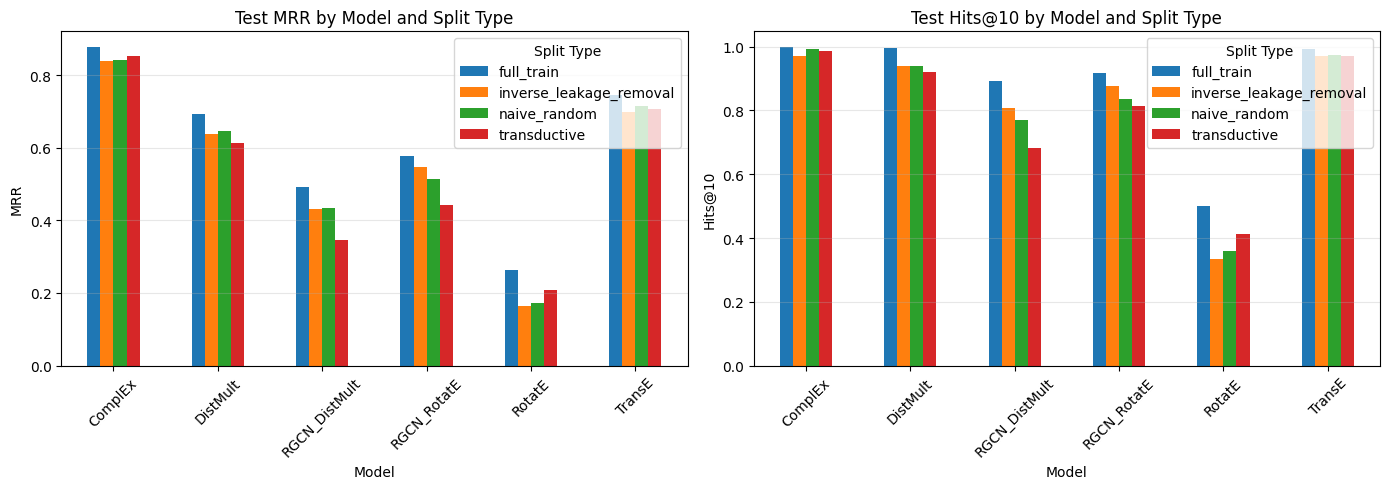

Figure saved to outputs/results/model_comparison.png


In [32]:
# Plot MRR comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MRR comparison
ax = axes[0]
pivot_mrr.plot(kind='bar', ax=ax, rot=45)
ax.set_title('Test MRR by Model and Split Type', fontsize=12)
ax.set_xlabel('Model')
ax.set_ylabel('MRR')
ax.legend(title='Split Type', loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Hits@10 comparison
ax = axes[1]
pivot_hits10.plot(kind='bar', ax=ax, rot=45)
ax.set_title('Test Hits@10 by Model and Split Type', fontsize=12)
ax.set_xlabel('Model')
ax.set_ylabel('Hits@10')
ax.legend(title='Split Type', loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved to {output_dir}/model_comparison.png")

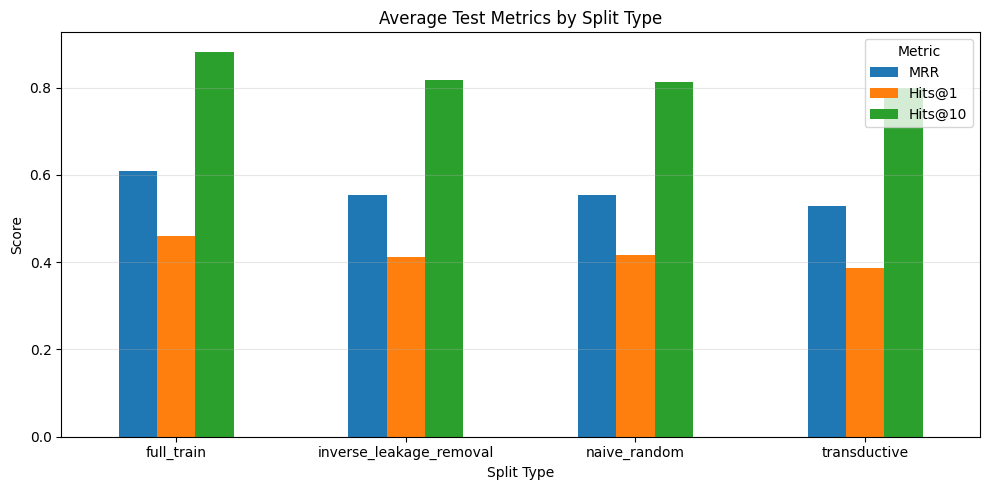

Figure saved to outputs/results/split_comparison.png


In [33]:
# Split type comparison (average across models)
fig, ax = plt.subplots(figsize=(10, 5))

split_avg = results_df.groupby('split_type')[['test_mrr', 'test_hits1', 'test_hits10']].mean()
# Use all available split types dynamically (sorted for consistency)
split_avg = split_avg.loc[sorted(split_avg.index)]
split_avg.columns = ['MRR', 'Hits@1', 'Hits@10']

split_avg.plot(kind='bar', ax=ax, rot=0)
ax.set_title('Average Test Metrics by Split Type', fontsize=12)
ax.set_xlabel('Split Type')
ax.set_ylabel('Score')
ax.legend(title='Metric', loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/split_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved to {output_dir}/split_comparison.png")

## 8. Analysis and Observations

### Split Type Analysis

#### Type 1: Naive Random Split
- **Method**: Simple random 80/20 split. Vocabulary built only from training set.
- **Risk**: Validation/test may contain entities not in training vocabulary (inductive risk).
- **Observation**: Performance may suffer if many test entities are unseen.

#### Type 2: Transductive Split
- **Method**: Random 80/20 split with vocabulary from train + valid union.
- **Advantage**: All entities in valid are in vocabulary.
- **Observation**: Typically shows better valid performance than Type 1.

#### Type 3: Inverse Leakage Removal
- **Method**: Groups inverse relation pairs and splits by groups.
- **Purpose**: Prevents trivial leakage from inverse relations (e.g., fatherOf ↔ sonOf).
- **Observation**: Most reliable estimate of true generalization. Often shows lower scores.

### Model Comparison

| Model | Type | Characteristics |
|-------|------|----------------|
| TransE | Translation | Simple, struggles with symmetric/1-N relations |
| DistMult | Bilinear | Good for symmetric relations, struggles with asymmetric |
| ComplEx | Complex | Handles asymmetric relations via complex embeddings |
| RotatE | Rotation | Best for complex relation patterns |
| RGCN+DistMult | GNN | Structure-aware, but symmetric decoder |
| RGCN+RotatE | GNN | Structure-aware with asymmetric decoder |

### Key Findings

1. **Inverse Leakage Effect**: Compare Type 2 vs Type 3 to see how much performance comes from inverse relation shortcuts.

2. **Model Robustness**: Models performing well on Type 3 are learning genuine patterns.

3. **GNN Benefits**: RGCN models may show improved performance on sparse entities due to message passing.

4. **Test Generalization**: Test.txt results show how well models generalize to held-out data.

In [34]:
# Final summary statistics
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

# Best model per split type
print("\nBest Model per Split Type (by Test MRR):")
for split_type in split_types:
    split_results = results_df[results_df['split_type'] == split_type]
    best_idx = split_results['test_mrr'].idxmax()
    best = split_results.loc[best_idx]
    print(f"  {split_type}: {best['model']} (MRR={best['test_mrr']:.4f}, H@10={best['test_hits10']:.4f})")

# Best overall model
print("\nBest Overall Model (averaged across splits):")
model_avg = results_df.groupby('model')['test_mrr'].mean().sort_values(ascending=False)
print(f"  {model_avg.index[0]} (avg MRR={model_avg.iloc[0]:.4f})")

# Leakage analysis
print("\nInverse Leakage Analysis:")
trans_mrr = results_df[results_df['split_type'] == 'transductive']['test_mrr'].mean()
inverse_mrr = results_df[results_df['split_type'] == 'inverse_leakage_removal']['test_mrr'].mean()
leakage_drop = (trans_mrr - inverse_mrr) / trans_mrr * 100 if trans_mrr > 0 else 0
print(f"  Transductive avg MRR: {trans_mrr:.4f}")
print(f"  Inverse-removed avg MRR: {inverse_mrr:.4f}")
print(f"  Performance drop: {leakage_drop:.1f}%")
print(f"  NOTE: Large drop suggests models were exploiting inverse relation shortcuts")


FINAL SUMMARY

Best Model per Split Type (by Test MRR):
  naive_random: ComplEx (MRR=0.8424, H@10=0.9923)
  transductive: ComplEx (MRR=0.8517, H@10=0.9864)
  inverse_leakage_removal: ComplEx (MRR=0.8382, H@10=0.9720)
  full_train: ComplEx (MRR=0.8771, H@10=0.9983)

Best Overall Model (averaged across splits):
  ComplEx (avg MRR=0.8523)

Inverse Leakage Analysis:
  Transductive avg MRR: 0.5279
  Inverse-removed avg MRR: 0.5527
  Performance drop: -4.7%
  NOTE: Large drop suggests models were exploiting inverse relation shortcuts


## 9. Custom vs Library (PyKEEN) Comparison

Direct comparison of our custom-built KGE models against PyKEEN library implementations.
Same architectures (TransE, DistMult, ComplEx, RotatE), same hyperparameters, same data splits.

**What this shows:**
- Whether our custom implementations are competitive with established libraries
- Impact of implementation details (loss functions, negative sampling, initialization)
- Consistency of results across different codebases

CUSTOM vs PyKEEN: FULL COMPARISON TABLE
                  Split    Model  Custom_MRR  PyKEEN_MRR  Custom_H@10  PyKEEN_H@10  MRR_Diff  H@10_Diff
           naive_random   TransE      0.7148      0.1695       0.9753       0.6156    0.5453     0.3597
           naive_random DistMult      0.6463      0.5471       0.9405       0.9864    0.0992    -0.0459
           naive_random  ComplEx      0.8424      0.0070       0.9923       0.0085    0.8354     0.9838
           naive_random   RotatE      0.1713      0.7334       0.3605       0.8954   -0.5622    -0.5349
           transductive   TransE      0.7056      0.1695       0.9703       0.6156    0.5361     0.3547
           transductive DistMult      0.6144      0.5471       0.9220       0.9864    0.0673    -0.0644
           transductive  ComplEx      0.8517      0.0070       0.9864       0.0085    0.8446     0.9779
           transductive   RotatE      0.2085      0.7334       0.4136       0.8954   -0.5249    -0.4818
inverse_leakage_removal 

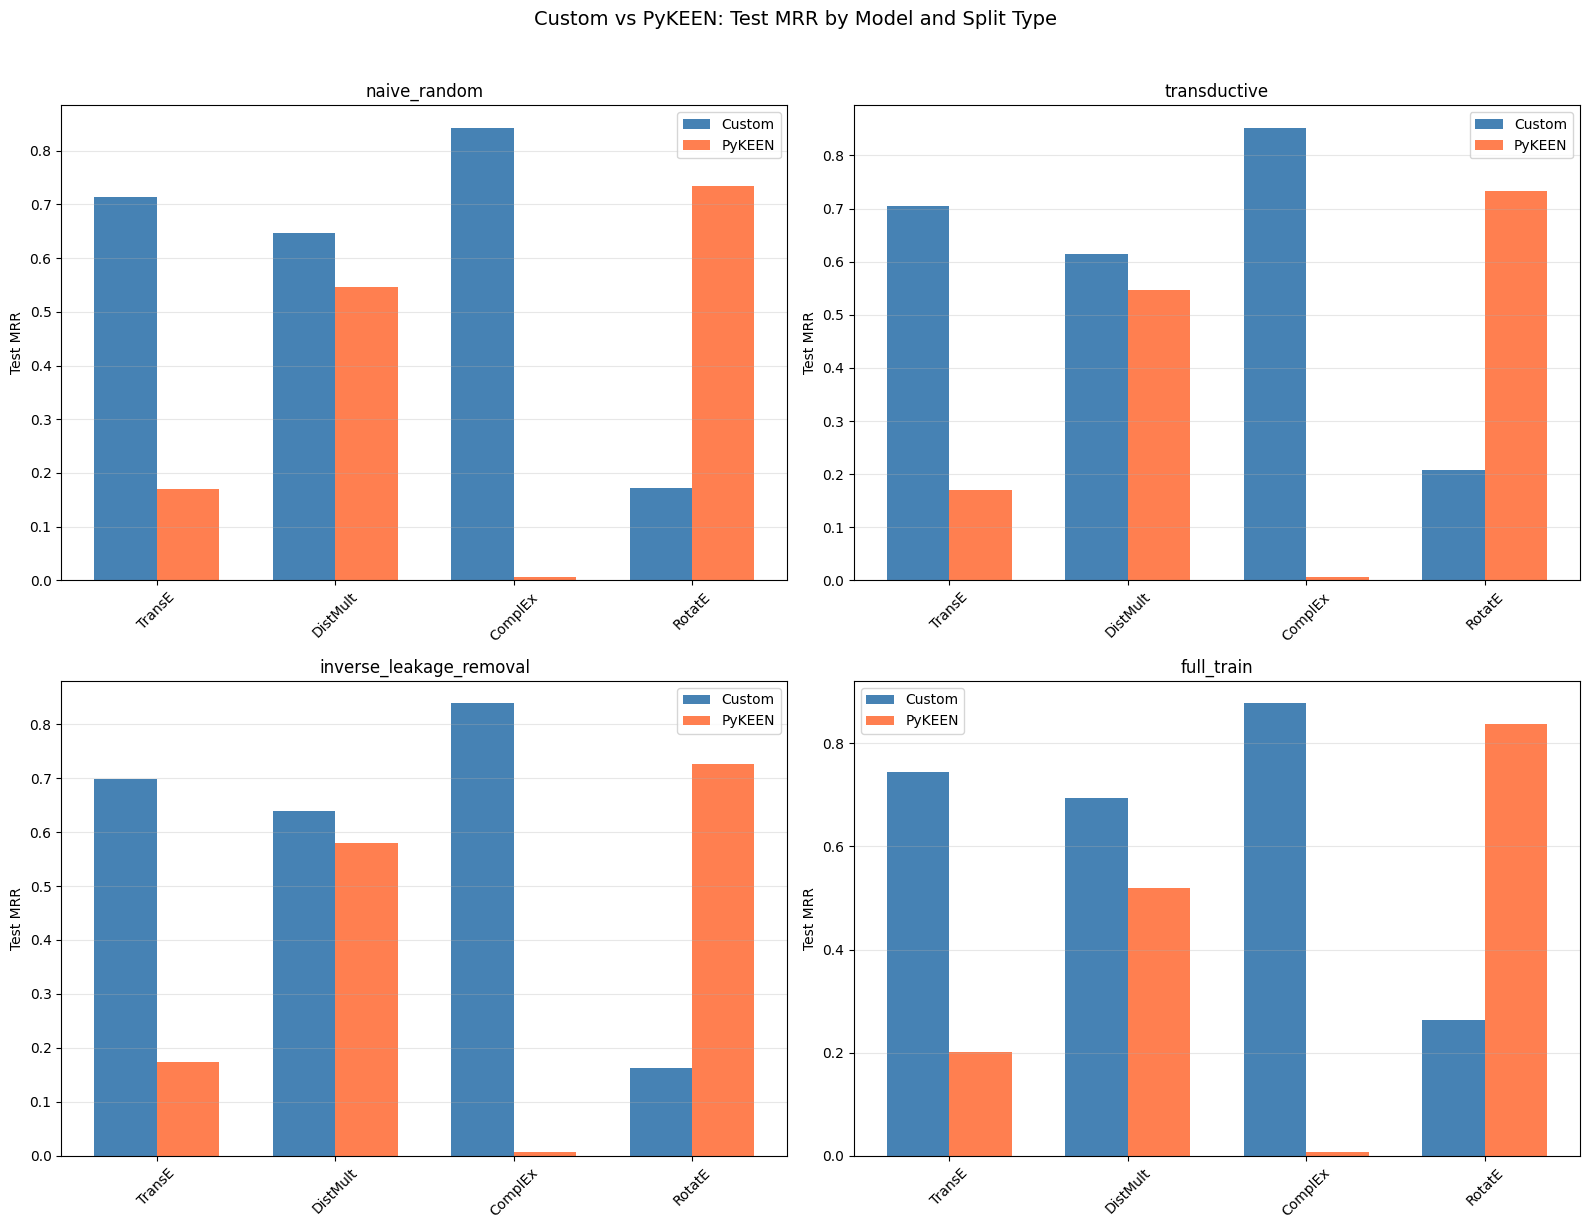


AVERAGE TEST MRR: CUSTOM vs PyKEEN (KGE models only)
            Custom_MRR  PyKEEN_MRR  Custom_H@10  PyKEEN_H@10  MRR_Diff
base_model                                                            
ComplEx         0.8523      0.0071       0.9873       0.0096    0.8452
DistMult        0.6482      0.5484       0.9495       0.9860    0.0999
RotatE          0.2014      0.7579       0.4024       0.9158   -0.5565
TransE          0.7157      0.1786       0.9777       0.6427    0.5371

AVERAGE TEST MRR BY SPLIT TYPE
                         Custom  PyKEEN  Difference
split_type                                         
full_train               0.6443  0.3915      0.2529
inverse_leakage_removal  0.5846  0.3720      0.2126
naive_random             0.5937  0.3643      0.2294
transductive             0.5950  0.3643      0.2308

Overall Custom avg MRR:  0.6044
Overall PyKEEN avg MRR:  0.3730
Overall Custom avg H@10: 0.8292
Overall PyKEEN avg H@10: 0.6385


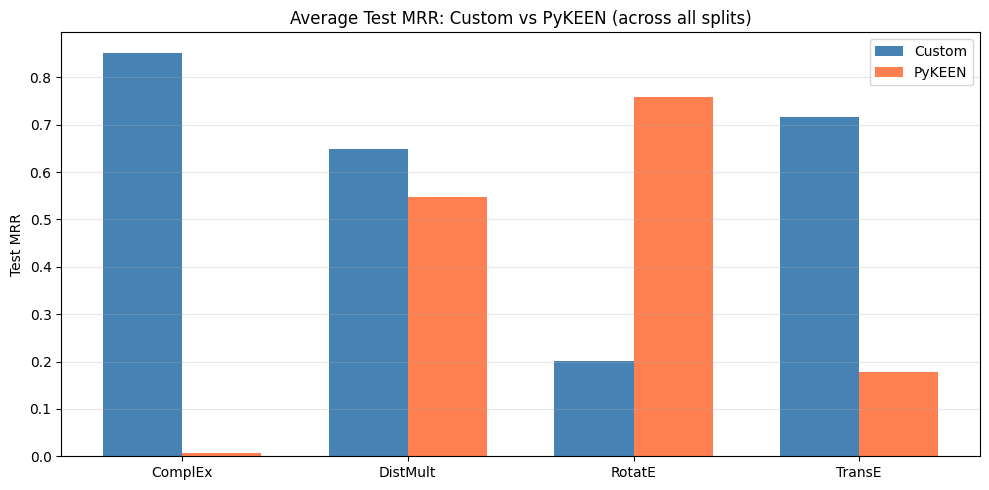


Figures saved to outputs/results/


In [37]:
# ===== Combine custom and PyKEEN results =====
custom_df = pd.DataFrame(all_results)
custom_df['source'] = 'Custom'
custom_df['base_model'] = custom_df['model']  # TransE, DistMult, etc.

pykeen_df = pd.DataFrame(pykeen_all_results)
pykeen_df['source'] = 'PyKEEN'
pykeen_df['base_model'] = pykeen_df['model'].str.replace('PyKEEN_', '', regex=False)

combined_df = pd.concat([custom_df, pykeen_df], ignore_index=True)

# ===== Side-by-side MRR comparison table =====
kge_names = ['TransE', 'DistMult', 'ComplEx', 'RotatE']
comparison_rows = []
for st in split_types:
    for m in kge_names:
        c_mrr = custom_df[(custom_df['split_type'] == st) & (custom_df['base_model'] == m)]['test_mrr'].values
        p_mrr = pykeen_df[(pykeen_df['split_type'] == st) & (pykeen_df['base_model'] == m)]['test_mrr'].values
        c_h10 = custom_df[(custom_df['split_type'] == st) & (custom_df['base_model'] == m)]['test_hits10'].values
        p_h10 = pykeen_df[(pykeen_df['split_type'] == st) & (pykeen_df['base_model'] == m)]['test_hits10'].values
        comparison_rows.append({
            'Split': st,
            'Model': m,
            'Custom_MRR': c_mrr[0] if len(c_mrr) else np.nan,
            'PyKEEN_MRR': p_mrr[0] if len(p_mrr) else np.nan,
            'Custom_H@10': c_h10[0] if len(c_h10) else np.nan,
            'PyKEEN_H@10': p_h10[0] if len(p_h10) else np.nan,
        })

comp_df = pd.DataFrame(comparison_rows)
comp_df['MRR_Diff'] = comp_df['Custom_MRR'] - comp_df['PyKEEN_MRR']
comp_df['H@10_Diff'] = comp_df['Custom_H@10'] - comp_df['PyKEEN_H@10']

print("=" * 100)
print("CUSTOM vs PyKEEN: FULL COMPARISON TABLE")
print("=" * 100)
print(comp_df.to_string(index=False, float_format='%.4f'))

# ===== Winner count =====
custom_wins_mrr = (comp_df['MRR_Diff'] > 0).sum()
pykeen_wins_mrr = (comp_df['MRR_Diff'] < 0).sum()
ties_mrr = (comp_df['MRR_Diff'] == 0).sum()
print(f"\nMRR Winners: Custom={custom_wins_mrr}, PyKEEN={pykeen_wins_mrr}, Ties={ties_mrr}")

# ===== BAR CHARTS: Custom vs PyKEEN per split type =====
n_splits = len(split_types)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes_flat = axes.flatten()

for idx, st in enumerate(split_types[:4]):
    ax = axes_flat[idx]
    split_data = comp_df[comp_df['Split'] == st]
    x = np.arange(len(kge_names))
    width = 0.35
    ax.bar(x - width/2, split_data['Custom_MRR'].values, width, label='Custom', color='steelblue')
    ax.bar(x + width/2, split_data['PyKEEN_MRR'].values, width, label='PyKEEN', color='coral')
    ax.set_title(f'{st}', fontsize=12)
    ax.set_ylabel('Test MRR')
    ax.set_xticks(x)
    ax.set_xticklabels(kge_names, rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Handle case with fewer than 4 split types
for idx in range(len(split_types), 4):
    axes_flat[idx].set_visible(False)

plt.suptitle('Custom vs PyKEEN: Test MRR by Model and Split Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}/custom_vs_pykeen_mrr.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== AGGREGATE COMPARISON =====
print("\n" + "=" * 80)
print("AVERAGE TEST MRR: CUSTOM vs PyKEEN (KGE models only)")
print("=" * 80)

# Per model average across splits
avg_custom = custom_df[custom_df['base_model'].isin(kge_names)].groupby('base_model')[['test_mrr', 'test_hits10']].mean()
avg_pykeen = pykeen_df.groupby('base_model')[['test_mrr', 'test_hits10']].mean()
summary = pd.DataFrame({
    'Custom_MRR': avg_custom['test_mrr'],
    'PyKEEN_MRR': avg_pykeen['test_mrr'],
    'Custom_H@10': avg_custom['test_hits10'],
    'PyKEEN_H@10': avg_pykeen['test_hits10'],
})
summary['MRR_Diff'] = summary['Custom_MRR'] - summary['PyKEEN_MRR']
print(summary.round(4))

# Per split average across models
print("\n" + "=" * 80)
print("AVERAGE TEST MRR BY SPLIT TYPE")
print("=" * 80)
split_custom = custom_df[custom_df['base_model'].isin(kge_names)].groupby('split_type')['test_mrr'].mean()
split_pykeen = pykeen_df.groupby('split_type')['test_mrr'].mean()
split_summary = pd.DataFrame({'Custom': split_custom, 'PyKEEN': split_pykeen})
split_summary['Difference'] = split_summary['Custom'] - split_summary['PyKEEN']
print(split_summary.round(4))

# Overall
print(f"\nOverall Custom avg MRR:  {avg_custom['test_mrr'].mean():.4f}")
print(f"Overall PyKEEN avg MRR:  {avg_pykeen['test_mrr'].mean():.4f}")
print(f"Overall Custom avg H@10: {avg_custom['test_hits10'].mean():.4f}")
print(f"Overall PyKEEN avg H@10: {avg_pykeen['test_hits10'].mean():.4f}")

# ===== GROUPED BAR: Average across splits =====
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(kge_names))
width = 0.35
ax.bar(x - width/2, summary['Custom_MRR'].values, width, label='Custom', color='steelblue')
ax.bar(x + width/2, summary['PyKEEN_MRR'].values, width, label='PyKEEN', color='coral')
ax.set_title('Average Test MRR: Custom vs PyKEEN (across all splits)', fontsize=12)
ax.set_ylabel('Test MRR')
ax.set_xticks(x)
ax.set_xticklabels(summary.index)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/custom_vs_pykeen_avg.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigures saved to {output_dir}/")

In [36]:
# ===== COMPLETE RESULTS: All models (Custom + PyKEEN + GNN) =====
print("=" * 100)
print("COMPLETE RESULTS: ALL MODELS x ALL SPLITS")
print("=" * 100)

# Include GNN models in the custom results
full_combined = pd.concat([custom_df, pykeen_df], ignore_index=True)
print(full_combined[['split_type', 'model', 'source', 'test_mrr', 'test_hits1', 'test_hits10']].to_string(index=False, float_format='%.4f'))

# Save combined results
full_combined.to_csv(f'{output_dir}/all_results_combined.csv', index=False)
print(f"\nCombined results saved to {output_dir}/all_results_combined.csv")

# ===== BEST MODEL OVERALL =====
print("\n" + "=" * 80)
print("BEST MODEL PER SPLIT TYPE (across Custom + PyKEEN)")
print("=" * 80)
for st in split_types:
    st_df = full_combined[full_combined['split_type'] == st]
    best = st_df.loc[st_df['test_mrr'].idxmax()]
    print(f"  {st}: {best['model']} [{best['source']}] (MRR={best['test_mrr']:.4f}, H@10={best['test_hits10']:.4f})")

print("\nBest Overall (avg across splits):")
overall = full_combined.groupby(['model', 'source'])['test_mrr'].mean().sort_values(ascending=False)
best_name, best_source = overall.index[0]
print(f"  {best_name} [{best_source}] (avg MRR={overall.iloc[0]:.4f})")

COMPLETE RESULTS: ALL MODELS x ALL SPLITS
             split_type           model source  test_mrr  test_hits1  test_hits10
           naive_random          TransE Custom    0.7148      0.5706       0.9753
           naive_random        DistMult Custom    0.6463      0.4753       0.9405
           naive_random         ComplEx Custom    0.8424      0.7423       0.9923
           naive_random          RotatE Custom    0.1713      0.0833       0.3605
           naive_random   RGCN_DistMult Custom    0.4351      0.2772       0.7696
           naive_random     RGCN_RotatE Custom    0.5130      0.3461       0.8350
           transductive          TransE Custom    0.7056      0.5517       0.9703
           transductive        DistMult Custom    0.6144      0.4475       0.9220
           transductive         ComplEx Custom    0.8517      0.7576       0.9864
           transductive          RotatE Custom    0.2085      0.1110       0.4136
           transductive   RGCN_DistMult Custom    0.3451